In [1]:
!pip install ripser transformers accelerate torch numpy pandas tqdm networkx hf_transfer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 21.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 131.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 70.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 113.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 263.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.4/803.4 kB 110.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 116.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 26.1 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 245.7 MB/s  0:00:00
   ━━━━

In [2]:
from huggingface_hub import login
login()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import ripser
from ripser import ripser
from tqdm import tqdm
import math
import numpy as geek
import networkx as nx

def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf


def get_second_value_ignoring_inf(data):
    """Returns the second non-inf value in a list."""
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]

def get_llama_attention(text, model, tokenizer):
    """Extract attention matrix from Llama model"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention matrices and move to CPU
    attention_matrices = torch.stack(outputs.attentions).cpu()
    
    # Average across layers and heads
    attention_matrix = attention_matrices.mean(dim=0).mean(dim=1).squeeze().numpy()
    
    # Zero out the diagonal to focus on token-to-token relationships
    np.fill_diagonal(attention_matrix, 0)
    
    # Make symmetric for undirected graph
    attention_matrix = (attention_matrix + attention_matrix.T) / 2
    
    return attention_matrix

def build_graph(attention_matrix, threshold=None, percentile=50):
    """
    Build graph from attention matrix.
    If threshold is None, use percentile-based threshold instead.
    """
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]
    
    # Add all nodes first
    graph.add_nodes_from(range(num_nodes))
    
    # Get upper triangle values (excluding diagonal)
    upper_triangle_indices = np.triu_indices(num_nodes, k=1)
    upper_triangle_values = attention_matrix[upper_triangle_indices]
    
    # Filter out zeros and NaNs for percentile calculation
    non_zero_values = upper_triangle_values[upper_triangle_values > 0]
    non_zero_values = non_zero_values[~np.isnan(non_zero_values)]
    
    # Use percentile-based threshold if not specified
    if threshold is None:
        if len(non_zero_values) > 0:
            try:
                threshold = np.percentile(non_zero_values, percentile)
                if np.isnan(threshold) or threshold == 0:
                    # Fallback to a small fraction of max value
                    threshold = np.max(non_zero_values) * 0.1
                    print(f"Using fallback threshold (10% of max): {threshold:.6f}")
                else:
                    print(f"Using percentile-based threshold: {threshold:.6f} ({percentile}th percentile)")
                print(f"Non-zero values: {len(non_zero_values)}/{len(upper_triangle_values)} ({100*len(non_zero_values)/len(upper_triangle_values):.1f}%)")
                print(f"Value range: [{np.min(non_zero_values):.6f}, {np.max(non_zero_values):.6f}]")
            except:
                threshold = 0.001
                print(f"Error calculating percentile, using default threshold: {threshold}")
        else:
            threshold = 0.0
            print(f"WARNING: No non-zero attention values found!")
    else:
        print(f"Using fixed threshold: {threshold}")
    
    edge_count = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])
                edge_count += 1
    
    print(f"Graph created: {num_nodes} nodes, {edge_count} edges")
    
    if edge_count == 0:
        print(f"WARNING: No edges created! Threshold was {threshold:.6f}, max value was {upper_triangle_values.max():.6f}")
    
    return graph

def process_texts(texts, model_name="meta-llama/Llama-3.1-8B"):
    """Process texts using Llama model for attention extraction"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True,
        attn_implementation="eager"
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    data = []
    for text in tqdm(texts):
        try:
            attention_matrix = get_llama_attention(text, model, tokenizer)
            graph = build_graph(attention_matrix, threshold=None, percentile=50)
            tda_features = compute_tda_features(graph)
            data.append(tda_features)
        except Exception as e:
            print(f"Error processing text: {e}")
            data.append([0] * 12)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

def compute_tda_features(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    
    # Check if graph is empty or has no edges
    if adjacency_matrix.shape[0] == 0 or np.sum(adjacency_matrix) == 0:
        print("Empty graph, returning zero features")
        return [0] * 12
    
    # Use distance matrix for ripser
    distance_matrix = 1 - adjacency_matrix
    np.fill_diagonal(distance_matrix, 0)
    
    diagrams = ripser(distance_matrix, maxdim=1, distance_matrix=True)['dgms']
    
    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = geek.count_nonzero(np.round(h0))
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0

    num_h1 = geek.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])
    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)

    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]

In [9]:
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts)
print(df)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.01it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.471680, mean: 0.115845
Using percentile-based threshold: 0.015778 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006222, 0.471680]
Graph created: 7 nodes, 10 edges
Attention shape: (7, 7), min: 0.000000, max: 0.476318, mean: 0.115540
Using percentile-based threshold: 0.018997 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008690, 0.476318]
Graph created: 7 nodes, 10 edges
   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         7  0.611816               0.067627   0.241752              7   
1         7  0.611816               0.065674   0.242536              7   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.933568         0         0                      0   
1               1.928764         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0

In [ ]:
!pip install pyarrow fastparquet datasets

In [15]:
import pyarrow
import pyarrow.parquet as pq

from datasets import load_dataset

# Load the dataset
dataset = load_dataset("acmc/watermarked_c4_dataset", split="train")

# Convert to pandas
data_water = dataset.to_pandas()

# Filter the data
water = data_water[data_water['generated'] == True][0:500]
nonwater = data_water[data_water['generated'] == False][0:500]

# Process
nonwater_tda = process_texts(nonwater['text'])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<01:54,  4.36it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.475098, mean: 0.002432
Using fallback threshold (10% of max): 0.047485
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000011, 0.475098]
Graph created: 394 nodes, 393 edges


  0%|          | 2/500 [00:00<01:57,  4.25it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.473145, mean: 0.002403
Using fallback threshold (10% of max): 0.047302
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000009, 0.473145]
Graph created: 398 nodes, 397 edges


  1%|          | 3/500 [00:00<01:59,  4.17it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.476318, mean: 0.002394
Using fallback threshold (10% of max): 0.047607
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000016, 0.476318]
Graph created: 401 nodes, 400 edges


  1%|          | 4/500 [00:00<01:52,  4.39it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.470703, mean: 0.002573
Using fallback threshold (10% of max): 0.047058
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000011, 0.470703]
Graph created: 372 nodes, 371 edges


  1%|          | 5/500 [00:01<01:54,  4.31it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.480957, mean: 0.002451
Using fallback threshold (10% of max): 0.048096
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000007, 0.480957]
Graph created: 391 nodes, 390 edges


  1%|          | 6/500 [00:01<01:53,  4.34it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.475830, mean: 0.002485
Using fallback threshold (10% of max): 0.047577
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000011, 0.475830]
Graph created: 386 nodes, 385 edges
Attention shape: (333, 333), min: 0.000000, max: 0.472168, mean: 0.002884
Using percentile-based threshold: 0.000353 (50th percentile)
Non-zero values: 55278/55278 (100.0%)
Value range: [0.000017, 0.472168]


  1%|▏         | 7/500 [00:01<01:57,  4.21it/s]

Graph created: 333 nodes, 27639 edges


  2%|▏         | 8/500 [00:01<01:53,  4.35it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.471924, mean: 0.002535
Using fallback threshold (10% of max): 0.047180
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000010, 0.471924]
Graph created: 377 nodes, 376 edges


  2%|▏         | 9/500 [00:02<01:52,  4.35it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.476807, mean: 0.002497
Using fallback threshold (10% of max): 0.047668
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.476807]
Graph created: 384 nodes, 383 edges


  2%|▏         | 10/500 [00:02<01:51,  4.39it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.478516, mean: 0.002506
Using fallback threshold (10% of max): 0.047852
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000015, 0.478516]
Graph created: 384 nodes, 383 edges
Attention shape: (338, 338), min: 0.000000, max: 0.475586, mean: 0.002834
Using percentile-based threshold: 0.000261 (50th percentile)
Non-zero values: 56953/56953 (100.0%)
Value range: [0.000009, 0.475586]


  2%|▏         | 11/500 [00:02<01:53,  4.33it/s]

Graph created: 338 nodes, 28457 edges


  2%|▏         | 12/500 [00:02<01:54,  4.26it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.473877, mean: 0.002439
Using fallback threshold (10% of max): 0.047363
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000020, 0.473877]
Graph created: 394 nodes, 393 edges


  3%|▎         | 13/500 [00:03<01:55,  4.21it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.473877, mean: 0.002489
Using fallback threshold (10% of max): 0.047363
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000003, 0.473877]
Graph created: 385 nodes, 384 edges


  3%|▎         | 14/500 [00:03<01:53,  4.27it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.476074, mean: 0.002516
Using fallback threshold (10% of max): 0.047607
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000018, 0.476074]
Graph created: 381 nodes, 380 edges


  3%|▎         | 15/500 [00:03<01:56,  4.17it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.477295, mean: 0.002396
Using fallback threshold (10% of max): 0.047729
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000011, 0.477295]
Graph created: 400 nodes, 399 edges


  3%|▎         | 16/500 [00:03<01:56,  4.14it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.478516, mean: 0.002466
Using fallback threshold (10% of max): 0.047852
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000012, 0.478516]
Graph created: 389 nodes, 388 edges


  3%|▎         | 17/500 [00:03<01:53,  4.24it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.480957, mean: 0.002539
Using fallback threshold (10% of max): 0.048096
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000008, 0.480957]
Graph created: 377 nodes, 376 edges


  4%|▎         | 18/500 [00:04<01:53,  4.25it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.480713, mean: 0.002506
Using fallback threshold (10% of max): 0.048065
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000012, 0.480713]
Graph created: 383 nodes, 382 edges


  4%|▍         | 19/500 [00:04<01:55,  4.18it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.481689, mean: 0.002361
Using fallback threshold (10% of max): 0.048157
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000008, 0.481689]
Graph created: 406 nodes, 405 edges


  4%|▍         | 20/500 [00:04<01:55,  4.16it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.474121, mean: 0.002428
Using fallback threshold (10% of max): 0.047394
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000017, 0.474121]
Graph created: 396 nodes, 395 edges


  4%|▍         | 21/500 [00:04<01:53,  4.20it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.472168, mean: 0.002464
Using fallback threshold (10% of max): 0.047211
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 389 nodes, 388 edges


  4%|▍         | 22/500 [00:05<01:53,  4.22it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.468506, mean: 0.002460
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000018, 0.468506]
Graph created: 390 nodes, 389 edges


  5%|▍         | 23/500 [00:05<01:52,  4.25it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.468506, mean: 0.002489
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 385 nodes, 384 edges


  5%|▍         | 24/500 [00:05<01:49,  4.34it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.479980, mean: 0.002518
Using fallback threshold (10% of max): 0.047974
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000009, 0.479980]
Graph created: 381 nodes, 380 edges


  5%|▌         | 25/500 [00:05<01:50,  4.28it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.481445, mean: 0.002426
Using fallback threshold (10% of max): 0.048126
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000010, 0.481445]
Graph created: 395 nodes, 394 edges


  5%|▌         | 26/500 [00:06<01:55,  4.10it/s]

Attention shape: (411, 411), min: 0.000000, max: 0.479004, mean: 0.002335
Using fallback threshold (10% of max): 0.047882
Non-zero values: 84255/84255 (100.0%)
Value range: [0.000011, 0.479004]
Graph created: 411 nodes, 410 edges


  5%|▌         | 27/500 [00:06<01:57,  4.03it/s]

Attention shape: (358, 358), min: 0.000000, max: 0.480957, mean: 0.002674
Using percentile-based threshold: 0.000264 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000009, 0.480957]
Graph created: 358 nodes, 31941 edges


  6%|▌         | 28/500 [00:06<01:57,  4.01it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.468506, mean: 0.002468
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000019, 0.468506]
Graph created: 389 nodes, 388 edges


  6%|▌         | 29/500 [00:06<02:00,  3.92it/s]

Attention shape: (355, 355), min: 0.000000, max: 0.475098, mean: 0.002697
Using percentile-based threshold: 0.000277 (50th percentile)
Non-zero values: 62835/62835 (100.0%)
Value range: [0.000015, 0.475098]
Graph created: 355 nodes, 31402 edges


  6%|▌         | 30/500 [00:07<01:59,  3.92it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.473145, mean: 0.002407
Using fallback threshold (10% of max): 0.047302
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000007, 0.473145]
Graph created: 398 nodes, 397 edges


  6%|▌         | 31/500 [00:07<01:58,  3.96it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.469971, mean: 0.002413
Using fallback threshold (10% of max): 0.046997
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000013, 0.469971]
Graph created: 397 nodes, 396 edges


  6%|▋         | 32/500 [00:07<01:55,  4.05it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.469971, mean: 0.002516
Using fallback threshold (10% of max): 0.046997
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.469971]
Graph created: 381 nodes, 380 edges


  7%|▋         | 33/500 [00:07<01:50,  4.21it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.476318, mean: 0.002628
Using fallback threshold (10% of max): 0.047607
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000011, 0.476318]
Graph created: 364 nodes, 363 edges


  7%|▋         | 34/500 [00:08<01:51,  4.19it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.479980, mean: 0.002491
Using fallback threshold (10% of max): 0.047974
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000004, 0.479980]
Graph created: 385 nodes, 387 edges


  7%|▋         | 35/500 [00:08<01:51,  4.16it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.469971, mean: 0.002447
Using fallback threshold (10% of max): 0.046997
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.469971]
Graph created: 392 nodes, 391 edges


  7%|▋         | 36/500 [00:08<01:53,  4.09it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.474609, mean: 0.002460
Using fallback threshold (10% of max): 0.047455
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000015, 0.474609]
Graph created: 390 nodes, 389 edges


  7%|▋         | 37/500 [00:08<01:54,  4.03it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.469971, mean: 0.002384
Using fallback threshold (10% of max): 0.046997
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000008, 0.469971]
Graph created: 402 nodes, 401 edges


  8%|▊         | 38/500 [00:09<01:52,  4.11it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.477295, mean: 0.002579
Using fallback threshold (10% of max): 0.047729
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000012, 0.477295]
Graph created: 371 nodes, 370 edges


  8%|▊         | 39/500 [00:09<01:56,  3.97it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.475098, mean: 0.002649
Using percentile-based threshold: 0.000339 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000018, 0.475098]
Graph created: 362 nodes, 32658 edges


  8%|▊         | 40/500 [00:09<01:57,  3.93it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.479980, mean: 0.002455
Using fallback threshold (10% of max): 0.047974
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000011, 0.479980]
Graph created: 391 nodes, 390 edges


  8%|▊         | 41/500 [00:09<01:52,  4.07it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.473877, mean: 0.002537
Using fallback threshold (10% of max): 0.047363
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000015, 0.473877]
Graph created: 378 nodes, 377 edges


  8%|▊         | 42/500 [00:10<01:51,  4.09it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.475830, mean: 0.002512
Using fallback threshold (10% of max): 0.047577
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000007, 0.475830]
Graph created: 383 nodes, 382 edges


  9%|▊         | 43/500 [00:10<01:51,  4.09it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.481934, mean: 0.002441
Using fallback threshold (10% of max): 0.048187
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000013, 0.481934]
Graph created: 393 nodes, 392 edges


  9%|▉         | 44/500 [00:10<01:49,  4.17it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.475098, mean: 0.002485
Using fallback threshold (10% of max): 0.047485
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000006, 0.475098]
Graph created: 386 nodes, 385 edges


  9%|▉         | 45/500 [00:10<01:49,  4.17it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.481201, mean: 0.002409
Using fallback threshold (10% of max): 0.048096
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000013, 0.481201]
Graph created: 398 nodes, 397 edges


  9%|▉         | 46/500 [00:11<01:48,  4.20it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.474609, mean: 0.002451
Using fallback threshold (10% of max): 0.047455
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000014, 0.474609]
Graph created: 392 nodes, 391 edges


  9%|▉         | 47/500 [00:11<01:45,  4.31it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.479248, mean: 0.002508
Using fallback threshold (10% of max): 0.047913
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000010, 0.479248]
Graph created: 382 nodes, 381 edges
Attention shape: (358, 358), min: 0.000000, max: 0.469971, mean: 0.002672


 10%|▉         | 48/500 [00:11<01:48,  4.18it/s]

Using percentile-based threshold: 0.000339 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000016, 0.469971]
Graph created: 358 nodes, 31943 edges


 10%|▉         | 49/500 [00:11<01:48,  4.17it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.477051, mean: 0.002428
Using fallback threshold (10% of max): 0.047699
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000012, 0.477051]
Graph created: 394 nodes, 393 edges


 10%|█         | 50/500 [00:11<01:46,  4.23it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.470459, mean: 0.002489
Using fallback threshold (10% of max): 0.047028
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000015, 0.470459]
Graph created: 386 nodes, 385 edges


 10%|█         | 51/500 [00:12<01:42,  4.38it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.472168, mean: 0.002607
Using fallback threshold (10% of max): 0.047211
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000007, 0.472168]
Graph created: 367 nodes, 366 edges


 10%|█         | 52/500 [00:12<01:43,  4.31it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.477539, mean: 0.002430
Using fallback threshold (10% of max): 0.047729
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000009, 0.477539]
Graph created: 395 nodes, 394 edges


 11%|█         | 53/500 [00:12<01:40,  4.45it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.472412, mean: 0.002605
Using fallback threshold (10% of max): 0.047241
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000012, 0.472412]
Graph created: 368 nodes, 367 edges
Attention shape: (347, 347), min: 0.000000, max: 0.477539, mean: 0.002758
Using percentile-based threshold: 0.000243 (50th percentile)
Non-zero values: 60031/60031 (100.0%)
Value range: [0.000011, 0.477539]


 11%|█         | 54/500 [00:12<01:43,  4.31it/s]

Graph created: 347 nodes, 30006 edges


 11%|█         | 55/500 [00:13<01:41,  4.39it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.478760, mean: 0.002516
Using fallback threshold (10% of max): 0.047852
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000010, 0.478760]
Graph created: 381 nodes, 380 edges


 11%|█         | 56/500 [00:13<01:39,  4.45it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.473145, mean: 0.002531
Using fallback threshold (10% of max): 0.047302
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000017, 0.473145]
Graph created: 379 nodes, 378 edges


 11%|█▏        | 57/500 [00:13<01:40,  4.41it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.476562, mean: 0.002468
Using fallback threshold (10% of max): 0.047638
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000017, 0.476562]
Graph created: 389 nodes, 388 edges


 12%|█▏        | 58/500 [00:13<01:42,  4.30it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.480225, mean: 0.002403
Using fallback threshold (10% of max): 0.048004
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000008, 0.480225]
Graph created: 398 nodes, 397 edges


 12%|█▏        | 59/500 [00:14<01:43,  4.27it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.476807, mean: 0.002417
Using fallback threshold (10% of max): 0.047668
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000016, 0.476807]
Graph created: 396 nodes, 395 edges


 12%|█▏        | 60/500 [00:14<01:47,  4.11it/s]

Attention shape: (354, 354), min: 0.000000, max: 0.479736, mean: 0.002703
Using percentile-based threshold: 0.000309 (50th percentile)
Non-zero values: 62481/62481 (100.0%)
Value range: [0.000015, 0.479736]
Graph created: 354 nodes, 31242 edges


 12%|█▏        | 61/500 [00:14<01:47,  4.07it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.472900, mean: 0.002317
Using fallback threshold (10% of max): 0.047272
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000008, 0.472900]
Graph created: 414 nodes, 413 edges


 12%|█▏        | 62/500 [00:14<01:48,  4.05it/s]

Attention shape: (405, 405), min: 0.000000, max: 0.478760, mean: 0.002371
Using fallback threshold (10% of max): 0.047852
Non-zero values: 81810/81810 (100.0%)
Value range: [0.000005, 0.478760]
Graph created: 405 nodes, 404 edges


 13%|█▎        | 63/500 [00:15<01:43,  4.23it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.473389, mean: 0.002501
Using fallback threshold (10% of max): 0.047333
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000007, 0.473389]
Graph created: 383 nodes, 382 edges


 13%|█▎        | 64/500 [00:15<01:40,  4.34it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.469238, mean: 0.002504
Using fallback threshold (10% of max): 0.046906
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000015, 0.469238]
Graph created: 382 nodes, 381 edges


 13%|█▎        | 65/500 [00:15<01:41,  4.28it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.473145, mean: 0.002428
Using fallback threshold (10% of max): 0.047302
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 395 nodes, 394 edges


 13%|█▎        | 66/500 [00:15<01:38,  4.42it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.476318, mean: 0.002584
Using fallback threshold (10% of max): 0.047607
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000016, 0.476318]
Graph created: 372 nodes, 371 edges


 13%|█▎        | 67/500 [00:15<01:42,  4.24it/s]

Attention shape: (358, 358), min: 0.000000, max: 0.472656, mean: 0.002672
Using percentile-based threshold: 0.000264 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000015, 0.472656]
Graph created: 358 nodes, 31935 edges


 14%|█▎        | 68/500 [00:16<01:38,  4.40it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.474609, mean: 0.002609
Using fallback threshold (10% of max): 0.047455
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000022, 0.474609]
Graph created: 368 nodes, 367 edges


 14%|█▍        | 69/500 [00:16<01:35,  4.52it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.468506, mean: 0.002609
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 367 nodes, 367 edges
Attention shape: (349, 349), min: 0.000000, max: 0.477295, mean: 0.002748
Using percentile-based threshold: 0.000282 (50th percentile)
Non-zero values: 60726/60726 (100.0%)
Value range: [0.000018, 0.477295]


 14%|█▍        | 70/500 [00:16<01:38,  4.36it/s]

Graph created: 349 nodes, 30357 edges


 14%|█▍        | 71/500 [00:16<01:40,  4.27it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.473145, mean: 0.002392
Using fallback threshold (10% of max): 0.047302
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000007, 0.473145]
Graph created: 400 nodes, 399 edges


 14%|█▍        | 72/500 [00:17<01:41,  4.23it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.472656, mean: 0.002411
Using fallback threshold (10% of max): 0.047241
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000015, 0.472656]
Graph created: 398 nodes, 397 edges


 15%|█▍        | 73/500 [00:17<01:41,  4.21it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.472168, mean: 0.002438
Using fallback threshold (10% of max): 0.047211
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000017, 0.472168]
Graph created: 393 nodes, 394 edges


 15%|█▍        | 74/500 [00:17<01:44,  4.08it/s]

Attention shape: (358, 358), min: 0.000000, max: 0.474121, mean: 0.002674
Using percentile-based threshold: 0.000244 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000008, 0.474121]
Graph created: 358 nodes, 31947 edges


 15%|█▌        | 75/500 [00:17<01:41,  4.20it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.470947, mean: 0.002493
Using fallback threshold (10% of max): 0.047089
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000012, 0.470947]
Graph created: 384 nodes, 383 edges


 15%|█▌        | 76/500 [00:18<01:42,  4.15it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.479736, mean: 0.002401
Using fallback threshold (10% of max): 0.047974
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000017, 0.479736]
Graph created: 400 nodes, 399 edges


 15%|█▌        | 77/500 [00:18<01:39,  4.25it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.476562, mean: 0.002501
Using fallback threshold (10% of max): 0.047638
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000011, 0.476562]
Graph created: 384 nodes, 383 edges


 16%|█▌        | 78/500 [00:18<01:37,  4.34it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.473145, mean: 0.002567
Using fallback threshold (10% of max): 0.047302
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000013, 0.473145]
Graph created: 373 nodes, 372 edges


 16%|█▌        | 79/500 [00:18<01:37,  4.30it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.479248, mean: 0.002462
Using fallback threshold (10% of max): 0.047913
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000007, 0.479248]
Graph created: 390 nodes, 389 edges
Attention shape: (317, 317), min: 0.000000, max: 0.469971, mean: 0.003017
Using percentile-based threshold: 0.000324 (50th percentile)
Non-zero values: 50086/50086 (100.0%)
Value range: [0.000016, 0.469971]


 16%|█▌        | 80/500 [00:18<01:35,  4.41it/s]

Graph created: 317 nodes, 25033 edges


 16%|█▌        | 81/500 [00:19<01:36,  4.32it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.474121, mean: 0.002453
Using fallback threshold (10% of max): 0.047394
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000014, 0.474121]
Graph created: 392 nodes, 391 edges


 16%|█▋        | 82/500 [00:19<01:40,  4.15it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.473877, mean: 0.002319
Using fallback threshold (10% of max): 0.047363
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000012, 0.473877]
Graph created: 414 nodes, 413 edges
Attention shape: (310, 310), min: 0.000000, max: 0.471924, mean: 0.003090
Using percentile-based threshold: 0.000363 (50th percentile)
Non-zero values: 47895/47895 (100.0%)
Value range: [0.000012, 0.471924]


 17%|█▋        | 83/500 [00:19<01:36,  4.33it/s]

Graph created: 310 nodes, 23934 edges


 17%|█▋        | 84/500 [00:19<01:37,  4.26it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.468506, mean: 0.002455
Using fallback threshold (10% of max): 0.046844
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 391 nodes, 390 edges


 17%|█▋        | 85/500 [00:20<01:34,  4.38it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.470703, mean: 0.002636
Using fallback threshold (10% of max): 0.047058
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 364 nodes, 363 edges


 17%|█▋        | 86/500 [00:20<01:37,  4.25it/s]

Attention shape: (404, 404), min: 0.000000, max: 0.471680, mean: 0.002378
Using fallback threshold (10% of max): 0.047150
Non-zero values: 81406/81406 (100.0%)
Value range: [0.000014, 0.471680]
Graph created: 404 nodes, 403 edges


 17%|█▋        | 87/500 [00:20<01:38,  4.17it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.477295, mean: 0.002411
Using fallback threshold (10% of max): 0.047729
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000008, 0.477295]
Graph created: 398 nodes, 397 edges


 18%|█▊        | 88/500 [00:20<01:38,  4.19it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.470703, mean: 0.002493
Using fallback threshold (10% of max): 0.047058
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 385 nodes, 384 edges


 18%|█▊        | 89/500 [00:21<01:39,  4.12it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.469971, mean: 0.002403
Using fallback threshold (10% of max): 0.046997
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000016, 0.469971]
Graph created: 399 nodes, 398 edges


 18%|█▊        | 90/500 [00:21<01:40,  4.10it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.474609, mean: 0.002420
Using fallback threshold (10% of max): 0.047455
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000021, 0.474609]
Graph created: 397 nodes, 396 edges


 18%|█▊        | 91/500 [00:21<01:39,  4.11it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.470459, mean: 0.002470
Using fallback threshold (10% of max): 0.047028
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000011, 0.470459]
Graph created: 388 nodes, 387 edges


 18%|█▊        | 92/500 [00:21<01:37,  4.17it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.473145, mean: 0.002478
Using fallback threshold (10% of max): 0.047302
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 386 nodes, 385 edges


 19%|█▊        | 93/500 [00:22<01:36,  4.24it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.468506, mean: 0.002525
Using fallback threshold (10% of max): 0.046844
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 379 nodes, 378 edges


 19%|█▉        | 94/500 [00:22<01:35,  4.23it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.470459, mean: 0.002491
Using fallback threshold (10% of max): 0.047028
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000015, 0.470459]
Graph created: 385 nodes, 384 edges


 19%|█▉        | 95/500 [00:22<01:34,  4.29it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.472168, mean: 0.002560
Using fallback threshold (10% of max): 0.047211
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 374 nodes, 373 edges


 19%|█▉        | 96/500 [00:22<01:37,  4.14it/s]

Attention shape: (361, 361), min: 0.000000, max: 0.478271, mean: 0.002651
Using percentile-based threshold: 0.000297 (50th percentile)
Non-zero values: 64980/64980 (100.0%)
Value range: [0.000015, 0.478271]
Graph created: 361 nodes, 32466 edges


 19%|█▉        | 97/500 [00:22<01:33,  4.31it/s]

Attention shape: (363, 363), min: 0.000000, max: 0.472168, mean: 0.002634
Using fallback threshold (10% of max): 0.047211
Non-zero values: 65703/65703 (100.0%)
Value range: [0.000014, 0.472168]
Graph created: 363 nodes, 362 edges


 20%|█▉        | 98/500 [00:23<01:33,  4.30it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.472168, mean: 0.002504
Using fallback threshold (10% of max): 0.047211
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000012, 0.472168]
Graph created: 382 nodes, 381 edges


 20%|█▉        | 99/500 [00:23<01:34,  4.26it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.471924, mean: 0.002409
Using fallback threshold (10% of max): 0.047180
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000012, 0.471924]
Graph created: 398 nodes, 398 edges


 20%|██        | 100/500 [00:23<01:31,  4.37it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.475830, mean: 0.002562
Using fallback threshold (10% of max): 0.047577
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000009, 0.475830]
Graph created: 374 nodes, 373 edges


 20%|██        | 101/500 [00:23<01:32,  4.33it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.475830, mean: 0.002443
Using fallback threshold (10% of max): 0.047577
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000007, 0.475830]
Graph created: 392 nodes, 391 edges


 20%|██        | 102/500 [00:24<01:32,  4.32it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.479248, mean: 0.002476
Using fallback threshold (10% of max): 0.047913
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000011, 0.479248]
Graph created: 387 nodes, 386 edges


 21%|██        | 103/500 [00:24<01:32,  4.31it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.479492, mean: 0.002445
Using fallback threshold (10% of max): 0.047943
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000009, 0.479492]
Graph created: 392 nodes, 391 edges


 21%|██        | 104/500 [00:24<01:34,  4.20it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.478760, mean: 0.002409
Using fallback threshold (10% of max): 0.047852
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000009, 0.478760]
Graph created: 398 nodes, 397 edges


 21%|██        | 105/500 [00:24<01:32,  4.28it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.473877, mean: 0.002537
Using fallback threshold (10% of max): 0.047363
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000011, 0.473877]
Graph created: 378 nodes, 377 edges


 21%|██        | 106/500 [00:25<01:31,  4.32it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.470703, mean: 0.002535
Using fallback threshold (10% of max): 0.047058
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000006, 0.470703]
Graph created: 378 nodes, 377 edges


 21%|██▏       | 107/500 [00:25<01:32,  4.26it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.479004, mean: 0.002460
Using fallback threshold (10% of max): 0.047882
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000013, 0.479004]
Graph created: 390 nodes, 389 edges


 22%|██▏       | 108/500 [00:25<01:28,  4.41it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.475830, mean: 0.002600
Using fallback threshold (10% of max): 0.047577
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000010, 0.475830]
Graph created: 368 nodes, 367 edges


 22%|██▏       | 109/500 [00:25<01:28,  4.40it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.468506, mean: 0.002520
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000006, 0.468506]
Graph created: 380 nodes, 379 edges


 22%|██▏       | 110/500 [00:26<01:30,  4.32it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.479248, mean: 0.002485
Using fallback threshold (10% of max): 0.047913
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000018, 0.479248]
Graph created: 386 nodes, 385 edges
Attention shape: (328, 328), min: 0.000000, max: 0.481689, mean: 0.002914
Using percentile-based threshold: 0.000259 (50th percentile)
Non-zero values: 53628/53628 (100.0%)
Value range: [0.000004, 0.481689]


 22%|██▏       | 111/500 [00:26<01:30,  4.31it/s]

Graph created: 328 nodes, 26809 edges


 22%|██▏       | 112/500 [00:26<01:29,  4.36it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.475098, mean: 0.002533
Using fallback threshold (10% of max): 0.047485
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000012, 0.475098]
Graph created: 378 nodes, 377 edges


 23%|██▎       | 113/500 [00:26<01:33,  4.13it/s]

Attention shape: (359, 359), min: 0.000000, max: 0.470703, mean: 0.002670
Using percentile-based threshold: 0.000252 (50th percentile)
Non-zero values: 64261/64261 (100.0%)
Value range: [0.000010, 0.470703]
Graph created: 359 nodes, 32122 edges


 23%|██▎       | 114/500 [00:26<01:33,  4.14it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.468506, mean: 0.002470
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 388 nodes, 387 edges


 23%|██▎       | 115/500 [00:27<01:31,  4.22it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.472656, mean: 0.002537
Using fallback threshold (10% of max): 0.047241
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000011, 0.472656]
Graph created: 377 nodes, 376 edges


 23%|██▎       | 116/500 [00:27<01:31,  4.21it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.473145, mean: 0.002472
Using fallback threshold (10% of max): 0.047302
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000014, 0.473145]
Graph created: 388 nodes, 387 edges


 23%|██▎       | 117/500 [00:27<01:30,  4.23it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.477539, mean: 0.002487
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000014, 0.477539]
Graph created: 385 nodes, 384 edges


 24%|██▎       | 118/500 [00:27<01:29,  4.29it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.476807, mean: 0.002533
Using fallback threshold (10% of max): 0.047668
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000010, 0.476807]
Graph created: 379 nodes, 378 edges


 24%|██▍       | 119/500 [00:28<01:26,  4.40it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.475342, mean: 0.002625
Using fallback threshold (10% of max): 0.047516
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000014, 0.475342]
Graph created: 366 nodes, 365 edges


 24%|██▍       | 120/500 [00:28<01:26,  4.37it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.479248, mean: 0.002522
Using fallback threshold (10% of max): 0.047913
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000006, 0.479248]
Graph created: 383 nodes, 382 edges


 24%|██▍       | 121/500 [00:28<01:24,  4.46it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.474854, mean: 0.002605
Using fallback threshold (10% of max): 0.047485
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000009, 0.474854]
Graph created: 367 nodes, 366 edges


 24%|██▍       | 122/500 [00:28<01:25,  4.45it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.479980, mean: 0.002537
Using fallback threshold (10% of max): 0.047974
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000017, 0.479980]
Graph created: 378 nodes, 377 edges


 25%|██▍       | 123/500 [00:29<01:27,  4.32it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.472656, mean: 0.002430
Using fallback threshold (10% of max): 0.047241
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000013, 0.472656]
Graph created: 395 nodes, 394 edges


 25%|██▍       | 124/500 [00:29<01:28,  4.23it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479980, mean: 0.002420
Using fallback threshold (10% of max): 0.047974
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000021, 0.479980]
Graph created: 397 nodes, 396 edges


 25%|██▌       | 125/500 [00:29<01:25,  4.41it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.480225, mean: 0.002602
Using fallback threshold (10% of max): 0.048004
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000008, 0.480225]
Graph created: 368 nodes, 367 edges


 25%|██▌       | 126/500 [00:29<01:25,  4.36it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.470703, mean: 0.002459
Using fallback threshold (10% of max): 0.047058
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000012, 0.470703]
Graph created: 391 nodes, 390 edges
Attention shape: (329, 329), min: 0.000000, max: 0.473633, mean: 0.002911
Using percentile-based threshold: 0.000279 (50th percentile)
Non-zero values: 53956/53956 (100.0%)
Value range: [0.000003, 0.473633]


 25%|██▌       | 127/500 [00:29<01:25,  4.36it/s]

Graph created: 329 nodes, 26963 edges


 26%|██▌       | 128/500 [00:30<01:26,  4.31it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.478027, mean: 0.002422
Using fallback threshold (10% of max): 0.047791
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000010, 0.478027]
Graph created: 396 nodes, 395 edges


 26%|██▌       | 129/500 [00:30<01:28,  4.21it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.472412, mean: 0.002430
Using fallback threshold (10% of max): 0.047241
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000012, 0.472412]
Graph created: 396 nodes, 395 edges
Attention shape: (315, 315), min: 0.000000, max: 0.477783, mean: 0.003031
Using percentile-based threshold: 0.000309 (50th percentile)
Non-zero values: 49455/49455 (100.0%)
Value range: [0.000018, 0.477783]


 26%|██▌       | 130/500 [00:30<01:25,  4.32it/s]

Graph created: 315 nodes, 24730 edges


 26%|██▌       | 131/500 [00:30<01:23,  4.40it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.477295, mean: 0.002604
Using fallback threshold (10% of max): 0.047729
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000014, 0.477295]
Graph created: 368 nodes, 367 edges


 26%|██▋       | 132/500 [00:31<01:24,  4.34it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.468506, mean: 0.002485
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 385 nodes, 384 edges


 27%|██▋       | 133/500 [00:31<01:25,  4.29it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.480225, mean: 0.002487
Using fallback threshold (10% of max): 0.048004
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000010, 0.480225]
Graph created: 385 nodes, 384 edges


 27%|██▋       | 134/500 [00:31<01:25,  4.26it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.468506, mean: 0.002470
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 388 nodes, 387 edges


 27%|██▋       | 135/500 [00:31<01:29,  4.10it/s]

Attention shape: (410, 410), min: 0.000000, max: 0.476074, mean: 0.002340
Using fallback threshold (10% of max): 0.047607
Non-zero values: 83845/83845 (100.0%)
Value range: [0.000008, 0.476074]
Graph created: 410 nodes, 409 edges


 27%|██▋       | 136/500 [00:32<01:32,  3.95it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.474609, mean: 0.002642
Using percentile-based threshold: 0.000197 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000014, 0.474609]
Graph created: 362 nodes, 32665 edges


 27%|██▋       | 137/500 [00:32<01:31,  3.96it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.470703, mean: 0.002434
Using fallback threshold (10% of max): 0.047058
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000007, 0.470703]
Graph created: 394 nodes, 393 edges


 28%|██▊       | 138/500 [00:32<01:30,  4.01it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.477539, mean: 0.002411
Using fallback threshold (10% of max): 0.047729
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000013, 0.477539]
Graph created: 400 nodes, 399 edges


 28%|██▊       | 139/500 [00:32<01:28,  4.09it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.476562, mean: 0.002516
Using fallback threshold (10% of max): 0.047638
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000016, 0.476562]
Graph created: 381 nodes, 380 edges


 28%|██▊       | 140/500 [00:33<01:26,  4.16it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.469971, mean: 0.002476
Using fallback threshold (10% of max): 0.046997
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000012, 0.469971]
Graph created: 387 nodes, 386 edges


 28%|██▊       | 141/500 [00:33<01:26,  4.16it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.481934, mean: 0.002449
Using fallback threshold (10% of max): 0.048187
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000010, 0.481934]
Graph created: 392 nodes, 391 edges


 28%|██▊       | 142/500 [00:33<01:23,  4.27it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.472168, mean: 0.002535
Using fallback threshold (10% of max): 0.047211
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 378 nodes, 377 edges


 29%|██▊       | 143/500 [00:33<01:24,  4.21it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.468506, mean: 0.002438
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 394 nodes, 393 edges


 29%|██▉       | 144/500 [00:34<01:23,  4.27it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.478027, mean: 0.002525
Using fallback threshold (10% of max): 0.047791
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000008, 0.478027]
Graph created: 379 nodes, 378 edges


 29%|██▉       | 145/500 [00:34<01:23,  4.25it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.473145, mean: 0.002487
Using fallback threshold (10% of max): 0.047302
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000007, 0.473145]
Graph created: 385 nodes, 384 edges


 29%|██▉       | 146/500 [00:34<01:22,  4.27it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.477539, mean: 0.002491
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000021, 0.477539]
Graph created: 385 nodes, 384 edges


 29%|██▉       | 147/500 [00:34<01:20,  4.37it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.472900, mean: 0.002604
Using fallback threshold (10% of max): 0.047272
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000013, 0.472900]
Graph created: 367 nodes, 366 edges


 30%|██▉       | 148/500 [00:34<01:22,  4.27it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.471924, mean: 0.002419
Using fallback threshold (10% of max): 0.047180
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000018, 0.471924]
Graph created: 397 nodes, 396 edges


 30%|██▉       | 149/500 [00:35<01:24,  4.17it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.472168, mean: 0.002403
Using fallback threshold (10% of max): 0.047211
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 400 nodes, 399 edges


 30%|███       | 150/500 [00:35<01:22,  4.24it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.471680, mean: 0.002495
Using fallback threshold (10% of max): 0.047150
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.471680]
Graph created: 384 nodes, 385 edges


 30%|███       | 151/500 [00:35<01:21,  4.28it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.475342, mean: 0.002510
Using fallback threshold (10% of max): 0.047516
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000011, 0.475342]
Graph created: 382 nodes, 381 edges


 30%|███       | 152/500 [00:35<01:21,  4.28it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.477783, mean: 0.002489
Using fallback threshold (10% of max): 0.047760
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000005, 0.477783]
Graph created: 385 nodes, 384 edges


 31%|███       | 153/500 [00:36<01:19,  4.35it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.479492, mean: 0.002550
Using fallback threshold (10% of max): 0.047943
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000008, 0.479492]
Graph created: 375 nodes, 374 edges


 31%|███       | 154/500 [00:36<01:22,  4.21it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.476074, mean: 0.002316
Using fallback threshold (10% of max): 0.047607
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000013, 0.476074]
Graph created: 414 nodes, 413 edges


 31%|███       | 155/500 [00:36<01:21,  4.21it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.477051, mean: 0.002430
Using fallback threshold (10% of max): 0.047699
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000010, 0.477051]
Graph created: 394 nodes, 393 edges


 31%|███       | 156/500 [00:36<01:20,  4.29it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.471924, mean: 0.002529
Using fallback threshold (10% of max): 0.047180
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000010, 0.471924]
Graph created: 379 nodes, 378 edges


 31%|███▏      | 157/500 [00:37<01:18,  4.39it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.476562, mean: 0.002541
Using fallback threshold (10% of max): 0.047638
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000013, 0.476562]
Graph created: 378 nodes, 377 edges


 32%|███▏      | 158/500 [00:37<01:19,  4.29it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.475098, mean: 0.002417
Using fallback threshold (10% of max): 0.047485
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000014, 0.475098]
Graph created: 397 nodes, 396 edges


 32%|███▏      | 159/500 [00:37<01:18,  4.36it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.479492, mean: 0.002499
Using fallback threshold (10% of max): 0.047943
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000013, 0.479492]
Graph created: 383 nodes, 382 edges


 32%|███▏      | 160/500 [00:37<01:17,  4.40it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.468506, mean: 0.002516
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000015, 0.468506]
Graph created: 381 nodes, 380 edges


 32%|███▏      | 161/500 [00:37<01:18,  4.31it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.468506, mean: 0.002407
Using fallback threshold (10% of max): 0.046844
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 398 nodes, 397 edges


 32%|███▏      | 162/500 [00:38<01:17,  4.39it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.479004, mean: 0.002523
Using fallback threshold (10% of max): 0.047882
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000012, 0.479004]
Graph created: 379 nodes, 378 edges


 33%|███▎      | 163/500 [00:38<01:17,  4.35it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.474121, mean: 0.002489
Using fallback threshold (10% of max): 0.047394
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000009, 0.474121]
Graph created: 385 nodes, 384 edges


 33%|███▎      | 164/500 [00:38<01:15,  4.43it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.476562, mean: 0.002541
Using fallback threshold (10% of max): 0.047638
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000009, 0.476562]
Graph created: 377 nodes, 376 edges


 33%|███▎      | 165/500 [00:38<01:14,  4.47it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.479004, mean: 0.002525
Using fallback threshold (10% of max): 0.047882
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000009, 0.479004]
Graph created: 379 nodes, 378 edges


 33%|███▎      | 166/500 [00:39<01:15,  4.42it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.468506, mean: 0.002472
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 388 nodes, 387 edges


 33%|███▎      | 167/500 [00:39<01:18,  4.26it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.478027, mean: 0.002441
Using fallback threshold (10% of max): 0.047791
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000014, 0.478027]
Graph created: 393 nodes, 392 edges


 34%|███▎      | 168/500 [00:39<01:16,  4.32it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.480225, mean: 0.002544
Using fallback threshold (10% of max): 0.048004
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000015, 0.480225]
Graph created: 377 nodes, 376 edges


 34%|███▍      | 169/500 [00:39<01:20,  4.12it/s]

Attention shape: (360, 360), min: 0.000000, max: 0.472412, mean: 0.002663
Using percentile-based threshold: 0.000278 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000012, 0.472412]
Graph created: 360 nodes, 32314 edges


 34%|███▍      | 170/500 [00:40<01:20,  4.11it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.470459, mean: 0.002474
Using fallback threshold (10% of max): 0.047028
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000011, 0.470459]
Graph created: 387 nodes, 386 edges
Attention shape: (331, 331), min: 0.000000, max: 0.475342, mean: 0.002890
Using percentile-based threshold: 0.000315 (50th percentile)
Non-zero values: 54615/54615 (100.0%)
Value range: [0.000017, 0.475342]


 34%|███▍      | 171/500 [00:40<01:19,  4.15it/s]

Graph created: 331 nodes, 27300 edges


 34%|███▍      | 172/500 [00:40<01:17,  4.26it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.471924, mean: 0.002615
Using fallback threshold (10% of max): 0.047180
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000013, 0.471924]
Graph created: 366 nodes, 365 edges


 35%|███▍      | 173/500 [00:40<01:15,  4.35it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.480957, mean: 0.002516
Using fallback threshold (10% of max): 0.048096
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000007, 0.480957]
Graph created: 381 nodes, 380 edges


 35%|███▍      | 174/500 [00:41<01:15,  4.31it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.479980, mean: 0.002483
Using fallback threshold (10% of max): 0.047974
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000011, 0.479980]
Graph created: 386 nodes, 385 edges


 35%|███▌      | 175/500 [00:41<01:18,  4.12it/s]

Attention shape: (360, 360), min: 0.000000, max: 0.473389, mean: 0.002659
Using percentile-based threshold: 0.000257 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000011, 0.473389]
Graph created: 360 nodes, 32300 edges


 35%|███▌      | 176/500 [00:41<01:19,  4.09it/s]

Attention shape: (340, 340), min: 0.000000, max: 0.473633, mean: 0.002813
Using percentile-based threshold: 0.000302 (50th percentile)
Non-zero values: 57630/57630 (100.0%)
Value range: [0.000013, 0.473633]
Graph created: 340 nodes, 28807 edges


 35%|███▌      | 177/500 [00:41<01:17,  4.14it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.477295, mean: 0.002481
Using fallback threshold (10% of max): 0.047729
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000014, 0.477295]
Graph created: 387 nodes, 386 edges


 36%|███▌      | 178/500 [00:41<01:14,  4.33it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.469971, mean: 0.002596
Using fallback threshold (10% of max): 0.046997
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000010, 0.469971]
Graph created: 369 nodes, 368 edges


 36%|███▌      | 179/500 [00:42<01:12,  4.42it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.473389, mean: 0.002552
Using fallback threshold (10% of max): 0.047333
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000011, 0.473389]
Graph created: 376 nodes, 375 edges


 36%|███▌      | 180/500 [00:42<01:11,  4.50it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.473145, mean: 0.002541
Using fallback threshold (10% of max): 0.047302
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000014, 0.473145]
Graph created: 377 nodes, 376 edges


 36%|███▌      | 181/500 [00:42<01:10,  4.52it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.476562, mean: 0.002520
Using fallback threshold (10% of max): 0.047638
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000013, 0.476562]
Graph created: 380 nodes, 379 edges


 36%|███▋      | 182/500 [00:42<01:14,  4.26it/s]

Attention shape: (361, 361), min: 0.000000, max: 0.469971, mean: 0.002653
Using percentile-based threshold: 0.000314 (50th percentile)
Non-zero values: 64980/64980 (100.0%)
Value range: [0.000018, 0.469971]
Graph created: 361 nodes, 32479 edges
Attention shape: (235, 235), min: 0.000000, max: 0.474854, mean: 0.004059
Using percentile-based threshold: 0.000461 (50th percentile)
Non-zero values: 27495/27495 (100.0%)
Value range: [0.000007, 0.474854]
Graph created: 235 nodes, 13750 edges


 37%|███▋      | 184/500 [00:43<01:04,  4.87it/s]

Attention shape: (342, 342), min: 0.000000, max: 0.476807, mean: 0.002792
Using percentile-based threshold: 0.000234 (50th percentile)
Non-zero values: 58311/58311 (100.0%)
Value range: [0.000007, 0.476807]
Graph created: 342 nodes, 29150 edges


 37%|███▋      | 185/500 [00:43<01:07,  4.68it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.471680, mean: 0.002399
Using fallback threshold (10% of max): 0.047150
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000019, 0.471680]
Graph created: 400 nodes, 399 edges
Attention shape: (343, 343), min: 0.000000, max: 0.468506, mean: 0.002789
Using percentile-based threshold: 0.000371 (50th percentile)
Non-zero values: 58653/58653 (100.0%)
Value range: [0.000015, 0.468506]


 37%|███▋      | 186/500 [00:43<01:10,  4.47it/s]

Graph created: 343 nodes, 29324 edges


 37%|███▋      | 187/500 [00:43<01:10,  4.41it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.471924, mean: 0.002398
Using fallback threshold (10% of max): 0.047180
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000011, 0.471924]
Graph created: 400 nodes, 399 edges


 38%|███▊      | 188/500 [00:44<01:11,  4.36it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476562, mean: 0.002462
Using fallback threshold (10% of max): 0.047638
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000005, 0.476562]
Graph created: 390 nodes, 389 edges


 38%|███▊      | 189/500 [00:44<01:12,  4.28it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.476562, mean: 0.002415
Using fallback threshold (10% of max): 0.047638
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000017, 0.476562]
Graph created: 398 nodes, 397 edges


 38%|███▊      | 190/500 [00:44<01:13,  4.24it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.468506, mean: 0.002464
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 389 nodes, 388 edges


 38%|███▊      | 191/500 [00:44<01:13,  4.23it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.480713, mean: 0.002445
Using fallback threshold (10% of max): 0.048065
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000013, 0.480713]
Graph created: 392 nodes, 391 edges


 38%|███▊      | 192/500 [00:45<01:12,  4.24it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.468750, mean: 0.002476
Using fallback threshold (10% of max): 0.046875
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000008, 0.468750]
Graph created: 387 nodes, 386 edges


 39%|███▊      | 193/500 [00:45<01:09,  4.39it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.480957, mean: 0.002598
Using fallback threshold (10% of max): 0.048096
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000016, 0.480957]
Graph created: 369 nodes, 368 edges


 39%|███▉      | 194/500 [00:45<01:11,  4.30it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.468262, mean: 0.002382
Using fallback threshold (10% of max): 0.046814
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000014, 0.468262]
Graph created: 402 nodes, 401 edges


 39%|███▉      | 195/500 [00:45<01:14,  4.08it/s]

Attention shape: (417, 417), min: 0.000000, max: 0.475586, mean: 0.002300
Using fallback threshold (10% of max): 0.047546
Non-zero values: 86736/86736 (100.0%)
Value range: [0.000007, 0.475586]
Graph created: 417 nodes, 416 edges


 39%|███▉      | 196/500 [00:46<01:16,  3.99it/s]

Attention shape: (360, 360), min: 0.000000, max: 0.472900, mean: 0.002661
Using percentile-based threshold: 0.000329 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000013, 0.472900]
Graph created: 360 nodes, 32302 edges


 39%|███▉      | 197/500 [00:46<01:15,  4.02it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.471924, mean: 0.002472
Using fallback threshold (10% of max): 0.047180
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000013, 0.471924]
Graph created: 388 nodes, 387 edges


 40%|███▉      | 198/500 [00:46<01:12,  4.17it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.478760, mean: 0.002523
Using fallback threshold (10% of max): 0.047852
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000010, 0.478760]
Graph created: 379 nodes, 378 edges


 40%|███▉      | 199/500 [00:46<01:15,  3.97it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.476562, mean: 0.002651
Using percentile-based threshold: 0.000164 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000004, 0.476562]
Graph created: 362 nodes, 32655 edges


 40%|████      | 200/500 [00:47<01:13,  4.07it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.477051, mean: 0.002417
Using fallback threshold (10% of max): 0.047699
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.477051]
Graph created: 397 nodes, 396 edges


 40%|████      | 201/500 [00:47<01:12,  4.13it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.476318, mean: 0.002396
Using fallback threshold (10% of max): 0.047607
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000009, 0.476318]
Graph created: 400 nodes, 399 edges


 40%|████      | 202/500 [00:47<01:08,  4.33it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.471924, mean: 0.002590
Using fallback threshold (10% of max): 0.047180
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000016, 0.471924]
Graph created: 370 nodes, 369 edges


 41%|████      | 203/500 [00:47<01:06,  4.44it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.480469, mean: 0.002541
Using fallback threshold (10% of max): 0.048035
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000014, 0.480469]
Graph created: 377 nodes, 376 edges
Attention shape: (358, 358), min: 0.000000, max: 0.471680, mean: 0.002676
Using percentile-based threshold: 0.000245 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000008, 0.471680]


 41%|████      | 204/500 [00:48<01:09,  4.25it/s]

Graph created: 358 nodes, 31937 edges


 41%|████      | 205/500 [00:48<01:08,  4.28it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.477051, mean: 0.002455
Using fallback threshold (10% of max): 0.047699
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000012, 0.477051]
Graph created: 390 nodes, 389 edges
Attention shape: (332, 332), min: 0.000000, max: 0.478027, mean: 0.002878
Using percentile-based threshold: 0.000337 (50th percentile)
Non-zero values: 54946/54946 (100.0%)
Value range: [0.000013, 0.478027]


 41%|████▏     | 207/500 [00:48<00:56,  5.19it/s]

Graph created: 332 nodes, 27471 edges
Attention shape: (254, 254), min: 0.000000, max: 0.475586, mean: 0.003750
Using percentile-based threshold: 0.000403 (50th percentile)
Non-zero values: 32131/32131 (100.0%)
Value range: [0.000015, 0.475586]
Graph created: 254 nodes, 16063 edges


 42%|████▏     | 208/500 [00:48<01:00,  4.86it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479980, mean: 0.002415
Using fallback threshold (10% of max): 0.047974
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000014, 0.479980]
Graph created: 397 nodes, 396 edges
Attention shape: (343, 343), min: 0.000000, max: 0.475342, mean: 0.002802
Using percentile-based threshold: 0.000250 (50th percentile)
Non-zero values: 58653/58653 (100.0%)
Value range: [0.000014, 0.475342]


 42%|████▏     | 209/500 [00:49<01:02,  4.64it/s]

Graph created: 343 nodes, 29318 edges


 42%|████▏     | 210/500 [00:49<01:02,  4.62it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.468506, mean: 0.002520
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000017, 0.468506]
Graph created: 381 nodes, 380 edges


 42%|████▏     | 211/500 [00:49<01:02,  4.65it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.480225, mean: 0.002527
Using fallback threshold (10% of max): 0.048004
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000008, 0.480225]
Graph created: 379 nodes, 378 edges


 42%|████▏     | 212/500 [00:49<01:01,  4.67it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.477783, mean: 0.002550
Using fallback threshold (10% of max): 0.047760
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000015, 0.477783]
Graph created: 376 nodes, 375 edges


 43%|████▎     | 213/500 [00:49<01:02,  4.57it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.476074, mean: 0.002462
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000007, 0.476074]
Graph created: 389 nodes, 388 edges


 43%|████▎     | 214/500 [00:50<01:05,  4.36it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.479980, mean: 0.002361
Using fallback threshold (10% of max): 0.047974
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000010, 0.479980]
Graph created: 406 nodes, 405 edges


 43%|████▎     | 215/500 [00:50<01:06,  4.28it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.473389, mean: 0.002399
Using fallback threshold (10% of max): 0.047333
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000012, 0.473389]
Graph created: 400 nodes, 399 edges


 43%|████▎     | 216/500 [00:50<01:07,  4.18it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.475098, mean: 0.002394
Using fallback threshold (10% of max): 0.047485
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000010, 0.475098]
Graph created: 400 nodes, 399 edges


 43%|████▎     | 217/500 [00:50<01:09,  4.05it/s]

Attention shape: (360, 360), min: 0.000000, max: 0.477051, mean: 0.002655
Using percentile-based threshold: 0.000190 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000005, 0.477051]
Graph created: 360 nodes, 32310 edges


 44%|████▎     | 218/500 [00:51<01:08,  4.14it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.477783, mean: 0.002464
Using fallback threshold (10% of max): 0.047760
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000015, 0.477783]
Graph created: 389 nodes, 388 edges


 44%|████▍     | 219/500 [00:51<01:07,  4.16it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.468506, mean: 0.002422
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 396 nodes, 395 edges


 44%|████▍     | 220/500 [00:51<01:04,  4.32it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.474365, mean: 0.002548
Using fallback threshold (10% of max): 0.047424
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000010, 0.474365]
Graph created: 376 nodes, 375 edges


 44%|████▍     | 221/500 [00:51<01:05,  4.27it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.470459, mean: 0.002424
Using fallback threshold (10% of max): 0.047028
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000009, 0.470459]
Graph created: 396 nodes, 395 edges


 44%|████▍     | 222/500 [00:52<01:04,  4.28it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.468506, mean: 0.002415
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 397 nodes, 396 edges


 45%|████▍     | 223/500 [00:52<01:03,  4.38it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.468506, mean: 0.002609
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 367 nodes, 366 edges


 45%|████▍     | 224/500 [00:52<01:02,  4.42it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.472900, mean: 0.002501
Using fallback threshold (10% of max): 0.047272
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000009, 0.472900]
Graph created: 383 nodes, 382 edges


 45%|████▌     | 225/500 [00:52<01:03,  4.31it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.480469, mean: 0.002478
Using fallback threshold (10% of max): 0.048035
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000013, 0.480469]
Graph created: 387 nodes, 386 edges


 45%|████▌     | 226/500 [00:52<01:02,  4.38it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.477783, mean: 0.002497
Using fallback threshold (10% of max): 0.047760
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.477783]
Graph created: 384 nodes, 383 edges


 45%|████▌     | 227/500 [00:53<01:05,  4.19it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.468506, mean: 0.002361
Using fallback threshold (10% of max): 0.046844
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 406 nodes, 405 edges


 46%|████▌     | 228/500 [00:53<01:02,  4.37it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.473145, mean: 0.002621
Using fallback threshold (10% of max): 0.047302
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000015, 0.473145]
Graph created: 366 nodes, 365 edges


 46%|████▌     | 229/500 [00:53<01:03,  4.24it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.477783, mean: 0.002472
Using fallback threshold (10% of max): 0.047760
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000014, 0.477783]
Graph created: 388 nodes, 387 edges


 46%|████▌     | 230/500 [00:53<01:01,  4.42it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.473145, mean: 0.002630
Using fallback threshold (10% of max): 0.047302
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 365 nodes, 364 edges
Attention shape: (346, 346), min: 0.000000, max: 0.478516, mean: 0.002764
Using percentile-based threshold: 0.000314 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000011, 0.478516]


 46%|████▌     | 231/500 [00:54<01:03,  4.23it/s]

Graph created: 346 nodes, 29839 edges


 46%|████▋     | 232/500 [00:54<01:01,  4.34it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.473389, mean: 0.002527
Using fallback threshold (10% of max): 0.047333
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000013, 0.473389]
Graph created: 379 nodes, 378 edges


 47%|████▋     | 233/500 [00:54<01:04,  4.13it/s]

Attention shape: (351, 351), min: 0.000000, max: 0.481445, mean: 0.002729
Using percentile-based threshold: 0.000320 (50th percentile)
Non-zero values: 61425/61425 (100.0%)
Value range: [0.000012, 0.481445]
Graph created: 351 nodes, 30704 edges


 47%|████▋     | 234/500 [00:54<01:02,  4.26it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.475586, mean: 0.002514
Using fallback threshold (10% of max): 0.047546
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000013, 0.475586]
Graph created: 381 nodes, 380 edges


 47%|████▋     | 235/500 [00:55<01:03,  4.17it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.475342, mean: 0.002472
Using fallback threshold (10% of max): 0.047516
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000005, 0.475342]
Graph created: 387 nodes, 386 edges


 47%|████▋     | 236/500 [00:55<01:03,  4.19it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.468506, mean: 0.002419
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000019, 0.468506]
Graph created: 396 nodes, 395 edges
Attention shape: (328, 328), min: 0.000000, max: 0.475098, mean: 0.002913
Using percentile-based threshold: 0.000299 (50th percentile)
Non-zero values: 53628/53628 (100.0%)
Value range: [0.000009, 0.475098]


 47%|████▋     | 237/500 [00:55<01:03,  4.14it/s]

Graph created: 328 nodes, 26802 edges
Attention shape: (216, 216), min: 0.000000, max: 0.472656, mean: 0.004410
Using percentile-based threshold: 0.000389 (50th percentile)
Non-zero values: 23220/23220 (100.0%)
Value range: [0.000009, 0.472656]
Graph created: 216 nodes, 11605 edges


 48%|████▊     | 239/500 [00:55<00:53,  4.89it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.477051, mean: 0.002480
Using fallback threshold (10% of max): 0.047699
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000013, 0.477051]
Graph created: 387 nodes, 386 edges


 48%|████▊     | 240/500 [00:56<00:54,  4.74it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.475586, mean: 0.002474
Using fallback threshold (10% of max): 0.047546
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 387 nodes, 386 edges


 48%|████▊     | 241/500 [00:56<00:56,  4.58it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.474609, mean: 0.002455
Using fallback threshold (10% of max): 0.047455
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000005, 0.474609]
Graph created: 391 nodes, 390 edges


 48%|████▊     | 242/500 [00:56<00:57,  4.47it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.478516, mean: 0.002489
Using fallback threshold (10% of max): 0.047852
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000009, 0.478516]
Graph created: 385 nodes, 384 edges


 49%|████▊     | 243/500 [00:56<00:58,  4.41it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.475830, mean: 0.002478
Using fallback threshold (10% of max): 0.047577
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000013, 0.475830]
Graph created: 387 nodes, 386 edges


 49%|████▉     | 244/500 [00:57<00:57,  4.43it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.475586, mean: 0.002520
Using fallback threshold (10% of max): 0.047546
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000013, 0.475586]
Graph created: 380 nodes, 379 edges


 49%|████▉     | 245/500 [00:57<01:00,  4.18it/s]

Attention shape: (437, 437), min: 0.000000, max: 0.472900, mean: 0.002201
Using fallback threshold (10% of max): 0.047272
Non-zero values: 95266/95266 (100.0%)
Value range: [0.000013, 0.472900]
Graph created: 437 nodes, 436 edges


 49%|████▉     | 246/500 [00:57<00:59,  4.24it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.479492, mean: 0.002510
Using fallback threshold (10% of max): 0.047943
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000018, 0.479492]
Graph created: 382 nodes, 381 edges
Attention shape: (204, 204), min: 0.000000, max: 0.475098, mean: 0.004707
Using percentile-based threshold: 0.000595 (50th percentile)
Non-zero values: 20706/20706 (100.0%)
Value range: [0.000022, 0.475098]
Graph created: 204 nodes, 10353 edges


 50%|████▉     | 248/500 [00:57<00:51,  4.93it/s]

Attention shape: (344, 344), min: 0.000000, max: 0.479004, mean: 0.002787
Using percentile-based threshold: 0.000338 (50th percentile)
Non-zero values: 58996/58996 (100.0%)
Value range: [0.000025, 0.479004]
Graph created: 344 nodes, 29488 edges


 50%|████▉     | 249/500 [00:58<00:53,  4.74it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.473877, mean: 0.002489
Using fallback threshold (10% of max): 0.047363
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000007, 0.473877]
Graph created: 385 nodes, 384 edges


 50%|█████     | 250/500 [00:58<00:54,  4.59it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477051, mean: 0.002459
Using fallback threshold (10% of max): 0.047699
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000020, 0.477051]
Graph created: 391 nodes, 390 edges


 50%|█████     | 251/500 [00:58<00:54,  4.57it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.468506, mean: 0.002548
Using fallback threshold (10% of max): 0.046844
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000006, 0.468506]
Graph created: 376 nodes, 375 edges
Attention shape: (308, 308), min: 0.000000, max: 0.468506, mean: 0.003105
Using percentile-based threshold: 0.000336 (50th percentile)
Non-zero values: 47278/47278 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 308 nodes, 23643 edges


 51%|█████     | 253/500 [00:59<00:54,  4.52it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.476562, mean: 0.002453
Using fallback threshold (10% of max): 0.047638
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000010, 0.476562]
Graph created: 391 nodes, 390 edges


 51%|█████     | 254/500 [00:59<00:56,  4.38it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.477539, mean: 0.002394
Using fallback threshold (10% of max): 0.047729
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000009, 0.477539]
Graph created: 400 nodes, 399 edges


 51%|█████     | 255/500 [00:59<00:56,  4.37it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.468506, mean: 0.002481
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000015, 0.468506]
Graph created: 386 nodes, 385 edges


 51%|█████     | 256/500 [00:59<00:56,  4.29it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.473145, mean: 0.002481
Using fallback threshold (10% of max): 0.047302
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000011, 0.473145]
Graph created: 387 nodes, 386 edges


 51%|█████▏    | 257/500 [01:00<00:56,  4.29it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.469971, mean: 0.002464
Using fallback threshold (10% of max): 0.046997
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000007, 0.469971]
Graph created: 389 nodes, 388 edges


 52%|█████▏    | 258/500 [01:00<00:56,  4.29it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.478271, mean: 0.002550
Using fallback threshold (10% of max): 0.047821
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000016, 0.478271]
Graph created: 376 nodes, 375 edges


 52%|█████▏    | 259/500 [01:00<00:54,  4.43it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.473633, mean: 0.002584
Using fallback threshold (10% of max): 0.047363
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000008, 0.473633]
Graph created: 370 nodes, 369 edges


 52%|█████▏    | 260/500 [01:00<00:55,  4.31it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.479004, mean: 0.002443
Using fallback threshold (10% of max): 0.047882
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000012, 0.479004]
Graph created: 392 nodes, 391 edges


 52%|█████▏    | 261/500 [01:00<00:58,  4.11it/s]

Attention shape: (418, 418), min: 0.000000, max: 0.477539, mean: 0.002291
Using fallback threshold (10% of max): 0.047729
Non-zero values: 87153/87153 (100.0%)
Value range: [0.000010, 0.477539]
Graph created: 418 nodes, 417 edges


 52%|█████▏    | 262/500 [01:01<00:57,  4.13it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.470459, mean: 0.002474
Using fallback threshold (10% of max): 0.047028
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000008, 0.470459]
Graph created: 388 nodes, 387 edges


 53%|█████▎    | 263/500 [01:01<00:57,  4.09it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.468506, mean: 0.002411
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 397 nodes, 396 edges


 53%|█████▎    | 264/500 [01:01<00:57,  4.12it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.471924, mean: 0.002476
Using fallback threshold (10% of max): 0.047180
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000007, 0.471924]
Graph created: 387 nodes, 386 edges


 53%|█████▎    | 265/500 [01:01<00:55,  4.26it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.473145, mean: 0.002630
Using fallback threshold (10% of max): 0.047302
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000015, 0.473145]
Graph created: 364 nodes, 363 edges


 53%|█████▎    | 266/500 [01:02<00:55,  4.20it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479248, mean: 0.002420
Using fallback threshold (10% of max): 0.047913
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000018, 0.479248]
Graph created: 397 nodes, 396 edges


 53%|█████▎    | 267/500 [01:02<00:53,  4.32it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.472168, mean: 0.002546
Using fallback threshold (10% of max): 0.047211
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 376 nodes, 375 edges


 54%|█████▎    | 268/500 [01:02<00:56,  4.13it/s]

Attention shape: (358, 358), min: 0.000000, max: 0.479248, mean: 0.002674
Using percentile-based threshold: 0.000228 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000012, 0.479248]
Graph created: 358 nodes, 31942 edges


 54%|█████▍    | 269/500 [01:02<00:57,  3.99it/s]

Attention shape: (354, 354), min: 0.000000, max: 0.468506, mean: 0.002701
Using percentile-based threshold: 0.000253 (50th percentile)
Non-zero values: 62481/62481 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 354 nodes, 31241 edges


 54%|█████▍    | 270/500 [01:03<00:54,  4.20it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.476074, mean: 0.002586
Using fallback threshold (10% of max): 0.047607
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000015, 0.476074]
Graph created: 371 nodes, 370 edges
Attention shape: (211, 211), min: 0.000000, max: 0.477539, mean: 0.004532
Using percentile-based threshold: 0.000361 (50th percentile)
Non-zero values: 22155/22155 (100.0%)
Value range: [0.000013, 0.477539]
Graph created: 211 nodes, 11071 edges


 54%|█████▍    | 272/500 [01:03<00:44,  5.08it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.470703, mean: 0.002613
Using fallback threshold (10% of max): 0.047058
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000009, 0.470703]
Graph created: 367 nodes, 366 edges
Attention shape: (349, 349), min: 0.000000, max: 0.478760, mean: 0.002748
Using percentile-based threshold: 0.000325 (50th percentile)
Non-zero values: 60726/60726 (100.0%)
Value range: [0.000024, 0.478760]


 55%|█████▍    | 273/500 [01:03<00:47,  4.73it/s]

Graph created: 349 nodes, 30353 edges


 55%|█████▍    | 274/500 [01:03<00:49,  4.59it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.468018, mean: 0.002472
Using fallback threshold (10% of max): 0.046783
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000010, 0.468018]
Graph created: 388 nodes, 388 edges


 55%|█████▌    | 275/500 [01:04<00:49,  4.58it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.472900, mean: 0.002512
Using fallback threshold (10% of max): 0.047272
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.472900]
Graph created: 381 nodes, 380 edges


 55%|█████▌    | 276/500 [01:04<00:50,  4.47it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.471436, mean: 0.002476
Using fallback threshold (10% of max): 0.047119
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000005, 0.471436]
Graph created: 388 nodes, 387 edges


 55%|█████▌    | 277/500 [01:04<00:51,  4.36it/s]

Attention shape: (404, 404), min: 0.000000, max: 0.468506, mean: 0.002373
Using fallback threshold (10% of max): 0.046844
Non-zero values: 81406/81406 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 404 nodes, 403 edges


 56%|█████▌    | 278/500 [01:04<00:49,  4.47it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.473389, mean: 0.002584
Using fallback threshold (10% of max): 0.047333
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000012, 0.473389]
Graph created: 371 nodes, 370 edges


 56%|█████▌    | 279/500 [01:05<00:52,  4.19it/s]

Attention shape: (428, 428), min: 0.000000, max: 0.474365, mean: 0.002243
Using fallback threshold (10% of max): 0.047424
Non-zero values: 91378/91378 (100.0%)
Value range: [0.000008, 0.474365]
Graph created: 428 nodes, 427 edges


 56%|█████▌    | 280/500 [01:05<00:53,  4.08it/s]

Attention shape: (354, 354), min: 0.000000, max: 0.473389, mean: 0.002710
Using percentile-based threshold: 0.000252 (50th percentile)
Non-zero values: 62481/62481 (100.0%)
Value range: [0.000015, 0.473389]
Graph created: 354 nodes, 31247 edges


 56%|█████▌    | 281/500 [01:05<00:52,  4.13it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.468506, mean: 0.002430
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 395 nodes, 394 edges


 56%|█████▋    | 282/500 [01:05<00:52,  4.12it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.468506, mean: 0.002394
Using fallback threshold (10% of max): 0.046844
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 402 nodes, 402 edges


 57%|█████▋    | 283/500 [01:06<00:52,  4.11it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.479492, mean: 0.002434
Using fallback threshold (10% of max): 0.047943
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000017, 0.479492]
Graph created: 394 nodes, 393 edges
Attention shape: (340, 340), min: 0.000000, max: 0.471191, mean: 0.002811
Using percentile-based threshold: 0.000254 (50th percentile)
Non-zero values: 57630/57630 (100.0%)
Value range: [0.000011, 0.471191]


 57%|█████▋    | 284/500 [01:06<00:52,  4.10it/s]

Graph created: 340 nodes, 28809 edges


 57%|█████▋    | 285/500 [01:06<00:52,  4.08it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.473145, mean: 0.002380
Using fallback threshold (10% of max): 0.047302
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 402 nodes, 401 edges


 57%|█████▋    | 286/500 [01:06<00:53,  4.03it/s]

Attention shape: (410, 410), min: 0.000000, max: 0.468506, mean: 0.002338
Using fallback threshold (10% of max): 0.046844
Non-zero values: 83845/83845 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 410 nodes, 409 edges


 57%|█████▋    | 287/500 [01:07<00:51,  4.11it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.480957, mean: 0.002493
Using fallback threshold (10% of max): 0.048096
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000011, 0.480957]
Graph created: 385 nodes, 384 edges


 58%|█████▊    | 288/500 [01:07<00:51,  4.10it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.472168, mean: 0.002396
Using fallback threshold (10% of max): 0.047211
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000005, 0.472168]
Graph created: 399 nodes, 398 edges
Attention shape: (344, 344), min: 0.000000, max: 0.475098, mean: 0.002789
Using percentile-based threshold: 0.000332 (50th percentile)
Non-zero values: 58996/58996 (100.0%)
Value range: [0.000020, 0.475098]


 58%|█████▊    | 289/500 [01:07<00:51,  4.08it/s]

Graph created: 344 nodes, 29488 edges


 58%|█████▊    | 290/500 [01:07<00:52,  3.98it/s]

Attention shape: (359, 359), min: 0.000000, max: 0.478516, mean: 0.002670
Using percentile-based threshold: 0.000259 (50th percentile)
Non-zero values: 64261/64261 (100.0%)
Value range: [0.000013, 0.478516]
Graph created: 359 nodes, 32125 edges


 58%|█████▊    | 291/500 [01:08<00:49,  4.19it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.478027, mean: 0.002619
Using fallback threshold (10% of max): 0.047791
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000015, 0.478027]
Graph created: 366 nodes, 365 edges


 58%|█████▊    | 292/500 [01:08<00:50,  4.10it/s]

Attention shape: (409, 409), min: 0.000000, max: 0.472168, mean: 0.002342
Using fallback threshold (10% of max): 0.047211
Non-zero values: 83436/83436 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 409 nodes, 408 edges
Attention shape: (235, 235), min: 0.000000, max: 0.480469, mean: 0.004063
Using percentile-based threshold: 0.000484 (50th percentile)
Non-zero values: 27495/27495 (100.0%)
Value range: [0.000024, 0.480469]
Graph created: 235 nodes, 13749 edges


 59%|█████▉    | 294/500 [01:08<00:42,  4.79it/s]

Attention shape: (338, 338), min: 0.000000, max: 0.478027, mean: 0.002831
Using percentile-based threshold: 0.000297 (50th percentile)
Non-zero values: 56953/56953 (100.0%)
Value range: [0.000010, 0.478027]
Graph created: 338 nodes, 28467 edges


 59%|█████▉    | 295/500 [01:08<00:43,  4.73it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.473389, mean: 0.002497
Using fallback threshold (10% of max): 0.047333
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000017, 0.473389]
Graph created: 384 nodes, 385 edges


 59%|█████▉    | 296/500 [01:09<00:43,  4.68it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.477783, mean: 0.002529
Using fallback threshold (10% of max): 0.047760
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000011, 0.477783]
Graph created: 379 nodes, 378 edges


 59%|█████▉    | 297/500 [01:09<00:46,  4.37it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.474121, mean: 0.002647
Using percentile-based threshold: 0.000220 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000005, 0.474121]
Graph created: 362 nodes, 32663 edges


 60%|█████▉    | 298/500 [01:09<00:47,  4.21it/s]

Attention shape: (353, 353), min: 0.000000, max: 0.475830, mean: 0.002708
Using percentile-based threshold: 0.000267 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000012, 0.475830]
Graph created: 353 nodes, 31068 edges


 60%|█████▉    | 299/500 [01:09<00:48,  4.15it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.478027, mean: 0.002348
Using fallback threshold (10% of max): 0.047791
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000008, 0.478027]
Graph created: 408 nodes, 407 edges


 60%|██████    | 300/500 [01:10<00:47,  4.17it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.480957, mean: 0.002485
Using fallback threshold (10% of max): 0.048096
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000007, 0.480957]
Graph created: 386 nodes, 385 edges
Attention shape: (345, 345), min: 0.000000, max: 0.478760, mean: 0.002775
Using percentile-based threshold: 0.000318 (50th percentile)
Non-zero values: 59340/59340 (100.0%)
Value range: [0.000006, 0.478760]


 60%|██████    | 301/500 [01:10<00:48,  4.13it/s]

Graph created: 345 nodes, 29665 edges


 60%|██████    | 302/500 [01:10<00:49,  4.04it/s]

Attention shape: (353, 353), min: 0.000000, max: 0.471680, mean: 0.002712
Using percentile-based threshold: 0.000254 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000011, 0.471680]
Graph created: 353 nodes, 31067 edges


 61%|██████    | 303/500 [01:10<00:46,  4.19it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.475830, mean: 0.002550
Using fallback threshold (10% of max): 0.047577
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000014, 0.475830]
Graph created: 376 nodes, 375 edges
Attention shape: (343, 343), min: 0.000000, max: 0.471680, mean: 0.002787
Using percentile-based threshold: 0.000223 (50th percentile)
Non-zero values: 58653/58653 (100.0%)
Value range: [0.000008, 0.471680]


 61%|██████    | 304/500 [01:11<00:47,  4.14it/s]

Graph created: 343 nodes, 29321 edges


 61%|██████    | 305/500 [01:11<00:45,  4.27it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.470703, mean: 0.002565
Using fallback threshold (10% of max): 0.047058
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000008, 0.470703]
Graph created: 373 nodes, 372 edges


 61%|██████    | 306/500 [01:11<00:45,  4.26it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.469971, mean: 0.002459
Using fallback threshold (10% of max): 0.046997
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000014, 0.469971]
Graph created: 389 nodes, 388 edges


 61%|██████▏   | 307/500 [01:11<00:44,  4.37it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.468506, mean: 0.002623
Using fallback threshold (10% of max): 0.046844
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 366 nodes, 365 edges


 62%|██████▏   | 308/500 [01:11<00:43,  4.45it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.480469, mean: 0.002552
Using fallback threshold (10% of max): 0.048035
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000010, 0.480469]
Graph created: 375 nodes, 374 edges


 62%|██████▏   | 309/500 [01:12<00:44,  4.34it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.478271, mean: 0.002466
Using fallback threshold (10% of max): 0.047821
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000011, 0.478271]
Graph created: 389 nodes, 388 edges


 62%|██████▏   | 310/500 [01:12<00:42,  4.48it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.473389, mean: 0.002628
Using fallback threshold (10% of max): 0.047333
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000009, 0.473389]
Graph created: 364 nodes, 363 edges


 62%|██████▏   | 311/500 [01:12<00:43,  4.31it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.480469, mean: 0.002365
Using fallback threshold (10% of max): 0.048035
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000016, 0.480469]
Graph created: 406 nodes, 405 edges


 62%|██████▏   | 312/500 [01:12<00:44,  4.26it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.469971, mean: 0.002430
Using fallback threshold (10% of max): 0.046997
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000013, 0.469971]
Graph created: 394 nodes, 393 edges


 63%|██████▎   | 313/500 [01:13<00:42,  4.38it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.479980, mean: 0.002583
Using fallback threshold (10% of max): 0.047974
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000010, 0.479980]
Graph created: 371 nodes, 370 edges


 63%|██████▎   | 314/500 [01:13<00:41,  4.46it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.476807, mean: 0.002583
Using fallback threshold (10% of max): 0.047668
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000017, 0.476807]
Graph created: 371 nodes, 370 edges
Attention shape: (307, 307), min: 0.000000, max: 0.479736, mean: 0.003117
Using percentile-based threshold: 0.000295 (50th percentile)
Non-zero values: 46971/46971 (100.0%)
Value range: [0.000011, 0.479736]
Graph created: 307 nodes, 23477 edges


 63%|██████▎   | 316/500 [01:13<00:41,  4.47it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.471680, mean: 0.002464
Using fallback threshold (10% of max): 0.047150
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000009, 0.471680]
Graph created: 388 nodes, 387 edges


 63%|██████▎   | 317/500 [01:14<00:43,  4.16it/s]

Attention shape: (442, 442), min: 0.000000, max: 0.472412, mean: 0.002174
Using fallback threshold (10% of max): 0.047241
Non-zero values: 97461/97461 (100.0%)
Value range: [0.000015, 0.472412]
Graph created: 442 nodes, 441 edges


 64%|██████▎   | 318/500 [01:14<00:44,  4.07it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.470703, mean: 0.002434
Using fallback threshold (10% of max): 0.047058
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000016, 0.470703]
Graph created: 394 nodes, 393 edges


 64%|██████▍   | 319/500 [01:14<00:44,  4.11it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.469971, mean: 0.002451
Using fallback threshold (10% of max): 0.046997
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000008, 0.469971]
Graph created: 391 nodes, 390 edges


 64%|██████▍   | 320/500 [01:14<00:42,  4.26it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.481201, mean: 0.002514
Using fallback threshold (10% of max): 0.048096
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000013, 0.481201]
Graph created: 382 nodes, 381 edges


 64%|██████▍   | 321/500 [01:14<00:42,  4.20it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.477295, mean: 0.002390
Using fallback threshold (10% of max): 0.047729
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000013, 0.477295]
Graph created: 401 nodes, 400 edges


 64%|██████▍   | 322/500 [01:15<00:42,  4.20it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.474609, mean: 0.002474
Using fallback threshold (10% of max): 0.047455
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000009, 0.474609]
Graph created: 388 nodes, 387 edges


 65%|██████▍   | 323/500 [01:15<00:42,  4.16it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.479492, mean: 0.002426
Using fallback threshold (10% of max): 0.047943
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000007, 0.479492]
Graph created: 396 nodes, 395 edges


 65%|██████▍   | 324/500 [01:15<00:41,  4.25it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.474121, mean: 0.002493
Using fallback threshold (10% of max): 0.047394
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000015, 0.474121]
Graph created: 384 nodes, 383 edges


 65%|██████▌   | 325/500 [01:15<00:40,  4.32it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.477295, mean: 0.002502
Using fallback threshold (10% of max): 0.047729
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000009, 0.477295]
Graph created: 382 nodes, 381 edges


 65%|██████▌   | 326/500 [01:16<00:39,  4.38it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.479248, mean: 0.002522
Using fallback threshold (10% of max): 0.047913
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000011, 0.479248]
Graph created: 380 nodes, 379 edges


 65%|██████▌   | 327/500 [01:16<00:39,  4.40it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.471680, mean: 0.002522
Using fallback threshold (10% of max): 0.047150
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000017, 0.471680]
Graph created: 380 nodes, 380 edges


 66%|██████▌   | 328/500 [01:16<00:39,  4.34it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.468506, mean: 0.002415
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 396 nodes, 395 edges


 66%|██████▌   | 329/500 [01:16<00:38,  4.41it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.468506, mean: 0.002514
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 381 nodes, 380 edges


 66%|██████▌   | 330/500 [01:17<00:37,  4.51it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.475098, mean: 0.002571
Using fallback threshold (10% of max): 0.047485
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000013, 0.475098]
Graph created: 373 nodes, 372 edges


 66%|██████▌   | 331/500 [01:17<00:38,  4.44it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.476074, mean: 0.002478
Using fallback threshold (10% of max): 0.047607
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000014, 0.476074]
Graph created: 387 nodes, 386 edges


 66%|██████▋   | 332/500 [01:17<00:36,  4.55it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.475586, mean: 0.002611
Using fallback threshold (10% of max): 0.047546
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 367 nodes, 367 edges


 67%|██████▋   | 333/500 [01:17<00:37,  4.43it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.468506, mean: 0.002420
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 396 nodes, 395 edges


 67%|██████▋   | 334/500 [01:17<00:37,  4.40it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.475830, mean: 0.002485
Using fallback threshold (10% of max): 0.047577
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000014, 0.475830]
Graph created: 386 nodes, 385 edges
Attention shape: (360, 360), min: 0.000000, max: 0.474609, mean: 0.002661


 67%|██████▋   | 335/500 [01:18<00:39,  4.21it/s]

Using percentile-based threshold: 0.000315 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000013, 0.474609]
Graph created: 360 nodes, 32303 edges


 67%|██████▋   | 336/500 [01:18<00:38,  4.22it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.479736, mean: 0.002462
Using fallback threshold (10% of max): 0.047974
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000007, 0.479736]
Graph created: 389 nodes, 388 edges


 67%|██████▋   | 337/500 [01:18<00:38,  4.21it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.473389, mean: 0.002447
Using fallback threshold (10% of max): 0.047333
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000014, 0.473389]
Graph created: 393 nodes, 392 edges


 68%|██████▊   | 338/500 [01:18<00:37,  4.34it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.468506, mean: 0.002527
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000019, 0.468506]
Graph created: 380 nodes, 379 edges


 68%|██████▊   | 339/500 [01:19<00:37,  4.32it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.475098, mean: 0.002459
Using fallback threshold (10% of max): 0.047485
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000014, 0.475098]
Graph created: 390 nodes, 389 edges
Attention shape: (329, 329), min: 0.000000, max: 0.468506, mean: 0.002909
Using percentile-based threshold: 0.000360 (50th percentile)
Non-zero values: 53956/53956 (100.0%)
Value range: [0.000017, 0.468506]


 68%|██████▊   | 340/500 [01:19<00:36,  4.33it/s]

Graph created: 329 nodes, 26975 edges


 68%|██████▊   | 341/500 [01:19<00:37,  4.25it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.474121, mean: 0.002384
Using fallback threshold (10% of max): 0.047394
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000009, 0.474121]
Graph created: 402 nodes, 401 edges


 68%|██████▊   | 342/500 [01:19<00:37,  4.23it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476074, mean: 0.002460
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000019, 0.476074]
Graph created: 390 nodes, 389 edges
Attention shape: (346, 346), min: 0.000000, max: 0.480469, mean: 0.002768
Using percentile-based threshold: 0.000288 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000015, 0.480469]


 69%|██████▊   | 343/500 [01:20<00:37,  4.15it/s]

Graph created: 346 nodes, 29837 edges


 69%|██████▉   | 344/500 [01:20<00:36,  4.30it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.468506, mean: 0.002604
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 368 nodes, 367 edges


 69%|██████▉   | 345/500 [01:20<00:36,  4.26it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473389, mean: 0.002453
Using fallback threshold (10% of max): 0.047333
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000016, 0.473389]
Graph created: 392 nodes, 391 edges
Attention shape: (348, 348), min: 0.000000, max: 0.472168, mean: 0.002752


 69%|██████▉   | 346/500 [01:20<00:37,  4.15it/s]

Using percentile-based threshold: 0.000320 (50th percentile)
Non-zero values: 60378/60378 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 348 nodes, 30173 edges


 69%|██████▉   | 347/500 [01:21<00:36,  4.16it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476074, mean: 0.002457
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000011, 0.476074]
Graph created: 390 nodes, 389 edges
Attention shape: (319, 319), min: 0.000000, max: 0.480957, mean: 0.003002
Using percentile-based threshold: 0.000219 (50th percentile)
Non-zero values: 50721/50721 (100.0%)
Value range: [0.000003, 0.480957]


 70%|██████▉   | 348/500 [01:21<00:35,  4.26it/s]

Graph created: 319 nodes, 25351 edges


 70%|██████▉   | 349/500 [01:21<00:34,  4.38it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.474854, mean: 0.002539
Using fallback threshold (10% of max): 0.047485
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000008, 0.474854]
Graph created: 378 nodes, 377 edges


 70%|███████   | 350/500 [01:21<00:33,  4.47it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.468506, mean: 0.002598
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000006, 0.468506]
Graph created: 369 nodes, 368 edges


 70%|███████   | 351/500 [01:21<00:32,  4.52it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.477051, mean: 0.002544
Using fallback threshold (10% of max): 0.047699
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000007, 0.477051]
Graph created: 376 nodes, 375 edges


 70%|███████   | 352/500 [01:22<00:34,  4.27it/s]

Attention shape: (359, 359), min: 0.000000, max: 0.473145, mean: 0.002665
Using percentile-based threshold: 0.000228 (50th percentile)
Non-zero values: 64261/64261 (100.0%)
Value range: [0.000011, 0.473145]
Graph created: 359 nodes, 32130 edges


 71%|███████   | 353/500 [01:22<00:33,  4.42it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.479004, mean: 0.002563
Using fallback threshold (10% of max): 0.047882
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000021, 0.479004]
Graph created: 374 nodes, 373 edges


 71%|███████   | 354/500 [01:22<00:33,  4.39it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.473633, mean: 0.002462
Using fallback threshold (10% of max): 0.047363
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000015, 0.473633]
Graph created: 389 nodes, 388 edges


 71%|███████   | 355/500 [01:22<00:33,  4.28it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.479492, mean: 0.002352
Using fallback threshold (10% of max): 0.047943
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000008, 0.479492]
Graph created: 408 nodes, 407 edges


 71%|███████   | 356/500 [01:23<00:32,  4.45it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.478271, mean: 0.002636
Using fallback threshold (10% of max): 0.047821
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000011, 0.478271]
Graph created: 365 nodes, 364 edges


 71%|███████▏  | 357/500 [01:23<00:32,  4.40it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.468506, mean: 0.002432
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 394 nodes, 393 edges


 72%|███████▏  | 358/500 [01:23<00:32,  4.32it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.480225, mean: 0.002403
Using fallback threshold (10% of max): 0.048004
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000013, 0.480225]
Graph created: 399 nodes, 398 edges


 72%|███████▏  | 359/500 [01:23<00:32,  4.34it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.476074, mean: 0.002466
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000006, 0.476074]
Graph created: 389 nodes, 388 edges


 72%|███████▏  | 360/500 [01:23<00:32,  4.30it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.481201, mean: 0.002424
Using fallback threshold (10% of max): 0.048096
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000012, 0.481201]
Graph created: 395 nodes, 394 edges


 72%|███████▏  | 361/500 [01:24<00:32,  4.34it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.479004, mean: 0.002487
Using fallback threshold (10% of max): 0.047882
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000012, 0.479004]
Graph created: 385 nodes, 384 edges


 72%|███████▏  | 362/500 [01:24<00:32,  4.25it/s]

Attention shape: (407, 407), min: 0.000000, max: 0.480957, mean: 0.002361
Using fallback threshold (10% of max): 0.048096
Non-zero values: 82621/82621 (100.0%)
Value range: [0.000010, 0.480957]
Graph created: 407 nodes, 406 edges
Attention shape: (354, 354), min: 0.000000, max: 0.473877, mean: 0.002707


 73%|███████▎  | 363/500 [01:24<00:33,  4.14it/s]

Using percentile-based threshold: 0.000278 (50th percentile)
Non-zero values: 62481/62481 (100.0%)
Value range: [0.000014, 0.473877]
Graph created: 354 nodes, 31241 edges


 73%|███████▎  | 364/500 [01:24<00:33,  4.12it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.468506, mean: 0.002411
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 397 nodes, 396 edges


 73%|███████▎  | 365/500 [01:25<00:33,  4.00it/s]

Attention shape: (360, 360), min: 0.000000, max: 0.472900, mean: 0.002661
Using percentile-based threshold: 0.000290 (50th percentile)
Non-zero values: 64620/64620 (100.0%)
Value range: [0.000007, 0.472900]
Graph created: 360 nodes, 32301 edges


 73%|███████▎  | 366/500 [01:25<00:32,  4.12it/s]

Attention shape: (326, 326), min: 0.000000, max: 0.473389, mean: 0.002941
Using percentile-based threshold: 0.000333 (50th percentile)
Non-zero values: 52975/52975 (100.0%)
Value range: [0.000020, 0.473389]
Graph created: 326 nodes, 26484 edges


 73%|███████▎  | 367/500 [01:25<00:31,  4.28it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.475098, mean: 0.002571
Using fallback threshold (10% of max): 0.047485
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000006, 0.475098]
Graph created: 372 nodes, 371 edges


 74%|███████▎  | 368/500 [01:25<00:31,  4.17it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.473145, mean: 0.002394
Using fallback threshold (10% of max): 0.047302
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 400 nodes, 399 edges


 74%|███████▍  | 369/500 [01:26<00:30,  4.27it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.476562, mean: 0.002527
Using fallback threshold (10% of max): 0.047638
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000007, 0.476562]
Graph created: 379 nodes, 378 edges


 74%|███████▍  | 370/500 [01:26<00:29,  4.43it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.479248, mean: 0.002625
Using fallback threshold (10% of max): 0.047913
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000010, 0.479248]
Graph created: 365 nodes, 364 edges


 74%|███████▍  | 371/500 [01:26<00:29,  4.35it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.468506, mean: 0.002401
Using fallback threshold (10% of max): 0.046844
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 399 nodes, 398 edges


 74%|███████▍  | 372/500 [01:26<00:28,  4.47it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.472656, mean: 0.002588
Using fallback threshold (10% of max): 0.047241
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000018, 0.472656]
Graph created: 371 nodes, 370 edges


 75%|███████▍  | 373/500 [01:27<00:30,  4.19it/s]

Attention shape: (425, 425), min: 0.000000, max: 0.475098, mean: 0.002258
Using fallback threshold (10% of max): 0.047485
Non-zero values: 90100/90100 (100.0%)
Value range: [0.000012, 0.475098]
Graph created: 425 nodes, 424 edges
Attention shape: (337, 337), min: 0.000000, max: 0.471680, mean: 0.002840
Using percentile-based threshold: 0.000326 (50th percentile)
Non-zero values: 56616/56616 (100.0%)
Value range: [0.000018, 0.471680]


 75%|███████▍  | 374/500 [01:27<00:29,  4.21it/s]

Graph created: 337 nodes, 28300 edges


 75%|███████▌  | 375/500 [01:27<00:28,  4.32it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.480957, mean: 0.002497
Using fallback threshold (10% of max): 0.048096
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.480957]
Graph created: 384 nodes, 383 edges


 75%|███████▌  | 376/500 [01:27<00:27,  4.46it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.479004, mean: 0.002600
Using fallback threshold (10% of max): 0.047882
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000006, 0.479004]
Graph created: 368 nodes, 367 edges


 75%|███████▌  | 377/500 [01:27<00:26,  4.57it/s]

Attention shape: (363, 363), min: 0.000000, max: 0.479736, mean: 0.002636
Using fallback threshold (10% of max): 0.047974
Non-zero values: 65703/65703 (100.0%)
Value range: [0.000016, 0.479736]
Graph created: 363 nodes, 362 edges


 76%|███████▌  | 378/500 [01:28<00:27,  4.44it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.471680, mean: 0.002428
Using fallback threshold (10% of max): 0.047150
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000014, 0.471680]
Graph created: 395 nodes, 394 edges


 76%|███████▌  | 379/500 [01:28<00:27,  4.35it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.477783, mean: 0.002441
Using fallback threshold (10% of max): 0.047760
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000009, 0.477783]
Graph created: 392 nodes, 391 edges


 76%|███████▌  | 380/500 [01:28<00:27,  4.41it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.478027, mean: 0.002510
Using fallback threshold (10% of max): 0.047791
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000013, 0.478027]
Graph created: 382 nodes, 381 edges
Attention shape: (356, 356), min: 0.000000, max: 0.475342, mean: 0.002686


 76%|███████▌  | 381/500 [01:28<00:28,  4.22it/s]

Using percentile-based threshold: 0.000295 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000008, 0.475342]
Graph created: 356 nodes, 31589 edges


 76%|███████▋  | 382/500 [01:29<00:28,  4.19it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.472900, mean: 0.002405
Using fallback threshold (10% of max): 0.047272
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000018, 0.472900]
Graph created: 399 nodes, 398 edges


 77%|███████▋  | 383/500 [01:29<00:27,  4.28it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.480713, mean: 0.002495
Using fallback threshold (10% of max): 0.048065
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000016, 0.480713]
Graph created: 384 nodes, 383 edges


 77%|███████▋  | 384/500 [01:29<00:26,  4.34it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.471680, mean: 0.002470
Using fallback threshold (10% of max): 0.047150
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000006, 0.471680]
Graph created: 387 nodes, 386 edges
Attention shape: (216, 216), min: 0.000000, max: 0.472168, mean: 0.004417
Using percentile-based threshold: 0.000543 (50th percentile)
Non-zero values: 23220/23220 (100.0%)
Value range: [0.000021, 0.472168]
Graph created: 216 nodes, 11606 edges


 77%|███████▋  | 386/500 [01:29<00:22,  5.02it/s]

Attention shape: (339, 339), min: 0.000000, max: 0.479736, mean: 0.002829
Using percentile-based threshold: 0.000282 (50th percentile)
Non-zero values: 57291/57291 (100.0%)
Value range: [0.000012, 0.479736]
Graph created: 339 nodes, 28638 edges


 77%|███████▋  | 387/500 [01:30<00:23,  4.91it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.468506, mean: 0.002529
Using fallback threshold (10% of max): 0.046844
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 379 nodes, 378 edges
Attention shape: (347, 347), min: 0.000000, max: 0.479980, mean: 0.002758
Using percentile-based threshold: 0.000337 (50th percentile)
Non-zero values: 60031/60031 (100.0%)
Value range: [0.000020, 0.479980]


 78%|███████▊  | 388/500 [01:30<00:24,  4.63it/s]

Graph created: 347 nodes, 30014 edges


 78%|███████▊  | 389/500 [01:30<00:24,  4.61it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.469971, mean: 0.002552
Using fallback threshold (10% of max): 0.046997
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000007, 0.469971]
Graph created: 375 nodes, 374 edges


 78%|███████▊  | 390/500 [01:30<00:24,  4.49it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.472656, mean: 0.002468
Using fallback threshold (10% of max): 0.047241
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.472656]
Graph created: 388 nodes, 387 edges


 78%|███████▊  | 391/500 [01:31<00:24,  4.51it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.480469, mean: 0.002544
Using fallback threshold (10% of max): 0.048035
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000018, 0.480469]
Graph created: 377 nodes, 376 edges
Attention shape: (354, 354), min: 0.000000, max: 0.479004, mean: 0.002707


 78%|███████▊  | 392/500 [01:31<00:25,  4.30it/s]

Using percentile-based threshold: 0.000318 (50th percentile)
Non-zero values: 62481/62481 (100.0%)
Value range: [0.000024, 0.479004]
Graph created: 354 nodes, 31236 edges


 79%|███████▊  | 393/500 [01:31<00:24,  4.34it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.475098, mean: 0.002495
Using fallback threshold (10% of max): 0.047485
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.475098]
Graph created: 384 nodes, 383 edges


 79%|███████▉  | 394/500 [01:31<00:24,  4.31it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.473145, mean: 0.002457
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000014, 0.473145]
Graph created: 391 nodes, 390 edges


 79%|███████▉  | 395/500 [01:32<00:24,  4.24it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477051, mean: 0.002451
Using fallback threshold (10% of max): 0.047699
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000008, 0.477051]
Graph created: 391 nodes, 390 edges


 79%|███████▉  | 396/500 [01:32<00:25,  4.08it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.472168, mean: 0.002645
Using percentile-based threshold: 0.000190 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000008, 0.472168]
Graph created: 362 nodes, 32658 edges
Attention shape: (291, 291), min: 0.000000, max: 0.468506, mean: 0.003281
Using percentile-based threshold: 0.000211 (50th percentile)
Non-zero values: 42195/42195 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 291 nodes, 21086 edges


 80%|███████▉  | 398/500 [01:32<00:21,  4.65it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.481934, mean: 0.002504
Using fallback threshold (10% of max): 0.048187
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000009, 0.481934]
Graph created: 382 nodes, 381 edges
Attention shape: (294, 294), min: 0.000000, max: 0.472656, mean: 0.003250
Using percentile-based threshold: 0.000355 (50th percentile)
Non-zero values: 43071/43071 (100.0%)
Value range: [0.000008, 0.472656]
Graph created: 294 nodes, 21534 edges


 80%|████████  | 400/500 [01:33<00:21,  4.57it/s]

Attention shape: (340, 340), min: 0.000000, max: 0.471924, mean: 0.002813
Using percentile-based threshold: 0.000321 (50th percentile)
Non-zero values: 57630/57630 (100.0%)
Value range: [0.000008, 0.471924]
Graph created: 340 nodes, 28813 edges


 80%|████████  | 401/500 [01:33<00:22,  4.46it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.481934, mean: 0.002447
Using fallback threshold (10% of max): 0.048187
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.481934]
Graph created: 392 nodes, 391 edges


 80%|████████  | 402/500 [01:33<00:22,  4.42it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.468506, mean: 0.002523
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 380 nodes, 379 edges


 81%|████████  | 403/500 [01:33<00:22,  4.39it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.477539, mean: 0.002491
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000013, 0.477539]
Graph created: 385 nodes, 384 edges


 81%|████████  | 404/500 [01:34<00:21,  4.38it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.479248, mean: 0.002516
Using fallback threshold (10% of max): 0.047913
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.479248]
Graph created: 381 nodes, 380 edges


 81%|████████  | 405/500 [01:34<00:21,  4.36it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.479248, mean: 0.002483
Using fallback threshold (10% of max): 0.047913
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000012, 0.479248]
Graph created: 385 nodes, 384 edges


 81%|████████  | 406/500 [01:34<00:21,  4.40it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.475830, mean: 0.002510
Using fallback threshold (10% of max): 0.047577
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000016, 0.475830]
Graph created: 382 nodes, 381 edges


 81%|████████▏ | 407/500 [01:34<00:20,  4.50it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.471924, mean: 0.002590
Using fallback threshold (10% of max): 0.047180
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000010, 0.471924]
Graph created: 370 nodes, 370 edges


 82%|████████▏ | 408/500 [01:34<00:21,  4.38it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.471680, mean: 0.002432
Using fallback threshold (10% of max): 0.047150
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000012, 0.471680]
Graph created: 395 nodes, 394 edges
Attention shape: (346, 346), min: 0.000000, max: 0.476562, mean: 0.002768
Using percentile-based threshold: 0.000312 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000016, 0.476562]


 82%|████████▏ | 409/500 [01:35<00:21,  4.27it/s]

Graph created: 346 nodes, 29833 edges


 82%|████████▏ | 410/500 [01:35<00:21,  4.17it/s]

Attention shape: (349, 349), min: 0.000000, max: 0.479980, mean: 0.002747
Using percentile-based threshold: 0.000215 (50th percentile)
Non-zero values: 60726/60726 (100.0%)
Value range: [0.000015, 0.479980]
Graph created: 349 nodes, 30350 edges


 82%|████████▏ | 411/500 [01:35<00:22,  4.02it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.480225, mean: 0.002647
Using percentile-based threshold: 0.000254 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000009, 0.480225]
Graph created: 362 nodes, 32655 edges


 82%|████████▏ | 412/500 [01:35<00:21,  4.08it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.468506, mean: 0.002474
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 387 nodes, 386 edges


 83%|████████▎ | 413/500 [01:36<00:21,  4.10it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.480469, mean: 0.002392
Using fallback threshold (10% of max): 0.048035
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000010, 0.480469]
Graph created: 400 nodes, 399 edges


 83%|████████▎ | 414/500 [01:36<00:20,  4.16it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.471924, mean: 0.002472
Using fallback threshold (10% of max): 0.047180
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000013, 0.471924]
Graph created: 388 nodes, 387 edges


 83%|████████▎ | 415/500 [01:36<00:20,  4.16it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.474121, mean: 0.002390
Using fallback threshold (10% of max): 0.047394
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000007, 0.474121]
Graph created: 401 nodes, 400 edges


 83%|████████▎ | 416/500 [01:36<00:20,  4.12it/s]

Attention shape: (407, 407), min: 0.000000, max: 0.468506, mean: 0.002357
Using fallback threshold (10% of max): 0.046844
Non-zero values: 82621/82621 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 407 nodes, 406 edges
Attention shape: (355, 355), min: 0.000000, max: 0.474121, mean: 0.002695


 83%|████████▎ | 417/500 [01:37<00:20,  4.04it/s]

Using percentile-based threshold: 0.000235 (50th percentile)
Non-zero values: 62835/62835 (100.0%)
Value range: [0.000018, 0.474121]
Graph created: 355 nodes, 31405 edges


 84%|████████▎ | 418/500 [01:37<00:19,  4.12it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.477539, mean: 0.002493
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000014, 0.477539]
Graph created: 385 nodes, 384 edges


 84%|████████▍ | 419/500 [01:37<00:19,  4.06it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.475830, mean: 0.002317
Using fallback threshold (10% of max): 0.047577
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000011, 0.475830]
Graph created: 414 nodes, 413 edges


 84%|████████▍ | 420/500 [01:37<00:19,  4.00it/s]

Attention shape: (413, 413), min: 0.000000, max: 0.468750, mean: 0.002325
Using fallback threshold (10% of max): 0.046875
Non-zero values: 85078/85078 (100.0%)
Value range: [0.000010, 0.468750]
Graph created: 413 nodes, 412 edges


 84%|████████▍ | 421/500 [01:38<00:20,  3.91it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.473389, mean: 0.002640
Using percentile-based threshold: 0.000228 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000009, 0.473389]
Graph created: 362 nodes, 32657 edges


 84%|████████▍ | 422/500 [01:38<00:19,  3.98it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.471924, mean: 0.002424
Using fallback threshold (10% of max): 0.047180
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000021, 0.471924]
Graph created: 396 nodes, 395 edges
Attention shape: (352, 352), min: 0.000000, max: 0.475342, mean: 0.002722


 85%|████████▍ | 423/500 [01:38<00:19,  3.96it/s]

Using percentile-based threshold: 0.000257 (50th percentile)
Non-zero values: 61776/61776 (100.0%)
Value range: [0.000014, 0.475342]
Graph created: 352 nodes, 30877 edges


 85%|████████▍ | 424/500 [01:38<00:18,  4.00it/s]

Attention shape: (339, 339), min: 0.000000, max: 0.477539, mean: 0.002836
Using percentile-based threshold: 0.000270 (50th percentile)
Non-zero values: 57291/57291 (100.0%)
Value range: [0.000007, 0.477539]
Graph created: 339 nodes, 28639 edges


 85%|████████▌ | 425/500 [01:39<00:17,  4.19it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.468506, mean: 0.002581
Using fallback threshold (10% of max): 0.046844
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 371 nodes, 370 edges


 85%|████████▌ | 426/500 [01:39<00:17,  4.12it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.475586, mean: 0.002419
Using fallback threshold (10% of max): 0.047546
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 397 nodes, 396 edges


 85%|████████▌ | 427/500 [01:39<00:17,  4.26it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.468506, mean: 0.002596
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 369 nodes, 368 edges


 86%|████████▌ | 428/500 [01:39<00:16,  4.33it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.473145, mean: 0.002562
Using fallback threshold (10% of max): 0.047302
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000015, 0.473145]
Graph created: 375 nodes, 374 edges


 86%|████████▌ | 429/500 [01:40<00:17,  4.15it/s]

Attention shape: (357, 357), min: 0.000000, max: 0.468506, mean: 0.002678
Using percentile-based threshold: 0.000260 (50th percentile)
Non-zero values: 63546/63546 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 357 nodes, 31753 edges


 86%|████████▌ | 430/500 [01:40<00:16,  4.19it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.472168, mean: 0.002483
Using fallback threshold (10% of max): 0.047211
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000014, 0.472168]
Graph created: 386 nodes, 385 edges


 86%|████████▌ | 431/500 [01:40<00:16,  4.24it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.470459, mean: 0.002522
Using fallback threshold (10% of max): 0.047028
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000014, 0.470459]
Graph created: 381 nodes, 380 edges


 86%|████████▋ | 432/500 [01:40<00:15,  4.34it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.476318, mean: 0.002554
Using fallback threshold (10% of max): 0.047607
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000011, 0.476318]
Graph created: 375 nodes, 374 edges


 87%|████████▋ | 433/500 [01:41<00:16,  4.13it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.481689, mean: 0.002329
Using fallback threshold (10% of max): 0.048157
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000005, 0.481689]
Graph created: 414 nodes, 413 edges


 87%|████████▋ | 434/500 [01:41<00:15,  4.24it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.472900, mean: 0.002527
Using fallback threshold (10% of max): 0.047272
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000007, 0.472900]
Graph created: 379 nodes, 378 edges


 87%|████████▋ | 435/500 [01:41<00:14,  4.34it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.475586, mean: 0.002542
Using fallback threshold (10% of max): 0.047546
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000015, 0.475586]
Graph created: 377 nodes, 376 edges


 87%|████████▋ | 436/500 [01:41<00:14,  4.41it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.467773, mean: 0.002497
Using fallback threshold (10% of max): 0.046753
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000013, 0.467773]
Graph created: 384 nodes, 383 edges


 87%|████████▋ | 437/500 [01:41<00:14,  4.23it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.474121, mean: 0.002386
Using fallback threshold (10% of max): 0.047394
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000003, 0.474121]
Graph created: 402 nodes, 401 edges


 88%|████████▊ | 438/500 [01:42<00:14,  4.19it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.468506, mean: 0.002436
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 395 nodes, 394 edges


 88%|████████▊ | 439/500 [01:42<00:14,  4.14it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.468506, mean: 0.002483
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 387 nodes, 386 edges


 88%|████████▊ | 440/500 [01:42<00:14,  4.12it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.479004, mean: 0.002436
Using fallback threshold (10% of max): 0.047882
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000010, 0.479004]
Graph created: 393 nodes, 392 edges


 88%|████████▊ | 441/500 [01:42<00:14,  4.00it/s]

Attention shape: (351, 351), min: 0.000000, max: 0.475342, mean: 0.002718
Using percentile-based threshold: 0.000323 (50th percentile)
Non-zero values: 61425/61425 (100.0%)
Value range: [0.000021, 0.475342]
Graph created: 351 nodes, 30702 edges


 88%|████████▊ | 442/500 [01:43<00:14,  4.08it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.477539, mean: 0.002470
Using fallback threshold (10% of max): 0.047729
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.477539]
Graph created: 388 nodes, 387 edges


 89%|████████▊ | 443/500 [01:43<00:14,  4.04it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.480469, mean: 0.002386
Using fallback threshold (10% of max): 0.048035
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000012, 0.480469]
Graph created: 402 nodes, 401 edges


 89%|████████▉ | 444/500 [01:43<00:13,  4.03it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.472168, mean: 0.002464
Using fallback threshold (10% of max): 0.047211
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000016, 0.472168]
Graph created: 389 nodes, 388 edges


 89%|████████▉ | 445/500 [01:43<00:13,  4.16it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.477051, mean: 0.002571
Using fallback threshold (10% of max): 0.047699
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000008, 0.477051]
Graph created: 372 nodes, 371 edges


 89%|████████▉ | 446/500 [01:44<00:12,  4.26it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.468506, mean: 0.002581
Using fallback threshold (10% of max): 0.046844
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 371 nodes, 370 edges


 89%|████████▉ | 447/500 [01:44<00:12,  4.31it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.477539, mean: 0.002495
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000013, 0.477539]
Graph created: 384 nodes, 383 edges


 90%|████████▉ | 448/500 [01:44<00:12,  4.31it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.476074, mean: 0.002466
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000007, 0.476074]
Graph created: 389 nodes, 388 edges


 90%|████████▉ | 449/500 [01:44<00:11,  4.32it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.478760, mean: 0.002489
Using fallback threshold (10% of max): 0.047852
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000011, 0.478760]
Graph created: 385 nodes, 384 edges


 90%|█████████ | 450/500 [01:45<00:11,  4.38it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.472900, mean: 0.002493
Using fallback threshold (10% of max): 0.047272
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000008, 0.472900]
Graph created: 384 nodes, 383 edges


 90%|█████████ | 451/500 [01:45<00:11,  4.31it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.481445, mean: 0.002445
Using fallback threshold (10% of max): 0.048126
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000012, 0.481445]
Graph created: 392 nodes, 391 edges


 91%|█████████ | 453/500 [01:45<00:09,  4.92it/s]

Attention shape: (410, 410), min: 0.000000, max: 0.478027, mean: 0.002335
Using fallback threshold (10% of max): 0.047791
Non-zero values: 83845/83845 (100.0%)
Value range: [0.000011, 0.478027]
Graph created: 410 nodes, 409 edges
Attention shape: (265, 265), min: 0.000000, max: 0.477783, mean: 0.003603
Using percentile-based threshold: 0.000382 (50th percentile)
Non-zero values: 34980/34980 (100.0%)
Value range: [0.000021, 0.477783]
Graph created: 265 nodes, 17483 edges


 91%|█████████ | 454/500 [01:45<00:09,  4.66it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.467529, mean: 0.002460
Using fallback threshold (10% of max): 0.046753
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000014, 0.467529]
Graph created: 390 nodes, 389 edges


 91%|█████████ | 455/500 [01:46<00:10,  4.37it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.474854, mean: 0.002367
Using fallback threshold (10% of max): 0.047485
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000022, 0.474854]
Graph created: 406 nodes, 405 edges


 91%|█████████ | 456/500 [01:46<00:10,  4.18it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.475098, mean: 0.002354
Using fallback threshold (10% of max): 0.047485
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000019, 0.475098]
Graph created: 408 nodes, 407 edges


 91%|█████████▏| 457/500 [01:46<00:10,  4.11it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.475586, mean: 0.002455
Using fallback threshold (10% of max): 0.047546
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000007, 0.475586]
Graph created: 391 nodes, 390 edges
Attention shape: (325, 325), min: 0.000000, max: 0.469971, mean: 0.002949
Using percentile-based threshold: 0.000338 (50th percentile)
Non-zero values: 52650/52650 (100.0%)
Value range: [0.000006, 0.469971]


 92%|█████████▏| 458/500 [01:46<00:10,  4.12it/s]

Graph created: 325 nodes, 26328 edges


 92%|█████████▏| 459/500 [01:47<00:10,  4.07it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.479248, mean: 0.002438
Using fallback threshold (10% of max): 0.047913
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000005, 0.479248]
Graph created: 393 nodes, 392 edges


 92%|█████████▏| 460/500 [01:47<00:09,  4.01it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.468506, mean: 0.002384
Using fallback threshold (10% of max): 0.046844
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 402 nodes, 401 edges


 92%|█████████▏| 461/500 [01:47<00:09,  3.97it/s]

Attention shape: (404, 404), min: 0.000000, max: 0.472412, mean: 0.002371
Using fallback threshold (10% of max): 0.047241
Non-zero values: 81406/81406 (100.0%)
Value range: [0.000012, 0.472412]
Graph created: 404 nodes, 403 edges


 92%|█████████▏| 462/500 [01:47<00:09,  4.00it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.475830, mean: 0.002436
Using fallback threshold (10% of max): 0.047577
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000016, 0.475830]
Graph created: 394 nodes, 393 edges


 93%|█████████▎| 463/500 [01:48<00:09,  3.98it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.470947, mean: 0.002398
Using fallback threshold (10% of max): 0.047089
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000009, 0.470947]
Graph created: 399 nodes, 398 edges


 93%|█████████▎| 464/500 [01:48<00:08,  4.03it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.479980, mean: 0.002462
Using fallback threshold (10% of max): 0.047974
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000010, 0.479980]
Graph created: 389 nodes, 388 edges


 93%|█████████▎| 465/500 [01:48<00:08,  4.08it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.471191, mean: 0.002470
Using fallback threshold (10% of max): 0.047119
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000014, 0.471191]
Graph created: 388 nodes, 388 edges


 93%|█████████▎| 466/500 [01:48<00:08,  4.17it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.473145, mean: 0.002499
Using fallback threshold (10% of max): 0.047302
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 383 nodes, 382 edges


 93%|█████████▎| 467/500 [01:49<00:07,  4.23it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.474121, mean: 0.002510
Using fallback threshold (10% of max): 0.047394
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000005, 0.474121]
Graph created: 381 nodes, 380 edges


 94%|█████████▎| 468/500 [01:49<00:07,  4.23it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.479736, mean: 0.002462
Using fallback threshold (10% of max): 0.047974
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000011, 0.479736]
Graph created: 389 nodes, 388 edges


 94%|█████████▍| 469/500 [01:49<00:07,  4.22it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.477295, mean: 0.002470
Using fallback threshold (10% of max): 0.047729
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000008, 0.477295]
Graph created: 388 nodes, 387 edges


 94%|█████████▍| 470/500 [01:49<00:06,  4.33it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.468506, mean: 0.002544
Using fallback threshold (10% of max): 0.046844
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 376 nodes, 375 edges


 94%|█████████▍| 471/500 [01:50<00:06,  4.40it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.475830, mean: 0.002554
Using fallback threshold (10% of max): 0.047577
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000019, 0.475830]
Graph created: 376 nodes, 375 edges


 94%|█████████▍| 472/500 [01:50<00:06,  4.26it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.468506, mean: 0.002407
Using fallback threshold (10% of max): 0.046844
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 398 nodes, 397 edges


 95%|█████████▍| 473/500 [01:50<00:06,  4.06it/s]

Attention shape: (358, 358), min: 0.000000, max: 0.478271, mean: 0.002674
Using percentile-based threshold: 0.000284 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000016, 0.478271]
Graph created: 358 nodes, 31949 edges


 95%|█████████▍| 474/500 [01:50<00:06,  4.06it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.469971, mean: 0.002455
Using fallback threshold (10% of max): 0.046997
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000010, 0.469971]
Graph created: 390 nodes, 389 edges


 95%|█████████▌| 475/500 [01:51<00:06,  4.01it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.477783, mean: 0.002382
Using fallback threshold (10% of max): 0.047760
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000013, 0.477783]
Graph created: 403 nodes, 402 edges


 95%|█████████▌| 476/500 [01:51<00:05,  4.10it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.469971, mean: 0.002560
Using fallback threshold (10% of max): 0.046997
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000019, 0.469971]
Graph created: 374 nodes, 373 edges


 95%|█████████▌| 477/500 [01:51<00:05,  4.12it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.472900, mean: 0.002417
Using fallback threshold (10% of max): 0.047272
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000010, 0.472900]
Graph created: 396 nodes, 395 edges


 96%|█████████▌| 478/500 [01:51<00:05,  4.25it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.470459, mean: 0.002571
Using fallback threshold (10% of max): 0.047028
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000023, 0.470459]
Graph created: 373 nodes, 372 edges


 96%|█████████▌| 479/500 [01:51<00:05,  4.18it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.475830, mean: 0.002413
Using fallback threshold (10% of max): 0.047577
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000013, 0.475830]
Graph created: 397 nodes, 396 edges


 96%|█████████▌| 480/500 [01:52<00:05,  3.84it/s]

Attention shape: (437, 437), min: 0.000000, max: 0.476318, mean: 0.002197
Using fallback threshold (10% of max): 0.047607
Non-zero values: 95266/95266 (100.0%)
Value range: [0.000015, 0.476318]
Graph created: 437 nodes, 436 edges


 96%|█████████▌| 481/500 [01:52<00:04,  3.91it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.479248, mean: 0.002438
Using fallback threshold (10% of max): 0.047913
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000014, 0.479248]
Graph created: 393 nodes, 392 edges


 96%|█████████▋| 482/500 [01:52<00:04,  4.08it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.477295, mean: 0.002560
Using fallback threshold (10% of max): 0.047729
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000011, 0.477295]
Graph created: 374 nodes, 373 edges


 97%|█████████▋| 483/500 [01:53<00:04,  4.03it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.474121, mean: 0.002382
Using fallback threshold (10% of max): 0.047394
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000007, 0.474121]
Graph created: 403 nodes, 402 edges


 97%|█████████▋| 484/500 [01:53<00:03,  4.07it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.469971, mean: 0.002428
Using fallback threshold (10% of max): 0.046997
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000014, 0.469971]
Graph created: 395 nodes, 394 edges


 97%|█████████▋| 485/500 [01:53<00:03,  4.29it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.475342, mean: 0.002609
Using fallback threshold (10% of max): 0.047516
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000012, 0.475342]
Graph created: 367 nodes, 366 edges


 97%|█████████▋| 486/500 [01:53<00:03,  4.27it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.481201, mean: 0.002460
Using fallback threshold (10% of max): 0.048096
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000010, 0.481201]
Graph created: 390 nodes, 389 edges


 97%|█████████▋| 487/500 [01:53<00:03,  4.28it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.474121, mean: 0.002468
Using fallback threshold (10% of max): 0.047394
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000010, 0.474121]
Graph created: 388 nodes, 387 edges


 98%|█████████▊| 488/500 [01:54<00:02,  4.26it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477051, mean: 0.002451
Using fallback threshold (10% of max): 0.047699
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000017, 0.477051]
Graph created: 391 nodes, 390 edges


 98%|█████████▊| 489/500 [01:54<00:02,  4.39it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.477051, mean: 0.002565
Using fallback threshold (10% of max): 0.047699
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000013, 0.477051]
Graph created: 373 nodes, 374 edges


 98%|█████████▊| 490/500 [01:54<00:02,  4.27it/s]

Attention shape: (404, 404), min: 0.000000, max: 0.474121, mean: 0.002373
Using fallback threshold (10% of max): 0.047394
Non-zero values: 81406/81406 (100.0%)
Value range: [0.000010, 0.474121]
Graph created: 404 nodes, 403 edges


 98%|█████████▊| 491/500 [01:54<00:02,  4.24it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.477783, mean: 0.002428
Using fallback threshold (10% of max): 0.047760
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000007, 0.477783]
Graph created: 394 nodes, 393 edges
Attention shape: (333, 333), min: 0.000000, max: 0.477783, mean: 0.002882
Using percentile-based threshold: 0.000196 (50th percentile)
Non-zero values: 55278/55278 (100.0%)
Value range: [0.000011, 0.477783]


 98%|█████████▊| 492/500 [01:55<00:01,  4.24it/s]

Graph created: 333 nodes, 27641 edges


 99%|█████████▊| 493/500 [01:55<00:01,  4.37it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.471924, mean: 0.002567
Using fallback threshold (10% of max): 0.047180
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000009, 0.471924]
Graph created: 373 nodes, 372 edges
Attention shape: (356, 356), min: 0.000000, max: 0.477783, mean: 0.002687


 99%|█████████▉| 494/500 [01:55<00:01,  4.20it/s]

Using percentile-based threshold: 0.000256 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000011, 0.477783]
Graph created: 356 nodes, 31583 edges


 99%|█████████▉| 495/500 [01:55<00:01,  4.16it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.470703, mean: 0.002407
Using fallback threshold (10% of max): 0.047058
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000015, 0.470703]
Graph created: 400 nodes, 399 edges


 99%|█████████▉| 496/500 [01:56<00:00,  4.30it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.476074, mean: 0.002592
Using fallback threshold (10% of max): 0.047607
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000013, 0.476074]
Graph created: 370 nodes, 369 edges


 99%|█████████▉| 497/500 [01:56<00:00,  4.24it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.475586, mean: 0.002449
Using fallback threshold (10% of max): 0.047546
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 392 nodes, 391 edges


100%|█████████▉| 498/500 [01:56<00:00,  4.32it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.472168, mean: 0.002556
Using fallback threshold (10% of max): 0.047211
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 375 nodes, 374 edges


100%|█████████▉| 499/500 [01:56<00:00,  4.42it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.475342, mean: 0.002594
Using fallback threshold (10% of max): 0.047516
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000013, 0.475342]
Graph created: 370 nodes, 369 edges


100%|██████████| 500/500 [01:56<00:00,  4.28it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.468506, mean: 0.002542
Using fallback threshold (10% of max): 0.046844
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000015, 0.468506]
Graph created: 377 nodes, 376 edges


In [20]:
water_tda = process_texts(water['text'])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:107: RuntimeWarning: overflow encountered in cast
  get_virtual_index=lambda n, quantiles: (n - 1) * quantiles,
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4717: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
  0%|          | 1/500 [00:00<02:32,  3.26it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.478516, mean: 0.002459
Using fallback threshold (10% of max): 0.047852
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000012, 0.478516]
Graph created: 390 nodes, 389 edges


  0%|          | 2/500 [00:00<02:09,  3.84it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.476318, mean: 0.002466
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000006, 0.476318]
Graph created: 388 nodes, 387 edges


  1%|          | 3/500 [00:00<02:07,  3.90it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.473145, mean: 0.002388
Using fallback threshold (10% of max): 0.047302
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 402 nodes, 401 edges


  1%|          | 4/500 [00:00<01:57,  4.22it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.468506, mean: 0.002632
Using fallback threshold (10% of max): 0.046844
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 364 nodes, 363 edges


  1%|          | 5/500 [00:01<01:55,  4.28it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.476074, mean: 0.002470
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000015, 0.476074]
Graph created: 388 nodes, 387 edges


  1%|          | 6/500 [00:01<01:54,  4.31it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.473145, mean: 0.002464
Using fallback threshold (10% of max): 0.047302
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000015, 0.473145]
Graph created: 389 nodes, 388 edges


  1%|▏         | 7/500 [00:01<01:59,  4.13it/s]

Attention shape: (415, 415), min: 0.000000, max: 0.475098, mean: 0.002317
Using fallback threshold (10% of max): 0.047485
Non-zero values: 85905/85905 (100.0%)
Value range: [0.000020, 0.475098]
Graph created: 415 nodes, 414 edges


  2%|▏         | 8/500 [00:01<01:58,  4.15it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.471680, mean: 0.002424
Using fallback threshold (10% of max): 0.047150
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000019, 0.471680]
Graph created: 396 nodes, 395 edges


  2%|▏         | 9/500 [00:02<01:56,  4.20it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.475830, mean: 0.002460
Using fallback threshold (10% of max): 0.047577
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000017, 0.475830]
Graph created: 390 nodes, 389 edges


  2%|▏         | 10/500 [00:02<01:53,  4.31it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.475830, mean: 0.002501
Using fallback threshold (10% of max): 0.047577
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000019, 0.475830]
Graph created: 383 nodes, 382 edges


  2%|▏         | 11/500 [00:02<01:51,  4.38it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.475586, mean: 0.002497
Using fallback threshold (10% of max): 0.047546
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000008, 0.475586]
Graph created: 384 nodes, 383 edges


  2%|▏         | 12/500 [00:02<01:47,  4.53it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.474609, mean: 0.002634
Using fallback threshold (10% of max): 0.047455
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000009, 0.474609]
Graph created: 364 nodes, 363 edges


  3%|▎         | 13/500 [00:03<01:47,  4.55it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.474365, mean: 0.002508
Using fallback threshold (10% of max): 0.047424
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000013, 0.474365]
Graph created: 382 nodes, 381 edges


  3%|▎         | 14/500 [00:03<01:50,  4.40it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.470459, mean: 0.002378
Using fallback threshold (10% of max): 0.047028
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000012, 0.470459]
Graph created: 403 nodes, 402 edges


  3%|▎         | 15/500 [00:03<01:51,  4.34it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.475586, mean: 0.002439
Using fallback threshold (10% of max): 0.047546
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000015, 0.475586]
Graph created: 395 nodes, 394 edges


  3%|▎         | 16/500 [00:03<01:52,  4.30it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.477295, mean: 0.002424
Using fallback threshold (10% of max): 0.047729
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000020, 0.477295]
Graph created: 396 nodes, 395 edges


  3%|▎         | 17/500 [00:03<01:49,  4.39it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.475098, mean: 0.002520
Using fallback threshold (10% of max): 0.047485
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000014, 0.475098]
Graph created: 380 nodes, 379 edges


  4%|▎         | 18/500 [00:04<01:50,  4.37it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.468506, mean: 0.002455
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 390 nodes, 389 edges


  4%|▍         | 19/500 [00:04<01:50,  4.37it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.479004, mean: 0.002485
Using fallback threshold (10% of max): 0.047882
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000010, 0.479004]
Graph created: 385 nodes, 384 edges


  4%|▍         | 20/500 [00:04<01:46,  4.50it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.475098, mean: 0.002607
Using fallback threshold (10% of max): 0.047485
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000013, 0.475098]
Graph created: 367 nodes, 367 edges


  4%|▍         | 21/500 [00:04<01:47,  4.44it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.477783, mean: 0.002455
Using fallback threshold (10% of max): 0.047760
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000009, 0.477783]
Graph created: 390 nodes, 389 edges


  4%|▍         | 22/500 [00:05<01:49,  4.39it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.471191, mean: 0.002439
Using fallback threshold (10% of max): 0.047119
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000004, 0.471191]
Graph created: 392 nodes, 391 edges


  5%|▍         | 23/500 [00:05<01:46,  4.49it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.468506, mean: 0.002563
Using fallback threshold (10% of max): 0.046844
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 374 nodes, 373 edges


  5%|▍         | 24/500 [00:05<01:49,  4.36it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.470703, mean: 0.002392
Using fallback threshold (10% of max): 0.047058
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 402 nodes, 401 edges


  5%|▌         | 25/500 [00:05<01:51,  4.28it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.468506, mean: 0.002392
Using fallback threshold (10% of max): 0.046844
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 401 nodes, 400 edges


  5%|▌         | 26/500 [00:06<01:50,  4.27it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.476074, mean: 0.002464
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000010, 0.476074]
Graph created: 389 nodes, 388 edges


  5%|▌         | 27/500 [00:06<01:48,  4.35it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.469238, mean: 0.002495
Using fallback threshold (10% of max): 0.046906
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000008, 0.469238]
Graph created: 383 nodes, 382 edges


  6%|▌         | 28/500 [00:06<01:48,  4.35it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.468506, mean: 0.002478
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 387 nodes, 386 edges


  6%|▌         | 29/500 [00:06<01:50,  4.27it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.480225, mean: 0.002401
Using fallback threshold (10% of max): 0.048004
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000003, 0.480225]
Graph created: 402 nodes, 401 edges


  6%|▌         | 30/500 [00:06<01:50,  4.27it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473145, mean: 0.002455
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000010, 0.473145]
Graph created: 392 nodes, 391 edges


  6%|▌         | 31/500 [00:07<01:51,  4.21it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.479492, mean: 0.002378
Using fallback threshold (10% of max): 0.047943
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000008, 0.479492]
Graph created: 403 nodes, 402 edges


  6%|▋         | 32/500 [00:07<01:54,  4.08it/s]

Attention shape: (357, 357), min: 0.000000, max: 0.477783, mean: 0.002678
Using percentile-based threshold: 0.000286 (50th percentile)
Non-zero values: 63546/63546 (100.0%)
Value range: [0.000015, 0.477783]
Graph created: 357 nodes, 31768 edges


  7%|▋         | 33/500 [00:07<01:51,  4.20it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.475830, mean: 0.002512
Using fallback threshold (10% of max): 0.047577
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000018, 0.475830]
Graph created: 383 nodes, 383 edges


  7%|▋         | 35/500 [00:08<01:31,  5.09it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.473389, mean: 0.002462
Using fallback threshold (10% of max): 0.047333
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000008, 0.473389]
Graph created: 389 nodes, 388 edges
Attention shape: (253, 253), min: 0.000000, max: 0.472168, mean: 0.003771
Using percentile-based threshold: 0.000268 (50th percentile)
Non-zero values: 31878/31878 (100.0%)
Value range: [0.000014, 0.472168]
Graph created: 253 nodes, 15932 edges


  7%|▋         | 36/500 [00:08<01:36,  4.82it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.475342, mean: 0.002464
Using fallback threshold (10% of max): 0.047516
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000009, 0.475342]
Graph created: 389 nodes, 388 edges


  7%|▋         | 37/500 [00:08<01:39,  4.63it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.472900, mean: 0.002451
Using fallback threshold (10% of max): 0.047272
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000019, 0.472900]
Graph created: 391 nodes, 390 edges


  8%|▊         | 38/500 [00:08<01:43,  4.47it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.481934, mean: 0.002399
Using fallback threshold (10% of max): 0.048187
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000008, 0.481934]
Graph created: 400 nodes, 399 edges


  8%|▊         | 39/500 [00:08<01:42,  4.51it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.481689, mean: 0.002531
Using fallback threshold (10% of max): 0.048157
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000016, 0.481689]
Graph created: 379 nodes, 378 edges


  8%|▊         | 40/500 [00:09<01:44,  4.40it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.473389, mean: 0.002417
Using fallback threshold (10% of max): 0.047333
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.473389]
Graph created: 397 nodes, 396 edges


  8%|▊         | 41/500 [00:09<01:45,  4.35it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.472900, mean: 0.002447
Using fallback threshold (10% of max): 0.047272
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000015, 0.472900]
Graph created: 393 nodes, 392 edges


  8%|▊         | 42/500 [00:09<01:51,  4.12it/s]

Attention shape: (431, 431), min: 0.000000, max: 0.477051, mean: 0.002234
Using fallback threshold (10% of max): 0.047699
Non-zero values: 92665/92665 (100.0%)
Value range: [0.000016, 0.477051]
Graph created: 431 nodes, 430 edges


  9%|▊         | 43/500 [00:09<01:50,  4.12it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.480957, mean: 0.002405
Using fallback threshold (10% of max): 0.048096
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000009, 0.480957]
Graph created: 399 nodes, 398 edges


  9%|▉         | 44/500 [00:10<01:47,  4.23it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.480957, mean: 0.002495
Using fallback threshold (10% of max): 0.048096
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000007, 0.480957]
Graph created: 384 nodes, 383 edges


  9%|▉         | 45/500 [00:10<01:44,  4.37it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.468506, mean: 0.002575
Using fallback threshold (10% of max): 0.046844
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 372 nodes, 371 edges


  9%|▉         | 46/500 [00:10<01:44,  4.35it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.477295, mean: 0.002478
Using fallback threshold (10% of max): 0.047729
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000015, 0.477295]
Graph created: 387 nodes, 386 edges


  9%|▉         | 47/500 [00:10<01:46,  4.26it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.473633, mean: 0.002380
Using fallback threshold (10% of max): 0.047363
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000019, 0.473633]
Graph created: 403 nodes, 402 edges


 10%|▉         | 48/500 [00:11<01:44,  4.34it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.469971, mean: 0.002499
Using fallback threshold (10% of max): 0.046997
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000017, 0.469971]
Graph created: 384 nodes, 383 edges


 10%|▉         | 49/500 [00:11<01:44,  4.33it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.467529, mean: 0.002462
Using fallback threshold (10% of max): 0.046753
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000008, 0.467529]
Graph created: 389 nodes, 388 edges
Attention shape: (350, 350), min: 0.000000, max: 0.474121, mean: 0.002737
Using percentile-based threshold: 0.000241 (50th percentile)
Non-zero values: 61075/61075 (100.0%)
Value range: [0.000009, 0.474121]


 10%|█         | 50/500 [00:11<01:47,  4.20it/s]

Graph created: 350 nodes, 30529 edges
Attention shape: (336, 336), min: 0.000000, max: 0.474121, mean: 0.002846
Using percentile-based threshold: 0.000217 (50th percentile)
Non-zero values: 56280/56280 (100.0%)
Value range: [0.000008, 0.474121]


 10%|█         | 51/500 [00:11<01:45,  4.24it/s]

Graph created: 336 nodes, 28133 edges
Attention shape: (341, 341), min: 0.000000, max: 0.469971, mean: 0.002813


 10%|█         | 52/500 [00:12<01:46,  4.19it/s]

Using percentile-based threshold: 0.000385 (50th percentile)
Non-zero values: 57970/57970 (100.0%)
Value range: [0.000021, 0.469971]
Graph created: 341 nodes, 28974 edges


 11%|█         | 53/500 [00:12<01:43,  4.30it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.479736, mean: 0.002573
Using fallback threshold (10% of max): 0.047974
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000015, 0.479736]
Graph created: 372 nodes, 371 edges


 11%|█         | 54/500 [00:12<01:46,  4.20it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.468506, mean: 0.002405
Using fallback threshold (10% of max): 0.046844
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 399 nodes, 398 edges


 11%|█         | 55/500 [00:12<01:44,  4.26it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.477783, mean: 0.002522
Using fallback threshold (10% of max): 0.047760
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000008, 0.477783]
Graph created: 383 nodes, 382 edges


 11%|█         | 56/500 [00:12<01:42,  4.33it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.479248, mean: 0.002565
Using fallback threshold (10% of max): 0.047913
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000007, 0.479248]
Graph created: 376 nodes, 375 edges


 11%|█▏        | 57/500 [00:13<01:39,  4.45it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.470703, mean: 0.002573
Using fallback threshold (10% of max): 0.047058
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000007, 0.470703]
Graph created: 372 nodes, 371 edges


 12%|█▏        | 58/500 [00:13<01:40,  4.41it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473145, mean: 0.002449
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000019, 0.473145]
Graph created: 392 nodes, 391 edges


 12%|█▏        | 59/500 [00:13<01:38,  4.47it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.479492, mean: 0.002516
Using fallback threshold (10% of max): 0.047943
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000013, 0.479492]
Graph created: 381 nodes, 380 edges


 12%|█▏        | 60/500 [00:13<01:39,  4.40it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477539, mean: 0.002462
Using fallback threshold (10% of max): 0.047729
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000013, 0.477539]
Graph created: 391 nodes, 390 edges


 12%|█▏        | 61/500 [00:14<01:48,  4.05it/s]

Attention shape: (439, 439), min: 0.000000, max: 0.479004, mean: 0.002190
Using fallback threshold (10% of max): 0.047882
Non-zero values: 96141/96141 (100.0%)
Value range: [0.000018, 0.479004]
Graph created: 439 nodes, 438 edges


 12%|█▏        | 62/500 [00:14<01:42,  4.26it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.477051, mean: 0.002592
Using fallback threshold (10% of max): 0.047699
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000009, 0.477051]
Graph created: 369 nodes, 368 edges


 13%|█▎        | 63/500 [00:14<01:41,  4.30it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.469971, mean: 0.002478
Using fallback threshold (10% of max): 0.046997
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000011, 0.469971]
Graph created: 386 nodes, 385 edges
Attention shape: (356, 356), min: 0.000000, max: 0.474609, mean: 0.002693


 13%|█▎        | 64/500 [00:14<01:44,  4.18it/s]

Using percentile-based threshold: 0.000292 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000017, 0.474609]
Graph created: 356 nodes, 31572 edges


 13%|█▎        | 65/500 [00:15<01:44,  4.18it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.471680, mean: 0.002413
Using fallback threshold (10% of max): 0.047150
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000011, 0.471680]
Graph created: 397 nodes, 396 edges
Attention shape: (357, 357), min: 0.000000, max: 0.477539, mean: 0.002686


 13%|█▎        | 67/500 [00:15<01:27,  4.92it/s]

Using percentile-based threshold: 0.000291 (50th percentile)
Non-zero values: 63546/63546 (100.0%)
Value range: [0.000017, 0.477539]
Graph created: 357 nodes, 31763 edges
Attention shape: (260, 260), min: 0.000000, max: 0.477539, mean: 0.003685
Using percentile-based threshold: 0.000312 (50th percentile)
Non-zero values: 33670/33670 (100.0%)
Value range: [0.000011, 0.477539]
Graph created: 260 nodes, 16832 edges


 14%|█▎        | 68/500 [00:15<01:32,  4.67it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479248, mean: 0.002422
Using fallback threshold (10% of max): 0.047913
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000014, 0.479248]
Graph created: 397 nodes, 396 edges
Attention shape: (353, 353), min: 0.000000, max: 0.473145, mean: 0.002716
Using percentile-based threshold: 0.000348 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000019, 0.473145]


 14%|█▍        | 69/500 [00:15<01:36,  4.45it/s]

Graph created: 353 nodes, 31065 edges


 14%|█▍        | 70/500 [00:16<01:38,  4.35it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.474121, mean: 0.002394
Using fallback threshold (10% of max): 0.047394
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000008, 0.474121]
Graph created: 401 nodes, 400 edges


 14%|█▍        | 71/500 [00:16<01:37,  4.38it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.474609, mean: 0.002520
Using fallback threshold (10% of max): 0.047455
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.474609]
Graph created: 381 nodes, 380 edges


 14%|█▍        | 72/500 [00:16<01:41,  4.21it/s]

Attention shape: (404, 404), min: 0.000000, max: 0.475098, mean: 0.002371
Using fallback threshold (10% of max): 0.047485
Non-zero values: 81406/81406 (100.0%)
Value range: [0.000012, 0.475098]
Graph created: 404 nodes, 403 edges


 15%|█▍        | 73/500 [00:16<01:41,  4.23it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477295, mean: 0.002451
Using fallback threshold (10% of max): 0.047729
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000006, 0.477295]
Graph created: 391 nodes, 390 edges


 15%|█▍        | 74/500 [00:17<01:42,  4.17it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.471436, mean: 0.002363
Using fallback threshold (10% of max): 0.047119
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000009, 0.471436]
Graph created: 406 nodes, 405 edges


 15%|█▌        | 75/500 [00:17<01:40,  4.21it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.469971, mean: 0.002468
Using fallback threshold (10% of max): 0.046997
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000012, 0.469971]
Graph created: 390 nodes, 389 edges


 15%|█▌        | 76/500 [00:17<01:40,  4.22it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.476318, mean: 0.002436
Using fallback threshold (10% of max): 0.047607
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000016, 0.476318]
Graph created: 394 nodes, 393 edges


 15%|█▌        | 77/500 [00:17<01:40,  4.20it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.478271, mean: 0.002445
Using fallback threshold (10% of max): 0.047821
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000017, 0.478271]
Graph created: 394 nodes, 393 edges


 16%|█▌        | 78/500 [00:18<01:45,  4.01it/s]

Attention shape: (422, 422), min: 0.000000, max: 0.468262, mean: 0.002272
Using fallback threshold (10% of max): 0.046814
Non-zero values: 88831/88831 (100.0%)
Value range: [0.000013, 0.468262]
Graph created: 422 nodes, 421 edges
Attention shape: (352, 352), min: 0.000000, max: 0.479980, mean: 0.002720


 16%|█▌        | 79/500 [00:18<01:44,  4.01it/s]

Using percentile-based threshold: 0.000282 (50th percentile)
Non-zero values: 61776/61776 (100.0%)
Value range: [0.000011, 0.479980]
Graph created: 352 nodes, 30884 edges


 16%|█▌        | 80/500 [00:18<01:44,  4.03it/s]

Attention shape: (350, 350), min: 0.000000, max: 0.477783, mean: 0.002728
Using percentile-based threshold: 0.000247 (50th percentile)
Non-zero values: 61075/61075 (100.0%)
Value range: [0.000013, 0.477783]
Graph created: 350 nodes, 30516 edges


 16%|█▌        | 81/500 [00:18<01:39,  4.22it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.468506, mean: 0.002560
Using fallback threshold (10% of max): 0.046844
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 374 nodes, 373 edges


 16%|█▋        | 82/500 [00:19<01:35,  4.40it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.480469, mean: 0.002602
Using fallback threshold (10% of max): 0.048035
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000013, 0.480469]
Graph created: 368 nodes, 367 edges


 17%|█▋        | 83/500 [00:19<01:36,  4.33it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.471680, mean: 0.002398
Using fallback threshold (10% of max): 0.047150
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000025, 0.471680]
Graph created: 400 nodes, 399 edges


 17%|█▋        | 84/500 [00:19<01:33,  4.47it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.480957, mean: 0.002592
Using fallback threshold (10% of max): 0.048096
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000011, 0.480957]
Graph created: 369 nodes, 368 edges


 17%|█▋        | 85/500 [00:19<01:31,  4.52it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.471680, mean: 0.002523
Using fallback threshold (10% of max): 0.047150
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000009, 0.471680]
Graph created: 380 nodes, 379 edges
Attention shape: (192, 192), min: 0.000000, max: 0.475098, mean: 0.004997
Using percentile-based threshold: 0.000697 (50th percentile)
Non-zero values: 18336/18336 (100.0%)
Value range: [0.000029, 0.475098]
Graph created: 192 nodes, 9165 edges


 17%|█▋        | 87/500 [00:19<01:16,  5.37it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.472900, mean: 0.002539
Using fallback threshold (10% of max): 0.047272
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000010, 0.472900]
Graph created: 378 nodes, 377 edges


 18%|█▊        | 88/500 [00:20<01:25,  4.84it/s]

Attention shape: (431, 431), min: 0.000000, max: 0.474854, mean: 0.002226
Using fallback threshold (10% of max): 0.047485
Non-zero values: 92665/92665 (100.0%)
Value range: [0.000011, 0.474854]
Graph created: 431 nodes, 430 edges


 18%|█▊        | 89/500 [00:20<01:31,  4.50it/s]

Attention shape: (428, 428), min: 0.000000, max: 0.480225, mean: 0.002235
Using fallback threshold (10% of max): 0.048004
Non-zero values: 91378/91378 (100.0%)
Value range: [0.000005, 0.480225]
Graph created: 428 nodes, 427 edges
Attention shape: (350, 350), min: 0.000000, max: 0.481201, mean: 0.002737
Using percentile-based threshold: 0.000313 (50th percentile)
Non-zero values: 61075/61075 (100.0%)
Value range: [0.000016, 0.481201]


 18%|█▊        | 90/500 [00:20<01:33,  4.38it/s]

Graph created: 350 nodes, 30525 edges


 18%|█▊        | 91/500 [00:20<01:31,  4.49it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.477295, mean: 0.002548
Using fallback threshold (10% of max): 0.047729
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000011, 0.477295]
Graph created: 375 nodes, 374 edges


 18%|█▊        | 92/500 [00:21<01:28,  4.62it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.473389, mean: 0.002628
Using fallback threshold (10% of max): 0.047333
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000008, 0.473389]
Graph created: 364 nodes, 363 edges


 19%|█▊        | 93/500 [00:21<01:27,  4.67it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.476807, mean: 0.002581
Using fallback threshold (10% of max): 0.047668
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000016, 0.476807]
Graph created: 372 nodes, 371 edges


 19%|█▉        | 94/500 [00:21<01:30,  4.50it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.468506, mean: 0.002377
Using fallback threshold (10% of max): 0.046844
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 403 nodes, 402 edges


 19%|█▉        | 95/500 [00:21<01:32,  4.36it/s]

Attention shape: (407, 407), min: 0.000000, max: 0.470703, mean: 0.002357
Using fallback threshold (10% of max): 0.047058
Non-zero values: 82621/82621 (100.0%)
Value range: [0.000011, 0.470703]
Graph created: 407 nodes, 406 edges


 19%|█▉        | 96/500 [00:22<01:33,  4.33it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.479980, mean: 0.002436
Using fallback threshold (10% of max): 0.047974
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000011, 0.479980]
Graph created: 393 nodes, 392 edges


 19%|█▉        | 97/500 [00:22<01:30,  4.45it/s]

Attention shape: (372, 372), min: 0.000000, max: 0.478271, mean: 0.002581
Using fallback threshold (10% of max): 0.047821
Non-zero values: 69006/69006 (100.0%)
Value range: [0.000018, 0.478271]
Graph created: 372 nodes, 372 edges


 20%|█▉        | 98/500 [00:22<01:30,  4.43it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.468506, mean: 0.002489
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 385 nodes, 384 edges


 20%|█▉        | 99/500 [00:22<01:29,  4.48it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.480469, mean: 0.002512
Using fallback threshold (10% of max): 0.048035
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000006, 0.480469]
Graph created: 381 nodes, 380 edges
Attention shape: (340, 340), min: 0.000000, max: 0.475342, mean: 0.002825
Using percentile-based threshold: 0.000244 (50th percentile)
Non-zero values: 57630/57630 (100.0%)
Value range: [0.000009, 0.475342]


 20%|██        | 100/500 [00:23<01:30,  4.41it/s]

Graph created: 340 nodes, 28802 edges


 20%|██        | 101/500 [00:23<01:31,  4.38it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.477295, mean: 0.002457
Using fallback threshold (10% of max): 0.047729
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000010, 0.477295]
Graph created: 390 nodes, 389 edges


 20%|██        | 102/500 [00:23<01:31,  4.36it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.478027, mean: 0.002460
Using fallback threshold (10% of max): 0.047791
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000016, 0.478027]
Graph created: 390 nodes, 389 edges


 21%|██        | 103/500 [00:23<01:33,  4.26it/s]

Attention shape: (407, 407), min: 0.000000, max: 0.478027, mean: 0.002359
Using fallback threshold (10% of max): 0.047791
Non-zero values: 82621/82621 (100.0%)
Value range: [0.000011, 0.478027]
Graph created: 407 nodes, 406 edges


 21%|██        | 104/500 [00:23<01:33,  4.25it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.468262, mean: 0.002428
Using fallback threshold (10% of max): 0.046814
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000009, 0.468262]
Graph created: 395 nodes, 394 edges


 21%|██        | 105/500 [00:24<01:30,  4.34it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.468506, mean: 0.002495
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 384 nodes, 383 edges


 21%|██        | 106/500 [00:24<01:30,  4.33it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.473145, mean: 0.002455
Using fallback threshold (10% of max): 0.047302
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000010, 0.473145]
Graph created: 390 nodes, 389 edges


 21%|██▏       | 107/500 [00:24<01:29,  4.40it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.468506, mean: 0.002497
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000009, 0.468506]
Graph created: 384 nodes, 383 edges


 22%|██▏       | 108/500 [00:24<01:29,  4.39it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.475098, mean: 0.002491
Using fallback threshold (10% of max): 0.047485
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000010, 0.475098]
Graph created: 386 nodes, 385 edges


 22%|██▏       | 109/500 [00:25<01:27,  4.45it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.469727, mean: 0.002516
Using fallback threshold (10% of max): 0.046967
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.469727]
Graph created: 381 nodes, 380 edges


 22%|██▏       | 110/500 [00:25<01:28,  4.39it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.468506, mean: 0.002434
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 394 nodes, 393 edges


 22%|██▏       | 111/500 [00:25<01:30,  4.30it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.475098, mean: 0.002420
Using fallback threshold (10% of max): 0.047485
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000011, 0.475098]
Graph created: 397 nodes, 396 edges


 22%|██▏       | 112/500 [00:25<01:32,  4.20it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.479736, mean: 0.002394
Using fallback threshold (10% of max): 0.047974
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000012, 0.479736]
Graph created: 400 nodes, 399 edges


 23%|██▎       | 113/500 [00:26<01:33,  4.15it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.470703, mean: 0.002415
Using fallback threshold (10% of max): 0.047058
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 397 nodes, 396 edges


 23%|██▎       | 114/500 [00:26<01:30,  4.27it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.478516, mean: 0.002563
Using fallback threshold (10% of max): 0.047852
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000007, 0.478516]
Graph created: 374 nodes, 373 edges


 23%|██▎       | 115/500 [00:26<01:28,  4.37it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.477539, mean: 0.002541
Using fallback threshold (10% of max): 0.047729
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000012, 0.477539]
Graph created: 377 nodes, 376 edges


 23%|██▎       | 116/500 [00:26<01:29,  4.30it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.478760, mean: 0.002462
Using fallback threshold (10% of max): 0.047852
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000014, 0.478760]
Graph created: 388 nodes, 387 edges


 23%|██▎       | 117/500 [00:26<01:29,  4.26it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.473633, mean: 0.002459
Using fallback threshold (10% of max): 0.047363
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000018, 0.473633]
Graph created: 390 nodes, 389 edges


 24%|██▎       | 118/500 [00:27<01:30,  4.21it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.480469, mean: 0.002441
Using fallback threshold (10% of max): 0.048035
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.480469]
Graph created: 392 nodes, 391 edges
Attention shape: (347, 347), min: 0.000000, max: 0.468506, mean: 0.002758


 24%|██▍       | 119/500 [00:27<01:31,  4.14it/s]

Using percentile-based threshold: 0.000386 (50th percentile)
Non-zero values: 60031/60031 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 347 nodes, 30002 edges


 24%|██▍       | 120/500 [00:27<01:31,  4.16it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.472900, mean: 0.002472
Using fallback threshold (10% of max): 0.047272
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.472900]
Graph created: 388 nodes, 387 edges


 24%|██▍       | 121/500 [00:27<01:30,  4.17it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.472168, mean: 0.002464
Using fallback threshold (10% of max): 0.047211
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.472168]
Graph created: 388 nodes, 387 edges


 24%|██▍       | 122/500 [00:28<01:31,  4.12it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.469971, mean: 0.002396
Using fallback threshold (10% of max): 0.046997
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000009, 0.469971]
Graph created: 400 nodes, 399 edges


 25%|██▍       | 123/500 [00:28<01:27,  4.33it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.477539, mean: 0.002621
Using fallback threshold (10% of max): 0.047729
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000012, 0.477539]
Graph created: 366 nodes, 365 edges


 25%|██▍       | 124/500 [00:28<01:27,  4.29it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.473145, mean: 0.002409
Using fallback threshold (10% of max): 0.047302
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 398 nodes, 397 edges
Attention shape: (353, 353), min: 0.000000, max: 0.468506, mean: 0.002718
Using percentile-based threshold: 0.000285 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000014, 0.468506]


 25%|██▌       | 125/500 [00:28<01:29,  4.19it/s]

Graph created: 353 nodes, 31061 edges


 25%|██▌       | 126/500 [00:29<01:28,  4.25it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.469971, mean: 0.002489
Using fallback threshold (10% of max): 0.046997
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000011, 0.469971]
Graph created: 385 nodes, 384 edges


 25%|██▌       | 127/500 [00:29<01:27,  4.24it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.473389, mean: 0.002441
Using fallback threshold (10% of max): 0.047333
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000011, 0.473389]
Graph created: 395 nodes, 394 edges


 26%|██▌       | 128/500 [00:29<01:28,  4.22it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.472412, mean: 0.002460
Using fallback threshold (10% of max): 0.047241
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000014, 0.472412]
Graph created: 389 nodes, 388 edges


 26%|██▌       | 129/500 [00:29<01:26,  4.28it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.473389, mean: 0.002491
Using fallback threshold (10% of max): 0.047333
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000012, 0.473389]
Graph created: 384 nodes, 383 edges
Attention shape: (206, 206), min: 0.000000, max: 0.476074, mean: 0.004608
Using percentile-based threshold: 0.000463 (50th percentile)
Non-zero values: 21115/21115 (100.0%)
Value range: [0.000013, 0.476074]
Graph created: 206 nodes, 10551 edges


 26%|██▌       | 131/500 [00:30<01:11,  5.15it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.475586, mean: 0.002573
Using fallback threshold (10% of max): 0.047546
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000013, 0.475586]
Graph created: 373 nodes, 372 edges


 26%|██▋       | 132/500 [00:30<01:16,  4.83it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479492, mean: 0.002417
Using fallback threshold (10% of max): 0.047943
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.479492]
Graph created: 397 nodes, 396 edges


 27%|██▋       | 133/500 [00:30<01:19,  4.61it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.468506, mean: 0.002432
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000020, 0.468506]
Graph created: 394 nodes, 393 edges


 27%|██▋       | 134/500 [00:30<01:21,  4.47it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.470703, mean: 0.002430
Using fallback threshold (10% of max): 0.047058
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000007, 0.470703]
Graph created: 394 nodes, 393 edges


 27%|██▋       | 135/500 [00:31<01:21,  4.45it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.477295, mean: 0.002497
Using fallback threshold (10% of max): 0.047729
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000012, 0.477295]
Graph created: 384 nodes, 383 edges


 27%|██▋       | 136/500 [00:31<01:21,  4.47it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.474121, mean: 0.002531
Using fallback threshold (10% of max): 0.047394
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000016, 0.474121]
Graph created: 378 nodes, 377 edges
Attention shape: (340, 340), min: 0.000000, max: 0.475830, mean: 0.002821
Using percentile-based threshold: 0.000289 (50th percentile)
Non-zero values: 57630/57630 (100.0%)
Value range: [0.000017, 0.475830]


 27%|██▋       | 137/500 [00:31<01:22,  4.39it/s]

Graph created: 340 nodes, 28806 edges


 28%|██▊       | 138/500 [00:31<01:21,  4.44it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.478027, mean: 0.002504
Using fallback threshold (10% of max): 0.047791
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000011, 0.478027]
Graph created: 382 nodes, 381 edges
Attention shape: (240, 240), min: 0.000000, max: 0.468506, mean: 0.003963
Using percentile-based threshold: 0.000343 (50th percentile)
Non-zero values: 28680/28680 (100.0%)
Value range: [0.000018, 0.468506]
Graph created: 240 nodes, 14339 edges


 28%|██▊       | 140/500 [00:32<01:09,  5.17it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.479492, mean: 0.002537
Using fallback threshold (10% of max): 0.047943
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000014, 0.479492]
Graph created: 378 nodes, 377 edges


 28%|██▊       | 141/500 [00:32<01:12,  4.94it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.475098, mean: 0.002483
Using fallback threshold (10% of max): 0.047485
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000017, 0.475098]
Graph created: 386 nodes, 385 edges


 28%|██▊       | 142/500 [00:32<01:13,  4.86it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.481445, mean: 0.002544
Using fallback threshold (10% of max): 0.048126
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000018, 0.481445]
Graph created: 377 nodes, 376 edges


 29%|██▊       | 143/500 [00:32<01:15,  4.71it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.478760, mean: 0.002487
Using fallback threshold (10% of max): 0.047852
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000010, 0.478760]
Graph created: 386 nodes, 385 edges


 29%|██▉       | 144/500 [00:32<01:21,  4.35it/s]

Attention shape: (434, 434), min: 0.000000, max: 0.480957, mean: 0.002214
Using fallback threshold (10% of max): 0.048096
Non-zero values: 93961/93961 (100.0%)
Value range: [0.000008, 0.480957]
Graph created: 434 nodes, 433 edges


 29%|██▉       | 145/500 [00:33<01:20,  4.43it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.477295, mean: 0.002531
Using fallback threshold (10% of max): 0.047729
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000018, 0.477295]
Graph created: 379 nodes, 378 edges


 29%|██▉       | 146/500 [00:33<01:20,  4.37it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.480957, mean: 0.002445
Using fallback threshold (10% of max): 0.048096
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000012, 0.480957]
Graph created: 393 nodes, 392 edges


 29%|██▉       | 147/500 [00:33<01:21,  4.32it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.478760, mean: 0.002453
Using fallback threshold (10% of max): 0.047852
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000011, 0.478760]
Graph created: 390 nodes, 389 edges


 30%|██▉       | 148/500 [00:33<01:21,  4.31it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.479004, mean: 0.002485
Using fallback threshold (10% of max): 0.047882
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000013, 0.479004]
Graph created: 386 nodes, 385 edges
Attention shape: (353, 353), min: 0.000000, max: 0.478271, mean: 0.002716
Using percentile-based threshold: 0.000297 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000019, 0.478271]


 30%|██▉       | 149/500 [00:34<01:23,  4.19it/s]

Graph created: 353 nodes, 31066 edges


 30%|███       | 150/500 [00:34<01:20,  4.34it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.468506, mean: 0.002508
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 382 nodes, 381 edges
Attention shape: (349, 349), min: 0.000000, max: 0.479004, mean: 0.002745
Using percentile-based threshold: 0.000324 (50th percentile)
Non-zero values: 60726/60726 (100.0%)


 30%|███       | 151/500 [00:34<01:22,  4.21it/s]

Value range: [0.000022, 0.479004]
Graph created: 349 nodes, 30353 edges


 30%|███       | 152/500 [00:34<01:22,  4.20it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.475586, mean: 0.002434
Using fallback threshold (10% of max): 0.047546
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000013, 0.475586]
Graph created: 394 nodes, 393 edges


 31%|███       | 153/500 [00:35<01:24,  4.10it/s]

Attention shape: (411, 411), min: 0.000000, max: 0.468506, mean: 0.002331
Using fallback threshold (10% of max): 0.046844
Non-zero values: 84255/84255 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 411 nodes, 410 edges


 31%|███       | 154/500 [00:35<01:22,  4.20it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.476074, mean: 0.002502
Using fallback threshold (10% of max): 0.047607
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000012, 0.476074]
Graph created: 384 nodes, 383 edges
Attention shape: (314, 314), min: 0.000000, max: 0.479980, mean: 0.003056
Using percentile-based threshold: 0.000258 (50th percentile)
Non-zero values: 49141/49141 (100.0%)
Value range: [0.000006, 0.479980]


 31%|███       | 155/500 [00:35<01:19,  4.34it/s]

Graph created: 314 nodes, 24548 edges


 31%|███       | 156/500 [00:35<01:21,  4.21it/s]

Attention shape: (416, 416), min: 0.000000, max: 0.473877, mean: 0.002306
Using fallback threshold (10% of max): 0.047363
Non-zero values: 86320/86320 (100.0%)
Value range: [0.000010, 0.473877]
Graph created: 416 nodes, 415 edges


 31%|███▏      | 157/500 [00:36<01:21,  4.21it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.471436, mean: 0.002407
Using fallback threshold (10% of max): 0.047119
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000018, 0.471436]
Graph created: 399 nodes, 398 edges


 32%|███▏      | 158/500 [00:36<01:18,  4.34it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.481445, mean: 0.002527
Using fallback threshold (10% of max): 0.048126
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000012, 0.481445]
Graph created: 379 nodes, 378 edges


 32%|███▏      | 159/500 [00:36<01:17,  4.43it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.475098, mean: 0.002516
Using fallback threshold (10% of max): 0.047485
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000010, 0.475098]
Graph created: 381 nodes, 380 edges


 32%|███▏      | 160/500 [00:36<01:17,  4.39it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.475586, mean: 0.002462
Using fallback threshold (10% of max): 0.047546
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000008, 0.475586]
Graph created: 390 nodes, 389 edges


 32%|███▏      | 161/500 [00:36<01:18,  4.30it/s]

Attention shape: (405, 405), min: 0.000000, max: 0.478760, mean: 0.002375
Using fallback threshold (10% of max): 0.047852
Non-zero values: 81810/81810 (100.0%)
Value range: [0.000013, 0.478760]
Graph created: 405 nodes, 404 edges


 32%|███▏      | 162/500 [00:37<01:18,  4.30it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.470703, mean: 0.002439
Using fallback threshold (10% of max): 0.047058
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000012, 0.470703]
Graph created: 394 nodes, 393 edges


 33%|███▎      | 163/500 [00:37<01:19,  4.23it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.480713, mean: 0.002350
Using fallback threshold (10% of max): 0.048065
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000010, 0.480713]
Graph created: 408 nodes, 407 edges


 33%|███▎      | 164/500 [00:37<01:17,  4.36it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.474609, mean: 0.002518
Using fallback threshold (10% of max): 0.047455
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000008, 0.474609]
Graph created: 380 nodes, 379 edges


 33%|███▎      | 165/500 [00:37<01:17,  4.31it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.475098, mean: 0.002415
Using fallback threshold (10% of max): 0.047485
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000008, 0.475098]
Graph created: 397 nodes, 396 edges


 33%|███▎      | 166/500 [00:38<01:18,  4.26it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.470703, mean: 0.002405
Using fallback threshold (10% of max): 0.047058
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000009, 0.470703]
Graph created: 399 nodes, 398 edges


 33%|███▎      | 167/500 [00:38<01:18,  4.26it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.477539, mean: 0.002434
Using fallback threshold (10% of max): 0.047729
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000008, 0.477539]
Graph created: 393 nodes, 392 edges


 34%|███▎      | 168/500 [00:38<01:16,  4.35it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.472168, mean: 0.002497
Using fallback threshold (10% of max): 0.047211
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 384 nodes, 383 edges


 34%|███▍      | 169/500 [00:38<01:13,  4.50it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.473389, mean: 0.002630
Using fallback threshold (10% of max): 0.047333
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000012, 0.473389]
Graph created: 365 nodes, 364 edges


 34%|███▍      | 170/500 [00:39<01:14,  4.43it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.468506, mean: 0.002459
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 390 nodes, 389 edges


 34%|███▍      | 171/500 [00:39<01:14,  4.41it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.477783, mean: 0.002480
Using fallback threshold (10% of max): 0.047760
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000013, 0.477783]
Graph created: 387 nodes, 386 edges


 34%|███▍      | 172/500 [00:39<01:12,  4.55it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.476318, mean: 0.002611
Using fallback threshold (10% of max): 0.047607
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000019, 0.476318]
Graph created: 366 nodes, 365 edges


 35%|███▍      | 173/500 [00:39<01:11,  4.59it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.473389, mean: 0.002522
Using fallback threshold (10% of max): 0.047333
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000009, 0.473389]
Graph created: 380 nodes, 379 edges


 35%|███▍      | 174/500 [00:39<01:11,  4.58it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.474365, mean: 0.002531
Using fallback threshold (10% of max): 0.047424
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000010, 0.474365]
Graph created: 378 nodes, 377 edges


 35%|███▌      | 175/500 [00:40<01:10,  4.60it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.476562, mean: 0.002514
Using fallback threshold (10% of max): 0.047638
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000012, 0.476562]
Graph created: 381 nodes, 380 edges
Attention shape: (247, 247), min: 0.000000, max: 0.474121, mean: 0.003860
Using percentile-based threshold: 0.000341 (50th percentile)
Non-zero values: 30381/30381 (100.0%)
Value range: [0.000020, 0.474121]
Graph created: 247 nodes, 15185 edges


 35%|███▌      | 177/500 [00:40<01:02,  5.16it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.471680, mean: 0.002443
Using fallback threshold (10% of max): 0.047150
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000005, 0.471680]
Graph created: 392 nodes, 391 edges


 36%|███▌      | 178/500 [00:40<01:05,  4.89it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.481934, mean: 0.002441
Using fallback threshold (10% of max): 0.048187
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000013, 0.481934]
Graph created: 393 nodes, 392 edges


 36%|███▌      | 179/500 [00:40<01:05,  4.91it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.475586, mean: 0.002542
Using fallback threshold (10% of max): 0.047546
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 377 nodes, 377 edges
Attention shape: (364, 364), min: 0.000000, max: 0.474609, mean: 0.002632


 36%|███▌      | 180/500 [00:41<01:04,  4.94it/s]

Using fallback threshold (10% of max): 0.047455
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000016, 0.474609]
Graph created: 364 nodes, 363 edges


 36%|███▌      | 181/500 [00:41<01:11,  4.47it/s]

Attention shape: (442, 442), min: 0.000000, max: 0.472412, mean: 0.002174
Using fallback threshold (10% of max): 0.047241
Non-zero values: 97461/97461 (100.0%)
Value range: [0.000014, 0.472412]
Graph created: 442 nodes, 441 edges


 36%|███▋      | 182/500 [00:41<01:10,  4.51it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.476562, mean: 0.002525
Using fallback threshold (10% of max): 0.047638
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000007, 0.476562]
Graph created: 379 nodes, 378 edges


 37%|███▋      | 183/500 [00:41<01:10,  4.52it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.468506, mean: 0.002483
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000020, 0.468506]
Graph created: 386 nodes, 385 edges


 37%|███▋      | 184/500 [00:42<01:12,  4.38it/s]

Attention shape: (405, 405), min: 0.000000, max: 0.475830, mean: 0.002363
Using fallback threshold (10% of max): 0.047577
Non-zero values: 81810/81810 (100.0%)
Value range: [0.000006, 0.475830]
Graph created: 405 nodes, 404 edges


 37%|███▋      | 185/500 [00:42<01:11,  4.43it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.473389, mean: 0.002501
Using fallback threshold (10% of max): 0.047333
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000015, 0.473389]
Graph created: 384 nodes, 383 edges


 37%|███▋      | 186/500 [00:42<01:12,  4.32it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.476318, mean: 0.002377
Using fallback threshold (10% of max): 0.047607
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000014, 0.476318]
Graph created: 403 nodes, 402 edges


 37%|███▋      | 187/500 [00:42<01:13,  4.24it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.475830, mean: 0.002401
Using fallback threshold (10% of max): 0.047577
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000007, 0.475830]
Graph created: 401 nodes, 400 edges


 38%|███▊      | 188/500 [00:42<01:11,  4.37it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.481689, mean: 0.002518
Using fallback threshold (10% of max): 0.048157
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000011, 0.481689]
Graph created: 380 nodes, 379 edges


 38%|███▊      | 189/500 [00:43<01:08,  4.51it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.474121, mean: 0.002571
Using fallback threshold (10% of max): 0.047394
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000010, 0.474121]
Graph created: 373 nodes, 372 edges


 38%|███▊      | 190/500 [00:43<01:08,  4.56it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.473145, mean: 0.002504
Using fallback threshold (10% of max): 0.047302
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 384 nodes, 383 edges


 38%|███▊      | 191/500 [00:43<01:08,  4.48it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.471680, mean: 0.002399
Using fallback threshold (10% of max): 0.047150
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000014, 0.471680]
Graph created: 400 nodes, 399 edges


 38%|███▊      | 192/500 [00:43<01:07,  4.58it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.480957, mean: 0.002542
Using fallback threshold (10% of max): 0.048096
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000014, 0.480957]
Graph created: 377 nodes, 376 edges


 39%|███▊      | 193/500 [00:44<01:07,  4.52it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477051, mean: 0.002447
Using fallback threshold (10% of max): 0.047699
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000014, 0.477051]
Graph created: 391 nodes, 390 edges


 39%|███▉      | 194/500 [00:44<01:08,  4.46it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.478027, mean: 0.002445
Using fallback threshold (10% of max): 0.047791
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.478027]
Graph created: 392 nodes, 391 edges


 39%|███▉      | 195/500 [00:44<01:07,  4.52it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.471436, mean: 0.002495
Using fallback threshold (10% of max): 0.047119
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000016, 0.471436]
Graph created: 384 nodes, 383 edges


 39%|███▉      | 196/500 [00:44<01:09,  4.40it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.469482, mean: 0.002399
Using fallback threshold (10% of max): 0.046936
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000013, 0.469482]
Graph created: 400 nodes, 399 edges
Attention shape: (356, 356), min: 0.000000, max: 0.475098, mean: 0.002697


 39%|███▉      | 197/500 [00:44<01:11,  4.24it/s]

Using percentile-based threshold: 0.000310 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000015, 0.475098]
Graph created: 356 nodes, 31587 edges


 40%|███▉      | 198/500 [00:45<01:10,  4.28it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.479248, mean: 0.002472
Using fallback threshold (10% of max): 0.047913
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000008, 0.479248]
Graph created: 388 nodes, 387 edges


 40%|███▉      | 199/500 [00:45<01:07,  4.43it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.475830, mean: 0.002579
Using fallback threshold (10% of max): 0.047577
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000005, 0.475830]
Graph created: 371 nodes, 370 edges


 40%|████      | 200/500 [00:45<01:10,  4.25it/s]

Attention shape: (422, 422), min: 0.000000, max: 0.480225, mean: 0.002274
Using fallback threshold (10% of max): 0.048004
Non-zero values: 88831/88831 (100.0%)
Value range: [0.000010, 0.480225]
Graph created: 422 nodes, 421 edges


 40%|████      | 201/500 [00:45<01:10,  4.26it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.470459, mean: 0.002428
Using fallback threshold (10% of max): 0.047028
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000008, 0.470459]
Graph created: 394 nodes, 393 edges


 40%|████      | 202/500 [00:46<01:09,  4.26it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.477295, mean: 0.002438
Using fallback threshold (10% of max): 0.047729
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000014, 0.477295]
Graph created: 393 nodes, 392 edges


 41%|████      | 203/500 [00:46<01:08,  4.37it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.468506, mean: 0.002520
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000019, 0.468506]
Graph created: 381 nodes, 380 edges


 41%|████      | 204/500 [00:46<01:08,  4.33it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.475098, mean: 0.002449
Using fallback threshold (10% of max): 0.047485
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000013, 0.475098]
Graph created: 392 nodes, 391 edges


 41%|████      | 205/500 [00:46<01:08,  4.30it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.474121, mean: 0.002415
Using fallback threshold (10% of max): 0.047394
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.474121]
Graph created: 397 nodes, 396 edges


 41%|████      | 206/500 [00:47<01:08,  4.32it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.468506, mean: 0.002466
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000025, 0.468506]
Graph created: 390 nodes, 389 edges


 41%|████▏     | 207/500 [00:47<01:07,  4.32it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.468750, mean: 0.002439
Using fallback threshold (10% of max): 0.046875
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000013, 0.468750]
Graph created: 393 nodes, 392 edges


 42%|████▏     | 208/500 [00:47<01:07,  4.31it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.472168, mean: 0.002434
Using fallback threshold (10% of max): 0.047211
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 393 nodes, 392 edges


 42%|████▏     | 209/500 [00:47<01:05,  4.44it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.473633, mean: 0.002567
Using fallback threshold (10% of max): 0.047363
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000012, 0.473633]
Graph created: 373 nodes, 372 edges


 42%|████▏     | 210/500 [00:47<01:03,  4.58it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.478271, mean: 0.002626
Using fallback threshold (10% of max): 0.047821
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000015, 0.478271]
Graph created: 365 nodes, 364 edges


 42%|████▏     | 211/500 [00:48<01:04,  4.51it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.471436, mean: 0.002459
Using fallback threshold (10% of max): 0.047119
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000016, 0.471436]
Graph created: 391 nodes, 390 edges


 42%|████▏     | 212/500 [00:48<01:04,  4.44it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.474854, mean: 0.002436
Using fallback threshold (10% of max): 0.047485
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000010, 0.474854]
Graph created: 393 nodes, 392 edges


 43%|████▎     | 213/500 [00:48<01:03,  4.55it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.475830, mean: 0.002584
Using fallback threshold (10% of max): 0.047577
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000016, 0.475830]
Graph created: 371 nodes, 370 edges


 43%|████▎     | 214/500 [00:48<01:03,  4.48it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.473145, mean: 0.002460
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000014, 0.473145]
Graph created: 391 nodes, 390 edges


 43%|████▎     | 215/500 [00:49<01:04,  4.44it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.475586, mean: 0.002462
Using fallback threshold (10% of max): 0.047546
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000014, 0.475586]
Graph created: 389 nodes, 388 edges


 43%|████▎     | 216/500 [00:49<01:02,  4.54it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.477783, mean: 0.002558
Using fallback threshold (10% of max): 0.047760
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000017, 0.477783]
Graph created: 375 nodes, 374 edges


 43%|████▎     | 217/500 [00:49<01:03,  4.45it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.478760, mean: 0.002428
Using fallback threshold (10% of max): 0.047852
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000010, 0.478760]
Graph created: 395 nodes, 394 edges


 44%|████▎     | 218/500 [00:49<01:01,  4.57it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.477051, mean: 0.002579
Using fallback threshold (10% of max): 0.047699
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000007, 0.477051]
Graph created: 371 nodes, 370 edges


 44%|████▍     | 219/500 [00:49<01:05,  4.28it/s]

Attention shape: (436, 436), min: 0.000000, max: 0.480469, mean: 0.002203
Using fallback threshold (10% of max): 0.048035
Non-zero values: 94830/94830 (100.0%)
Value range: [0.000010, 0.480469]
Graph created: 436 nodes, 435 edges


 44%|████▍     | 220/500 [00:50<01:05,  4.27it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.473145, mean: 0.002392
Using fallback threshold (10% of max): 0.047302
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 401 nodes, 400 edges


 44%|████▍     | 221/500 [00:50<01:03,  4.41it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.479004, mean: 0.002512
Using fallback threshold (10% of max): 0.047882
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000009, 0.479004]
Graph created: 381 nodes, 380 edges


 44%|████▍     | 222/500 [00:50<01:03,  4.39it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.479492, mean: 0.002438
Using fallback threshold (10% of max): 0.047943
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000008, 0.479492]
Graph created: 393 nodes, 392 edges


 45%|████▍     | 223/500 [00:50<01:03,  4.37it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.475342, mean: 0.002447
Using fallback threshold (10% of max): 0.047516
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.475342]
Graph created: 392 nodes, 391 edges


 45%|████▍     | 224/500 [00:51<01:03,  4.33it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.475830, mean: 0.002457
Using fallback threshold (10% of max): 0.047577
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000011, 0.475830]
Graph created: 390 nodes, 389 edges


 45%|████▌     | 225/500 [00:51<01:02,  4.38it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.473145, mean: 0.002495
Using fallback threshold (10% of max): 0.047302
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000011, 0.473145]
Graph created: 384 nodes, 383 edges
Attention shape: (348, 348), min: 0.000000, max: 0.474854, mean: 0.002756
Using percentile-based threshold: 0.000366 (50th percentile)
Non-zero values: 60378/60378 (100.0%)
Value range: [0.000021, 0.474854]


 45%|████▌     | 226/500 [00:51<01:04,  4.26it/s]

Graph created: 348 nodes, 30183 edges


 45%|████▌     | 227/500 [00:51<01:06,  4.12it/s]

Attention shape: (417, 417), min: 0.000000, max: 0.480469, mean: 0.002304
Using fallback threshold (10% of max): 0.048035
Non-zero values: 86736/86736 (100.0%)
Value range: [0.000011, 0.480469]
Graph created: 417 nodes, 416 edges


 46%|████▌     | 228/500 [00:52<01:03,  4.28it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.473145, mean: 0.002590
Using fallback threshold (10% of max): 0.047302
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000011, 0.473145]
Graph created: 370 nodes, 369 edges


 46%|████▌     | 229/500 [00:52<01:05,  4.14it/s]

Attention shape: (421, 421), min: 0.000000, max: 0.476807, mean: 0.002281
Using fallback threshold (10% of max): 0.047668
Non-zero values: 88410/88410 (100.0%)
Value range: [0.000011, 0.476807]
Graph created: 421 nodes, 420 edges


 46%|████▌     | 230/500 [00:52<01:04,  4.18it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.471436, mean: 0.002459
Using fallback threshold (10% of max): 0.047119
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000015, 0.471436]
Graph created: 392 nodes, 391 edges


 46%|████▌     | 231/500 [00:52<01:03,  4.23it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.480225, mean: 0.002453
Using fallback threshold (10% of max): 0.048004
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000017, 0.480225]
Graph created: 391 nodes, 390 edges


 46%|████▋     | 232/500 [00:53<01:03,  4.24it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.470703, mean: 0.002415
Using fallback threshold (10% of max): 0.047058
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000012, 0.470703]
Graph created: 397 nodes, 396 edges


 47%|████▋     | 233/500 [00:53<01:01,  4.37it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.477051, mean: 0.002518
Using fallback threshold (10% of max): 0.047699
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000014, 0.477051]
Graph created: 380 nodes, 381 edges


 47%|████▋     | 234/500 [00:53<01:01,  4.29it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.469971, mean: 0.002399
Using fallback threshold (10% of max): 0.046997
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000022, 0.469971]
Graph created: 401 nodes, 400 edges


 47%|████▋     | 235/500 [00:53<01:03,  4.14it/s]

Attention shape: (412, 412), min: 0.000000, max: 0.481689, mean: 0.002338
Using fallback threshold (10% of max): 0.048157
Non-zero values: 84666/84666 (100.0%)
Value range: [0.000004, 0.481689]
Graph created: 412 nodes, 411 edges


 47%|████▋     | 236/500 [00:53<01:01,  4.32it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.479004, mean: 0.002590
Using fallback threshold (10% of max): 0.047882
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000015, 0.479004]
Graph created: 370 nodes, 369 edges


 47%|████▋     | 237/500 [00:54<01:01,  4.31it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.474121, mean: 0.002483
Using fallback threshold (10% of max): 0.047394
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000006, 0.474121]
Graph created: 385 nodes, 384 edges


 48%|████▊     | 238/500 [00:54<01:01,  4.25it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.475830, mean: 0.002422
Using fallback threshold (10% of max): 0.047577
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000013, 0.475830]
Graph created: 396 nodes, 395 edges


 48%|████▊     | 239/500 [00:54<01:02,  4.19it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.470703, mean: 0.002361
Using fallback threshold (10% of max): 0.047058
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000010, 0.470703]
Graph created: 406 nodes, 405 edges


 48%|████▊     | 240/500 [00:54<01:04,  4.06it/s]

Attention shape: (353, 353), min: 0.000000, max: 0.477783, mean: 0.002708
Using percentile-based threshold: 0.000323 (50th percentile)
Non-zero values: 62128/62128 (100.0%)
Value range: [0.000011, 0.477783]
Graph created: 353 nodes, 31066 edges


 48%|████▊     | 241/500 [00:55<01:00,  4.28it/s]

Attention shape: (367, 367), min: 0.000000, max: 0.473145, mean: 0.002617
Using fallback threshold (10% of max): 0.047302
Non-zero values: 67161/67161 (100.0%)
Value range: [0.000007, 0.473145]
Graph created: 367 nodes, 366 edges


 48%|████▊     | 242/500 [00:55<01:00,  4.25it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.468506, mean: 0.002377
Using fallback threshold (10% of max): 0.046844
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 403 nodes, 402 edges


 49%|████▊     | 243/500 [00:55<00:58,  4.38it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.473389, mean: 0.002562
Using fallback threshold (10% of max): 0.047333
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000017, 0.473389]
Graph created: 374 nodes, 373 edges


 49%|████▉     | 244/500 [00:55<00:59,  4.33it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.472168, mean: 0.002474
Using fallback threshold (10% of max): 0.047211
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000009, 0.472168]
Graph created: 387 nodes, 386 edges


 49%|████▉     | 245/500 [00:56<00:57,  4.44it/s]

Attention shape: (373, 373), min: 0.000000, max: 0.463867, mean: 0.002569
Using fallback threshold (10% of max): 0.046387
Non-zero values: 69378/69378 (100.0%)
Value range: [0.000013, 0.463867]
Graph created: 373 nodes, 372 edges


 49%|████▉     | 246/500 [00:56<00:57,  4.40it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.468506, mean: 0.002483
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 386 nodes, 385 edges


 49%|████▉     | 247/500 [00:56<00:59,  4.28it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.473145, mean: 0.002363
Using fallback threshold (10% of max): 0.047302
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 406 nodes, 405 edges


 50%|████▉     | 248/500 [00:56<00:59,  4.20it/s]

Attention shape: (405, 405), min: 0.000000, max: 0.470703, mean: 0.002377
Using fallback threshold (10% of max): 0.047058
Non-zero values: 81810/81810 (100.0%)
Value range: [0.000012, 0.470703]
Graph created: 405 nodes, 404 edges


 50%|████▉     | 249/500 [00:57<01:00,  4.18it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.470703, mean: 0.002394
Using fallback threshold (10% of max): 0.047058
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000010, 0.470703]
Graph created: 400 nodes, 399 edges


 50%|█████     | 250/500 [00:57<00:59,  4.18it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.477539, mean: 0.002464
Using fallback threshold (10% of max): 0.047729
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000009, 0.477539]
Graph created: 389 nodes, 388 edges


 50%|█████     | 251/500 [00:57<00:58,  4.24it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.478271, mean: 0.002480
Using fallback threshold (10% of max): 0.047821
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000011, 0.478271]
Graph created: 386 nodes, 385 edges
Attention shape: (345, 345), min: 0.000000, max: 0.477539, mean: 0.002785
Using percentile-based threshold: 0.000287 (50th percentile)
Non-zero values: 59340/59340 (100.0%)
Value range: [0.000010, 0.477539]


 50%|█████     | 252/500 [00:57<00:59,  4.16it/s]

Graph created: 345 nodes, 29656 edges


 51%|█████     | 253/500 [00:57<00:59,  4.15it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.472656, mean: 0.002439
Using fallback threshold (10% of max): 0.047241
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000016, 0.472656]
Graph created: 393 nodes, 392 edges


 51%|█████     | 254/500 [00:58<00:58,  4.19it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.468506, mean: 0.002451
Using fallback threshold (10% of max): 0.046844
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000014, 0.468506]
Graph created: 391 nodes, 390 edges


 51%|█████     | 255/500 [00:58<00:56,  4.35it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.473877, mean: 0.002602
Using fallback threshold (10% of max): 0.047363
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000006, 0.473877]
Graph created: 368 nodes, 367 edges
Attention shape: (358, 358), min: 0.000000, max: 0.481934, mean: 0.002676


 51%|█████     | 256/500 [00:58<00:58,  4.16it/s]

Using percentile-based threshold: 0.000275 (50th percentile)
Non-zero values: 63903/63903 (100.0%)
Value range: [0.000010, 0.481934]
Graph created: 358 nodes, 31931 edges


 51%|█████▏    | 257/500 [00:58<00:58,  4.15it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.480957, mean: 0.002434
Using fallback threshold (10% of max): 0.048096
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000015, 0.480957]
Graph created: 395 nodes, 394 edges


 52%|█████▏    | 258/500 [00:59<00:58,  4.15it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.477051, mean: 0.002422
Using fallback threshold (10% of max): 0.047699
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000017, 0.477051]
Graph created: 397 nodes, 396 edges


 52%|█████▏    | 259/500 [00:59<00:56,  4.27it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.475098, mean: 0.002508
Using fallback threshold (10% of max): 0.047485
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000017, 0.475098]
Graph created: 382 nodes, 381 edges
Attention shape: (215, 215), min: 0.000000, max: 0.472168, mean: 0.004436
Using percentile-based threshold: 0.000556 (50th percentile)
Non-zero values: 23005/23005 (100.0%)
Value range: [0.000016, 0.472168]
Graph created: 215 nodes, 11500 edges


 52%|█████▏    | 261/500 [00:59<00:47,  4.98it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.479492, mean: 0.002436
Using fallback threshold (10% of max): 0.047943
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000018, 0.479492]
Graph created: 394 nodes, 393 edges
Attention shape: (356, 356), min: 0.000000, max: 0.475342, mean: 0.002693


 52%|█████▏    | 262/500 [00:59<00:51,  4.65it/s]

Using percentile-based threshold: 0.000282 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000014, 0.475342]
Graph created: 356 nodes, 31585 edges


 53%|█████▎    | 263/500 [01:00<00:50,  4.70it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.476807, mean: 0.002598
Using fallback threshold (10% of max): 0.047668
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000005, 0.476807]
Graph created: 369 nodes, 368 edges


 53%|█████▎    | 264/500 [01:00<00:51,  4.56it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.475586, mean: 0.002422
Using fallback threshold (10% of max): 0.047546
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000015, 0.475586]
Graph created: 396 nodes, 395 edges


 53%|█████▎    | 265/500 [01:00<00:51,  4.56it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.477783, mean: 0.002514
Using fallback threshold (10% of max): 0.047760
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000012, 0.477783]
Graph created: 381 nodes, 380 edges


 53%|█████▎    | 266/500 [01:00<00:52,  4.44it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.470459, mean: 0.002424
Using fallback threshold (10% of max): 0.047028
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000020, 0.470459]
Graph created: 396 nodes, 395 edges


 53%|█████▎    | 267/500 [01:01<00:52,  4.48it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.473389, mean: 0.002516
Using fallback threshold (10% of max): 0.047333
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000008, 0.473389]
Graph created: 380 nodes, 379 edges
Attention shape: (346, 346), min: 0.000000, max: 0.468506, mean: 0.002769
Using percentile-based threshold: 0.000312 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000016, 0.468506]


 54%|█████▎    | 268/500 [01:01<00:53,  4.33it/s]

Graph created: 346 nodes, 29834 edges


 54%|█████▍    | 269/500 [01:01<00:51,  4.45it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.479248, mean: 0.002604
Using fallback threshold (10% of max): 0.047913
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000010, 0.479248]
Graph created: 368 nodes, 367 edges


 54%|█████▍    | 270/500 [01:01<00:51,  4.48it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.472656, mean: 0.002523
Using fallback threshold (10% of max): 0.047241
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000016, 0.472656]
Graph created: 380 nodes, 379 edges


 54%|█████▍    | 271/500 [01:02<00:51,  4.42it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.473389, mean: 0.002483
Using fallback threshold (10% of max): 0.047333
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000006, 0.473389]
Graph created: 386 nodes, 385 edges


 54%|█████▍    | 272/500 [01:02<00:51,  4.45it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.480225, mean: 0.002535
Using fallback threshold (10% of max): 0.048004
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000007, 0.480225]
Graph created: 378 nodes, 377 edges


 55%|█████▍    | 273/500 [01:02<00:50,  4.48it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.476318, mean: 0.002535
Using fallback threshold (10% of max): 0.047607
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000010, 0.476318]
Graph created: 378 nodes, 377 edges


 55%|█████▍    | 274/500 [01:02<00:51,  4.37it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.469971, mean: 0.002428
Using fallback threshold (10% of max): 0.046997
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000020, 0.469971]
Graph created: 395 nodes, 394 edges


 55%|█████▌    | 275/500 [01:02<00:50,  4.41it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.477295, mean: 0.002518
Using fallback threshold (10% of max): 0.047729
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000014, 0.477295]
Graph created: 380 nodes, 379 edges


 55%|█████▌    | 276/500 [01:03<00:52,  4.27it/s]

Attention shape: (405, 405), min: 0.000000, max: 0.480957, mean: 0.002371
Using fallback threshold (10% of max): 0.048096
Non-zero values: 81810/81810 (100.0%)
Value range: [0.000008, 0.480957]
Graph created: 405 nodes, 404 edges


 55%|█████▌    | 277/500 [01:03<00:50,  4.45it/s]

Attention shape: (366, 366), min: 0.000000, max: 0.471924, mean: 0.002617
Using fallback threshold (10% of max): 0.047180
Non-zero values: 66795/66795 (100.0%)
Value range: [0.000007, 0.471924]
Graph created: 366 nodes, 365 edges


 56%|█████▌    | 278/500 [01:03<00:51,  4.30it/s]

Attention shape: (409, 409), min: 0.000000, max: 0.475342, mean: 0.002344
Using fallback threshold (10% of max): 0.047516
Non-zero values: 83436/83436 (100.0%)
Value range: [0.000010, 0.475342]
Graph created: 409 nodes, 408 edges


 56%|█████▌    | 279/500 [01:03<00:50,  4.41it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.478027, mean: 0.002560
Using fallback threshold (10% of max): 0.047791
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000003, 0.478027]
Graph created: 374 nodes, 373 edges


 56%|█████▌    | 280/500 [01:04<00:49,  4.47it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.479736, mean: 0.002531
Using fallback threshold (10% of max): 0.047974
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000008, 0.479736]
Graph created: 379 nodes, 378 edges


 56%|█████▌    | 281/500 [01:04<00:50,  4.37it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.469971, mean: 0.002411
Using fallback threshold (10% of max): 0.046997
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000007, 0.469971]
Graph created: 397 nodes, 396 edges


 56%|█████▋    | 282/500 [01:04<00:49,  4.45it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.476318, mean: 0.002548
Using fallback threshold (10% of max): 0.047607
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000021, 0.476318]
Graph created: 378 nodes, 377 edges


 57%|█████▋    | 283/500 [01:04<00:49,  4.39it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.469971, mean: 0.002464
Using fallback threshold (10% of max): 0.046997
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000014, 0.469971]
Graph created: 389 nodes, 388 edges


 57%|█████▋    | 284/500 [01:04<00:50,  4.29it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.474854, mean: 0.002384
Using fallback threshold (10% of max): 0.047485
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000014, 0.474854]
Graph created: 402 nodes, 401 edges


 57%|█████▋    | 285/500 [01:05<00:50,  4.27it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.478271, mean: 0.002438
Using fallback threshold (10% of max): 0.047821
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000013, 0.478271]
Graph created: 394 nodes, 393 edges


 57%|█████▋    | 286/500 [01:05<00:50,  4.25it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.477295, mean: 0.002459
Using fallback threshold (10% of max): 0.047729
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000008, 0.477295]
Graph created: 390 nodes, 389 edges


 57%|█████▋    | 287/500 [01:05<00:48,  4.41it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.473633, mean: 0.002596
Using fallback threshold (10% of max): 0.047363
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000007, 0.473633]
Graph created: 368 nodes, 367 edges


 58%|█████▊    | 288/500 [01:05<00:49,  4.31it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.481201, mean: 0.002388
Using fallback threshold (10% of max): 0.048096
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000015, 0.481201]
Graph created: 402 nodes, 401 edges


 58%|█████▊    | 289/500 [01:06<00:49,  4.28it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.477539, mean: 0.002449
Using fallback threshold (10% of max): 0.047729
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000010, 0.477539]
Graph created: 391 nodes, 390 edges


 58%|█████▊    | 290/500 [01:06<00:48,  4.29it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.473145, mean: 0.002474
Using fallback threshold (10% of max): 0.047302
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000008, 0.473145]
Graph created: 387 nodes, 386 edges


 58%|█████▊    | 291/500 [01:06<00:47,  4.37it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.472900, mean: 0.002516
Using fallback threshold (10% of max): 0.047272
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000017, 0.472900]
Graph created: 380 nodes, 379 edges


 58%|█████▊    | 292/500 [01:06<00:47,  4.35it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.475586, mean: 0.002472
Using fallback threshold (10% of max): 0.047546
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000009, 0.475586]
Graph created: 387 nodes, 386 edges
Attention shape: (349, 349), min: 0.000000, max: 0.480225, mean: 0.002754
Using percentile-based threshold: 0.000287 (50th percentile)
Non-zero values: 60726/60726 (100.0%)
Value range: [0.000016, 0.480225]


 59%|█████▊    | 293/500 [01:07<00:48,  4.23it/s]

Graph created: 349 nodes, 30343 edges


 59%|█████▉    | 294/500 [01:07<00:47,  4.34it/s]

Attention shape: (376, 376), min: 0.000000, max: 0.481934, mean: 0.002542
Using fallback threshold (10% of max): 0.048187
Non-zero values: 70500/70500 (100.0%)
Value range: [0.000012, 0.481934]
Graph created: 376 nodes, 375 edges


 59%|█████▉    | 295/500 [01:07<00:45,  4.51it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.469971, mean: 0.002596
Using fallback threshold (10% of max): 0.046997
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000016, 0.469971]
Graph created: 369 nodes, 368 edges
Attention shape: (342, 342), min: 0.000000, max: 0.471924, mean: 0.002798
Using percentile-based threshold: 0.000284 (50th percentile)
Non-zero values: 58311/58311 (100.0%)
Value range: [0.000012, 0.471924]


 59%|█████▉    | 296/500 [01:07<00:46,  4.38it/s]

Graph created: 342 nodes, 29145 edges


 59%|█████▉    | 297/500 [01:07<00:46,  4.34it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473145, mean: 0.002466
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000010, 0.473145]
Graph created: 392 nodes, 391 edges


 60%|█████▉    | 298/500 [01:08<00:48,  4.17it/s]

Attention shape: (424, 424), min: 0.000000, max: 0.471924, mean: 0.002266
Using fallback threshold (10% of max): 0.047180
Non-zero values: 89676/89676 (100.0%)
Value range: [0.000017, 0.471924]
Graph created: 424 nodes, 423 edges


 60%|█████▉    | 299/500 [01:08<00:48,  4.16it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.473877, mean: 0.002396
Using fallback threshold (10% of max): 0.047363
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000015, 0.473877]
Graph created: 400 nodes, 399 edges


 60%|██████    | 300/500 [01:08<00:47,  4.21it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.475098, mean: 0.002485
Using fallback threshold (10% of max): 0.047485
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000014, 0.475098]
Graph created: 385 nodes, 384 edges


 60%|██████    | 301/500 [01:08<00:45,  4.37it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.468506, mean: 0.002598
Using fallback threshold (10% of max): 0.046844
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 369 nodes, 368 edges


 60%|██████    | 302/500 [01:09<00:44,  4.43it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.468506, mean: 0.002522
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 380 nodes, 379 edges


 61%|██████    | 303/500 [01:09<00:44,  4.47it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.474365, mean: 0.002529
Using fallback threshold (10% of max): 0.047424
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000018, 0.474365]
Graph created: 379 nodes, 378 edges


 61%|██████    | 304/500 [01:09<00:43,  4.47it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.475098, mean: 0.002449
Using fallback threshold (10% of max): 0.047485
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000008, 0.475098]
Graph created: 391 nodes, 390 edges


 61%|██████    | 305/500 [01:09<00:45,  4.30it/s]

Attention shape: (413, 413), min: 0.000000, max: 0.478027, mean: 0.002321
Using fallback threshold (10% of max): 0.047791
Non-zero values: 85078/85078 (100.0%)
Value range: [0.000010, 0.478027]
Graph created: 413 nodes, 412 edges


 61%|██████    | 306/500 [01:10<00:44,  4.33it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.478516, mean: 0.002485
Using fallback threshold (10% of max): 0.047852
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000015, 0.478516]
Graph created: 386 nodes, 385 edges
Attention shape: (346, 346), min: 0.000000, max: 0.481934, mean: 0.002769
Using percentile-based threshold: 0.000320 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000013, 0.481934]


 61%|██████▏   | 307/500 [01:10<00:45,  4.23it/s]

Graph created: 346 nodes, 29840 edges


 62%|██████▏   | 308/500 [01:10<00:47,  4.01it/s]

Attention shape: (441, 441), min: 0.000000, max: 0.476074, mean: 0.002178
Using fallback threshold (10% of max): 0.047607
Non-zero values: 97020/97020 (100.0%)
Value range: [0.000015, 0.476074]
Graph created: 441 nodes, 440 edges


 62%|██████▏   | 309/500 [01:10<00:46,  4.08it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.480225, mean: 0.002350
Using fallback threshold (10% of max): 0.048004
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000016, 0.480225]
Graph created: 408 nodes, 407 edges


 62%|██████▏   | 310/500 [01:11<00:45,  4.16it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.473145, mean: 0.002419
Using fallback threshold (10% of max): 0.047302
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000010, 0.473145]
Graph created: 396 nodes, 395 edges


 62%|██████▏   | 311/500 [01:11<00:44,  4.22it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.475830, mean: 0.002457
Using fallback threshold (10% of max): 0.047577
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000010, 0.475830]
Graph created: 390 nodes, 389 edges


 62%|██████▏   | 312/500 [01:11<00:44,  4.25it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.477783, mean: 0.002436
Using fallback threshold (10% of max): 0.047760
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000011, 0.477783]
Graph created: 393 nodes, 392 edges


 63%|██████▎   | 314/500 [01:11<00:36,  5.16it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.475342, mean: 0.002487
Using fallback threshold (10% of max): 0.047516
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000007, 0.475342]
Graph created: 385 nodes, 384 edges
Attention shape: (257, 257), min: 0.000000, max: 0.477051, mean: 0.003710
Using percentile-based threshold: 0.000305 (50th percentile)
Non-zero values: 32896/32896 (100.0%)
Value range: [0.000005, 0.477051]
Graph created: 257 nodes, 16447 edges


 63%|██████▎   | 315/500 [01:12<00:38,  4.81it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.471191, mean: 0.002384
Using fallback threshold (10% of max): 0.047119
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000008, 0.471191]
Graph created: 402 nodes, 401 edges


 63%|██████▎   | 316/500 [01:12<00:38,  4.83it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.473389, mean: 0.002586
Using fallback threshold (10% of max): 0.047333
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000011, 0.473389]
Graph created: 371 nodes, 370 edges


 63%|██████▎   | 317/500 [01:12<00:39,  4.68it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.480957, mean: 0.002447
Using fallback threshold (10% of max): 0.048096
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000010, 0.480957]
Graph created: 391 nodes, 390 edges


 64%|██████▎   | 318/500 [01:12<00:39,  4.62it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.474121, mean: 0.002489
Using fallback threshold (10% of max): 0.047394
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000019, 0.474121]
Graph created: 385 nodes, 384 edges


 64%|██████▍   | 319/500 [01:12<00:38,  4.64it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.474121, mean: 0.002510
Using fallback threshold (10% of max): 0.047394
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000006, 0.474121]
Graph created: 381 nodes, 380 edges


 64%|██████▍   | 320/500 [01:13<00:39,  4.54it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.476074, mean: 0.002428
Using fallback threshold (10% of max): 0.047607
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000015, 0.476074]
Graph created: 395 nodes, 394 edges
Attention shape: (361, 361), min: 0.000000, max: 0.471680, mean: 0.002649
Using percentile-based threshold: 0.000299 (50th percentile)
Non-zero values: 64980/64980 (100.0%)


 64%|██████▍   | 321/500 [01:13<00:41,  4.31it/s]

Value range: [0.000012, 0.471680]
Graph created: 361 nodes, 32469 edges


 64%|██████▍   | 322/500 [01:13<00:41,  4.25it/s]

Attention shape: (346, 346), min: 0.000000, max: 0.476562, mean: 0.002768
Using percentile-based threshold: 0.000342 (50th percentile)
Non-zero values: 59685/59685 (100.0%)
Value range: [0.000009, 0.476562]
Graph created: 346 nodes, 29838 edges


 65%|██████▍   | 323/500 [01:13<00:41,  4.23it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.471680, mean: 0.002390
Using fallback threshold (10% of max): 0.047150
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000011, 0.471680]
Graph created: 402 nodes, 401 edges
Attention shape: (364, 364), min: 0.000000, max: 0.479248, mean: 0.002634


 65%|██████▍   | 324/500 [01:14<00:39,  4.46it/s]

Using fallback threshold (10% of max): 0.047913
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000022, 0.479248]
Graph created: 364 nodes, 363 edges


 65%|██████▌   | 325/500 [01:14<00:39,  4.40it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.469971, mean: 0.002384
Using fallback threshold (10% of max): 0.046997
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000012, 0.469971]
Graph created: 402 nodes, 401 edges


 65%|██████▌   | 326/500 [01:14<00:39,  4.40it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.472900, mean: 0.002417
Using fallback threshold (10% of max): 0.047272
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000014, 0.472900]
Graph created: 397 nodes, 396 edges


 65%|██████▌   | 327/500 [01:14<00:37,  4.58it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.473145, mean: 0.002630
Using fallback threshold (10% of max): 0.047302
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 364 nodes, 363 edges


 66%|██████▌   | 328/500 [01:15<00:38,  4.51it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.475342, mean: 0.002457
Using fallback threshold (10% of max): 0.047516
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000019, 0.475342]
Graph created: 389 nodes, 388 edges


 66%|██████▌   | 329/500 [01:15<00:37,  4.57it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.471924, mean: 0.002501
Using fallback threshold (10% of max): 0.047180
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000006, 0.471924]
Graph created: 383 nodes, 382 edges


 66%|██████▌   | 330/500 [01:15<00:36,  4.63it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.478760, mean: 0.002529
Using fallback threshold (10% of max): 0.047852
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000012, 0.478760]
Graph created: 379 nodes, 378 edges


 66%|██████▌   | 331/500 [01:15<00:36,  4.68it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.471924, mean: 0.002550
Using fallback threshold (10% of max): 0.047180
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000011, 0.471924]
Graph created: 375 nodes, 375 edges


 66%|██████▋   | 332/500 [01:15<00:37,  4.54it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.471924, mean: 0.002447
Using fallback threshold (10% of max): 0.047180
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000018, 0.471924]
Graph created: 394 nodes, 393 edges


 67%|██████▋   | 333/500 [01:16<00:36,  4.64it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.474365, mean: 0.002596
Using fallback threshold (10% of max): 0.047424
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000006, 0.474365]
Graph created: 369 nodes, 368 edges


 67%|██████▋   | 334/500 [01:16<00:37,  4.41it/s]

Attention shape: (417, 417), min: 0.000000, max: 0.481689, mean: 0.002300
Using fallback threshold (10% of max): 0.048157
Non-zero values: 86736/86736 (100.0%)
Value range: [0.000011, 0.481689]
Graph created: 417 nodes, 416 edges


 67%|██████▋   | 335/500 [01:16<00:39,  4.20it/s]

Attention shape: (361, 361), min: 0.000000, max: 0.473389, mean: 0.002655
Using percentile-based threshold: 0.000283 (50th percentile)
Non-zero values: 64980/64980 (100.0%)
Value range: [0.000014, 0.473389]
Graph created: 361 nodes, 32472 edges


 67%|██████▋   | 336/500 [01:16<00:37,  4.39it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.471924, mean: 0.002604
Using fallback threshold (10% of max): 0.047180
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000010, 0.471924]
Graph created: 368 nodes, 367 edges


 67%|██████▋   | 337/500 [01:17<00:37,  4.38it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473145, mean: 0.002441
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 392 nodes, 391 edges


 68%|██████▊   | 338/500 [01:17<00:37,  4.27it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.470947, mean: 0.002346
Using fallback threshold (10% of max): 0.047089
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000008, 0.470947]
Graph created: 408 nodes, 407 edges


 68%|██████▊   | 339/500 [01:17<00:39,  4.12it/s]

Attention shape: (356, 356), min: 0.000000, max: 0.471924, mean: 0.002689
Using percentile-based threshold: 0.000291 (50th percentile)
Non-zero values: 63190/63190 (100.0%)
Value range: [0.000010, 0.471924]
Graph created: 356 nodes, 31577 edges


 68%|██████▊   | 340/500 [01:17<00:38,  4.15it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.472900, mean: 0.002388
Using fallback threshold (10% of max): 0.047272
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000011, 0.472900]
Graph created: 401 nodes, 400 edges


 68%|██████▊   | 341/500 [01:18<00:37,  4.21it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.468506, mean: 0.002455
Using fallback threshold (10% of max): 0.046844
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000021, 0.468506]
Graph created: 391 nodes, 390 edges


 68%|██████▊   | 342/500 [01:18<00:37,  4.27it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.475342, mean: 0.002474
Using fallback threshold (10% of max): 0.047516
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.475342]
Graph created: 388 nodes, 387 edges


 69%|██████▊   | 343/500 [01:18<00:36,  4.28it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.474121, mean: 0.002432
Using fallback threshold (10% of max): 0.047394
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000009, 0.474121]
Graph created: 393 nodes, 392 edges


 69%|██████▉   | 344/500 [01:18<00:35,  4.39it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.479004, mean: 0.002520
Using fallback threshold (10% of max): 0.047882
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000011, 0.479004]
Graph created: 380 nodes, 379 edges


 69%|██████▉   | 345/500 [01:18<00:37,  4.16it/s]

Attention shape: (436, 436), min: 0.000000, max: 0.474609, mean: 0.002199
Using fallback threshold (10% of max): 0.047455
Non-zero values: 94830/94830 (100.0%)
Value range: [0.000014, 0.474609]
Graph created: 436 nodes, 435 edges


 69%|██████▉   | 346/500 [01:19<00:35,  4.31it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.468506, mean: 0.002533
Using fallback threshold (10% of max): 0.046844
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 378 nodes, 377 edges


 69%|██████▉   | 347/500 [01:19<00:35,  4.32it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476807, mean: 0.002459
Using fallback threshold (10% of max): 0.047668
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000015, 0.476807]
Graph created: 390 nodes, 389 edges


 70%|██████▉   | 348/500 [01:19<00:34,  4.44it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.474854, mean: 0.002533
Using fallback threshold (10% of max): 0.047485
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000005, 0.474854]
Graph created: 378 nodes, 377 edges


 70%|██████▉   | 349/500 [01:19<00:34,  4.40it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.474365, mean: 0.002415
Using fallback threshold (10% of max): 0.047424
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000011, 0.474365]
Graph created: 397 nodes, 396 edges


 70%|███████   | 350/500 [01:20<00:33,  4.42it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.472168, mean: 0.002480
Using fallback threshold (10% of max): 0.047211
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000008, 0.472168]
Graph created: 387 nodes, 386 edges


 70%|███████   | 351/500 [01:20<00:35,  4.23it/s]

Attention shape: (429, 429), min: 0.000000, max: 0.471924, mean: 0.002241
Using fallback threshold (10% of max): 0.047180
Non-zero values: 91806/91806 (100.0%)
Value range: [0.000013, 0.471924]
Graph created: 429 nodes, 428 edges


 70%|███████   | 352/500 [01:20<00:33,  4.37it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.478271, mean: 0.002508
Using fallback threshold (10% of max): 0.047821
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000014, 0.478271]
Graph created: 382 nodes, 381 edges


 71%|███████   | 353/500 [01:20<00:33,  4.35it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.474609, mean: 0.002422
Using fallback threshold (10% of max): 0.047455
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000011, 0.474609]
Graph created: 396 nodes, 395 edges


 71%|███████   | 354/500 [01:21<00:33,  4.35it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.475342, mean: 0.002428
Using fallback threshold (10% of max): 0.047516
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000018, 0.475342]
Graph created: 395 nodes, 394 edges


 71%|███████   | 355/500 [01:21<00:33,  4.35it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.476318, mean: 0.002434
Using fallback threshold (10% of max): 0.047607
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000020, 0.476318]
Graph created: 395 nodes, 394 edges


 71%|███████   | 356/500 [01:21<00:31,  4.52it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.479248, mean: 0.002596
Using fallback threshold (10% of max): 0.047913
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000014, 0.479248]
Graph created: 369 nodes, 368 edges


 71%|███████▏  | 357/500 [01:21<00:32,  4.46it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479492, mean: 0.002413
Using fallback threshold (10% of max): 0.047943
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.479492]
Graph created: 397 nodes, 396 edges
Attention shape: (364, 364), min: 0.000000, max: 0.476562, mean: 0.002630


 72%|███████▏  | 358/500 [01:21<00:30,  4.63it/s]

Using fallback threshold (10% of max): 0.047638
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000018, 0.476562]
Graph created: 364 nodes, 363 edges


 72%|███████▏  | 359/500 [01:22<00:30,  4.55it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.470703, mean: 0.002457
Using fallback threshold (10% of max): 0.047058
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 390 nodes, 389 edges
Attention shape: (363, 363), min: 0.000000, max: 0.469971, mean: 0.002640
Using fallback threshold (10% of max): 0.046997
Non-zero values: 65703/65703 (100.0%)


 72%|███████▏  | 360/500 [01:22<00:29,  4.70it/s]

Value range: [0.000015, 0.469971]
Graph created: 363 nodes, 362 edges


 72%|███████▏  | 361/500 [01:22<00:29,  4.71it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.470947, mean: 0.002512
Using fallback threshold (10% of max): 0.047089
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000013, 0.470947]
Graph created: 381 nodes, 380 edges


 72%|███████▏  | 362/500 [01:22<00:31,  4.42it/s]

Attention shape: (428, 428), min: 0.000000, max: 0.468750, mean: 0.002243
Using fallback threshold (10% of max): 0.046875
Non-zero values: 91378/91378 (100.0%)
Value range: [0.000013, 0.468750]
Graph created: 428 nodes, 427 edges


 73%|███████▎  | 363/500 [01:22<00:31,  4.42it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.480469, mean: 0.002462
Using fallback threshold (10% of max): 0.048035
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000006, 0.480469]
Graph created: 389 nodes, 388 edges


 73%|███████▎  | 364/500 [01:23<00:30,  4.42it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.479492, mean: 0.002460
Using fallback threshold (10% of max): 0.047943
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000012, 0.479492]
Graph created: 389 nodes, 388 edges


 73%|███████▎  | 365/500 [01:23<00:29,  4.52it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.471680, mean: 0.002523
Using fallback threshold (10% of max): 0.047150
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000018, 0.471680]
Graph created: 380 nodes, 380 edges


 73%|███████▎  | 366/500 [01:23<00:29,  4.58it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.480713, mean: 0.002522
Using fallback threshold (10% of max): 0.048065
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000010, 0.480713]
Graph created: 380 nodes, 379 edges


 73%|███████▎  | 367/500 [01:23<00:29,  4.53it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.478271, mean: 0.002455
Using fallback threshold (10% of max): 0.047821
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000017, 0.478271]
Graph created: 392 nodes, 391 edges


 74%|███████▎  | 368/500 [01:24<00:28,  4.62it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.470703, mean: 0.002560
Using fallback threshold (10% of max): 0.047058
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000011, 0.470703]
Graph created: 374 nodes, 373 edges


 74%|███████▍  | 369/500 [01:24<00:28,  4.64it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.478027, mean: 0.002493
Using fallback threshold (10% of max): 0.047791
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000011, 0.478027]
Graph created: 384 nodes, 383 edges


 74%|███████▍  | 370/500 [01:24<00:28,  4.54it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.475098, mean: 0.002434
Using fallback threshold (10% of max): 0.047485
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000014, 0.475098]
Graph created: 394 nodes, 393 edges


 74%|███████▍  | 371/500 [01:24<00:28,  4.46it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.474121, mean: 0.002409
Using fallback threshold (10% of max): 0.047394
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000010, 0.474121]
Graph created: 398 nodes, 397 edges


 74%|███████▍  | 372/500 [01:24<00:28,  4.42it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.474609, mean: 0.002413
Using fallback threshold (10% of max): 0.047455
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000010, 0.474609]
Graph created: 396 nodes, 395 edges


 75%|███████▍  | 373/500 [01:25<00:28,  4.42it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.474609, mean: 0.002460
Using fallback threshold (10% of max): 0.047455
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000011, 0.474609]
Graph created: 390 nodes, 389 edges


 75%|███████▍  | 374/500 [01:25<00:28,  4.40it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.468506, mean: 0.002441
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000017, 0.468506]
Graph created: 393 nodes, 392 edges


 75%|███████▌  | 375/500 [01:25<00:28,  4.37it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476562, mean: 0.002457
Using fallback threshold (10% of max): 0.047638
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000007, 0.476562]
Graph created: 390 nodes, 389 edges


 75%|███████▌  | 376/500 [01:25<00:28,  4.37it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.480957, mean: 0.002481
Using fallback threshold (10% of max): 0.048096
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000006, 0.480957]
Graph created: 386 nodes, 385 edges


 75%|███████▌  | 377/500 [01:26<00:28,  4.32it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.469971, mean: 0.002401
Using fallback threshold (10% of max): 0.046997
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000015, 0.469971]
Graph created: 399 nodes, 398 edges


 76%|███████▌  | 378/500 [01:26<00:28,  4.30it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.480469, mean: 0.002460
Using fallback threshold (10% of max): 0.048035
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000019, 0.480469]
Graph created: 391 nodes, 390 edges


 76%|███████▌  | 379/500 [01:26<00:27,  4.46it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.475342, mean: 0.002600
Using fallback threshold (10% of max): 0.047516
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000009, 0.475342]
Graph created: 368 nodes, 367 edges


 76%|███████▌  | 380/500 [01:26<00:27,  4.40it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479736, mean: 0.002419
Using fallback threshold (10% of max): 0.047974
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000010, 0.479736]
Graph created: 397 nodes, 396 edges


 76%|███████▌  | 381/500 [01:27<00:26,  4.42it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.469971, mean: 0.002487
Using fallback threshold (10% of max): 0.046997
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000012, 0.469971]
Graph created: 386 nodes, 385 edges


 76%|███████▋  | 382/500 [01:27<00:26,  4.40it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.480957, mean: 0.002434
Using fallback threshold (10% of max): 0.048096
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000007, 0.480957]
Graph created: 394 nodes, 393 edges


 77%|███████▋  | 383/500 [01:27<00:26,  4.40it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.471924, mean: 0.002480
Using fallback threshold (10% of max): 0.047180
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000009, 0.471924]
Graph created: 386 nodes, 385 edges


 77%|███████▋  | 384/500 [01:27<00:26,  4.39it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.470459, mean: 0.002470
Using fallback threshold (10% of max): 0.047028
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000010, 0.470459]
Graph created: 389 nodes, 388 edges


 77%|███████▋  | 385/500 [01:27<00:26,  4.36it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.468506, mean: 0.002447
Using fallback threshold (10% of max): 0.046844
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 391 nodes, 390 edges


 77%|███████▋  | 386/500 [01:28<00:26,  4.37it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.469971, mean: 0.002443
Using fallback threshold (10% of max): 0.046997
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000011, 0.469971]
Graph created: 392 nodes, 391 edges


 77%|███████▋  | 387/500 [01:28<00:25,  4.39it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.478271, mean: 0.002466
Using fallback threshold (10% of max): 0.047821
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000010, 0.478271]
Graph created: 389 nodes, 388 edges


 78%|███████▊  | 388/500 [01:28<00:25,  4.37it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.475586, mean: 0.002434
Using fallback threshold (10% of max): 0.047546
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000011, 0.475586]
Graph created: 394 nodes, 393 edges


 78%|███████▊  | 389/500 [01:28<00:25,  4.38it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.480713, mean: 0.002457
Using fallback threshold (10% of max): 0.048065
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000012, 0.480713]
Graph created: 390 nodes, 389 edges


 78%|███████▊  | 390/500 [01:29<00:25,  4.35it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.468506, mean: 0.002411
Using fallback threshold (10% of max): 0.046844
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000015, 0.468506]
Graph created: 397 nodes, 396 edges


 78%|███████▊  | 391/500 [01:29<00:25,  4.31it/s]

Attention shape: (399, 399), min: 0.000000, max: 0.475830, mean: 0.002401
Using fallback threshold (10% of max): 0.047577
Non-zero values: 79401/79401 (100.0%)
Value range: [0.000009, 0.475830]
Graph created: 399 nodes, 398 edges


 78%|███████▊  | 392/500 [01:29<00:26,  4.10it/s]

Attention shape: (437, 437), min: 0.000000, max: 0.472900, mean: 0.002201
Using fallback threshold (10% of max): 0.047272
Non-zero values: 95266/95266 (100.0%)
Value range: [0.000013, 0.472900]
Graph created: 437 nodes, 436 edges


 79%|███████▊  | 393/500 [01:29<00:25,  4.27it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.479004, mean: 0.002535
Using fallback threshold (10% of max): 0.047882
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000006, 0.479004]
Graph created: 378 nodes, 377 edges


 79%|███████▉  | 394/500 [01:30<00:23,  4.43it/s]

Attention shape: (368, 368), min: 0.000000, max: 0.479248, mean: 0.002602
Using fallback threshold (10% of max): 0.047913
Non-zero values: 67528/67528 (100.0%)
Value range: [0.000017, 0.479248]
Graph created: 368 nodes, 367 edges


 79%|███████▉  | 395/500 [01:30<00:23,  4.51it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.471680, mean: 0.002554
Using fallback threshold (10% of max): 0.047150
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000010, 0.471680]
Graph created: 375 nodes, 374 edges


 79%|███████▉  | 396/500 [01:30<00:23,  4.47it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.468506, mean: 0.002485
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000008, 0.468506]
Graph created: 385 nodes, 384 edges


 79%|███████▉  | 397/500 [01:30<00:23,  4.39it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.475098, mean: 0.002426
Using fallback threshold (10% of max): 0.047485
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000018, 0.475098]
Graph created: 395 nodes, 394 edges


 80%|███████▉  | 398/500 [01:30<00:23,  4.40it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.478271, mean: 0.002489
Using fallback threshold (10% of max): 0.047821
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000010, 0.478271]
Graph created: 385 nodes, 384 edges


 80%|███████▉  | 399/500 [01:31<00:23,  4.34it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.470459, mean: 0.002415
Using fallback threshold (10% of max): 0.047028
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000009, 0.470459]
Graph created: 397 nodes, 396 edges
Attention shape: (352, 352), min: 0.000000, max: 0.472412, mean: 0.002720
Using percentile-based threshold: 0.000266 (50th percentile)
Non-zero values: 61776/61776 (100.0%)
Value range: [0.000013, 0.472412]


 80%|████████  | 400/500 [01:31<00:23,  4.22it/s]

Graph created: 352 nodes, 30884 edges
Attention shape: (233, 233), min: 0.000000, max: 0.472412, mean: 0.004101
Using percentile-based threshold: 0.000480 (50th percentile)
Non-zero values: 27028/27028 (100.0%)
Value range: [0.000024, 0.472412]
Graph created: 233 nodes, 13512 edges


 80%|████████  | 402/500 [01:31<00:19,  5.05it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.471191, mean: 0.002554
Using fallback threshold (10% of max): 0.047119
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000012, 0.471191]
Graph created: 375 nodes, 374 edges


 81%|████████  | 403/500 [01:31<00:19,  4.86it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.471680, mean: 0.002478
Using fallback threshold (10% of max): 0.047150
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000012, 0.471680]
Graph created: 387 nodes, 386 edges
Attention shape: (357, 357), min: 0.000000, max: 0.471680, mean: 0.002680


 81%|████████  | 404/500 [01:32<00:21,  4.55it/s]

Using percentile-based threshold: 0.000334 (50th percentile)
Non-zero values: 63546/63546 (100.0%)
Value range: [0.000018, 0.471680]
Graph created: 357 nodes, 31763 edges


 81%|████████  | 405/500 [01:32<00:21,  4.46it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.472900, mean: 0.002432
Using fallback threshold (10% of max): 0.047272
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000012, 0.472900]
Graph created: 395 nodes, 394 edges


 81%|████████  | 406/500 [01:32<00:20,  4.50it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.475342, mean: 0.002514
Using fallback threshold (10% of max): 0.047516
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000012, 0.475342]
Graph created: 381 nodes, 380 edges


 81%|████████▏ | 407/500 [01:32<00:20,  4.57it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.475342, mean: 0.002563
Using fallback threshold (10% of max): 0.047516
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000011, 0.475342]
Graph created: 374 nodes, 373 edges


 82%|████████▏ | 408/500 [01:33<00:20,  4.46it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.477539, mean: 0.002424
Using fallback threshold (10% of max): 0.047729
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000018, 0.477539]
Graph created: 396 nodes, 395 edges


 82%|████████▏ | 409/500 [01:33<00:21,  4.33it/s]

Attention shape: (409, 409), min: 0.000000, max: 0.474365, mean: 0.002346
Using fallback threshold (10% of max): 0.047424
Non-zero values: 83436/83436 (100.0%)
Value range: [0.000017, 0.474365]
Graph created: 409 nodes, 408 edges


 82%|████████▏ | 410/500 [01:33<00:21,  4.28it/s]

Attention shape: (400, 400), min: 0.000000, max: 0.476074, mean: 0.002396
Using fallback threshold (10% of max): 0.047607
Non-zero values: 79800/79800 (100.0%)
Value range: [0.000009, 0.476074]
Graph created: 400 nodes, 399 edges


 82%|████████▏ | 411/500 [01:33<00:20,  4.25it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.471680, mean: 0.002390
Using fallback threshold (10% of max): 0.047150
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000013, 0.471680]
Graph created: 401 nodes, 400 edges


 82%|████████▏ | 412/500 [01:34<00:19,  4.40it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.472168, mean: 0.002590
Using fallback threshold (10% of max): 0.047211
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000013, 0.472168]
Graph created: 370 nodes, 369 edges


 83%|████████▎ | 413/500 [01:34<00:19,  4.36it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.468506, mean: 0.002432
Using fallback threshold (10% of max): 0.046844
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000013, 0.468506]
Graph created: 394 nodes, 393 edges


 83%|████████▎ | 414/500 [01:34<00:19,  4.44it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.479980, mean: 0.002531
Using fallback threshold (10% of max): 0.047974
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000018, 0.479980]
Graph created: 379 nodes, 378 edges


 83%|████████▎ | 415/500 [01:34<00:19,  4.38it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.474121, mean: 0.002438
Using fallback threshold (10% of max): 0.047394
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000009, 0.474121]
Graph created: 393 nodes, 393 edges


 83%|████████▎ | 416/500 [01:34<00:18,  4.45it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.472412, mean: 0.002506
Using fallback threshold (10% of max): 0.047241
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000013, 0.472412]
Graph created: 382 nodes, 381 edges


 83%|████████▎ | 417/500 [01:35<00:18,  4.50it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.479248, mean: 0.002512
Using fallback threshold (10% of max): 0.047913
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000014, 0.479248]
Graph created: 381 nodes, 380 edges


 84%|████████▎ | 418/500 [01:35<00:18,  4.45it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.469971, mean: 0.002480
Using fallback threshold (10% of max): 0.046997
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000011, 0.469971]
Graph created: 387 nodes, 386 edges


 84%|████████▍ | 419/500 [01:35<00:18,  4.43it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.474854, mean: 0.002491
Using fallback threshold (10% of max): 0.047485
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000013, 0.474854]
Graph created: 386 nodes, 385 edges


 84%|████████▍ | 420/500 [01:35<00:17,  4.48it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.470703, mean: 0.002501
Using fallback threshold (10% of max): 0.047058
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000013, 0.470703]
Graph created: 384 nodes, 383 edges


 84%|████████▍ | 421/500 [01:36<00:17,  4.45it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.476318, mean: 0.002470
Using fallback threshold (10% of max): 0.047607
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000013, 0.476318]
Graph created: 388 nodes, 387 edges


 84%|████████▍ | 422/500 [01:36<00:17,  4.43it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.468506, mean: 0.002481
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000015, 0.468506]
Graph created: 386 nodes, 385 edges


 85%|████████▍ | 423/500 [01:36<00:17,  4.49it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.473389, mean: 0.002518
Using fallback threshold (10% of max): 0.047333
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000013, 0.473389]
Graph created: 380 nodes, 379 edges


 85%|████████▍ | 424/500 [01:36<00:17,  4.35it/s]

Attention shape: (406, 406), min: 0.000000, max: 0.480225, mean: 0.002357
Using fallback threshold (10% of max): 0.048004
Non-zero values: 82215/82215 (100.0%)
Value range: [0.000014, 0.480225]
Graph created: 406 nodes, 405 edges


 85%|████████▌ | 425/500 [01:36<00:17,  4.34it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.473389, mean: 0.002449
Using fallback threshold (10% of max): 0.047333
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000015, 0.473389]
Graph created: 392 nodes, 391 edges


 85%|████████▌ | 426/500 [01:37<00:16,  4.40it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.475586, mean: 0.002491
Using fallback threshold (10% of max): 0.047546
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.475586]
Graph created: 384 nodes, 383 edges


 85%|████████▌ | 427/500 [01:37<00:16,  4.47it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.473389, mean: 0.002522
Using fallback threshold (10% of max): 0.047333
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000017, 0.473389]
Graph created: 380 nodes, 379 edges


 86%|████████▌ | 428/500 [01:37<00:16,  4.39it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.478027, mean: 0.002413
Using fallback threshold (10% of max): 0.047791
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000013, 0.478027]
Graph created: 397 nodes, 396 edges


 86%|████████▌ | 429/500 [01:37<00:16,  4.35it/s]

Attention shape: (394, 394), min: 0.000000, max: 0.469971, mean: 0.002426
Using fallback threshold (10% of max): 0.046997
Non-zero values: 77421/77421 (100.0%)
Value range: [0.000007, 0.469971]
Graph created: 394 nodes, 393 edges


 86%|████████▌ | 430/500 [01:38<00:15,  4.51it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.476562, mean: 0.002632
Using fallback threshold (10% of max): 0.047638
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000007, 0.476562]
Graph created: 364 nodes, 363 edges


 86%|████████▌ | 431/500 [01:38<00:15,  4.54it/s]

Attention shape: (381, 381), min: 0.000000, max: 0.469238, mean: 0.002512
Using fallback threshold (10% of max): 0.046906
Non-zero values: 72390/72390 (100.0%)
Value range: [0.000011, 0.469238]
Graph created: 381 nodes, 380 edges


 86%|████████▋ | 432/500 [01:38<00:14,  4.57it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.473877, mean: 0.002523
Using fallback threshold (10% of max): 0.047363
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000017, 0.473877]
Graph created: 379 nodes, 378 edges


 87%|████████▋ | 433/500 [01:38<00:14,  4.57it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.472168, mean: 0.002491
Using fallback threshold (10% of max): 0.047211
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 384 nodes, 383 edges


 87%|████████▋ | 434/500 [01:38<00:14,  4.56it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.477051, mean: 0.002504
Using fallback threshold (10% of max): 0.047699
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000014, 0.477051]
Graph created: 383 nodes, 382 edges


 87%|████████▋ | 435/500 [01:39<00:14,  4.36it/s]

Attention shape: (420, 420), min: 0.000000, max: 0.473145, mean: 0.002281
Using fallback threshold (10% of max): 0.047302
Non-zero values: 87990/87990 (100.0%)
Value range: [0.000012, 0.473145]
Graph created: 420 nodes, 419 edges


 87%|████████▋ | 436/500 [01:39<00:14,  4.46it/s]

Attention shape: (371, 371), min: 0.000000, max: 0.475098, mean: 0.002581
Using fallback threshold (10% of max): 0.047485
Non-zero values: 68635/68635 (100.0%)
Value range: [0.000007, 0.475098]
Graph created: 371 nodes, 370 edges


 87%|████████▋ | 437/500 [01:39<00:14,  4.50it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.469971, mean: 0.002541
Using fallback threshold (10% of max): 0.046997
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000016, 0.469971]
Graph created: 377 nodes, 376 edges


 88%|████████▊ | 438/500 [01:39<00:13,  4.60it/s]

Attention shape: (364, 364), min: 0.000000, max: 0.472168, mean: 0.002636
Using fallback threshold (10% of max): 0.047211
Non-zero values: 66066/66066 (100.0%)
Value range: [0.000011, 0.472168]
Graph created: 364 nodes, 363 edges


 88%|████████▊ | 439/500 [01:40<00:13,  4.36it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.471924, mean: 0.002317
Using fallback threshold (10% of max): 0.047180
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000012, 0.471924]
Graph created: 414 nodes, 413 edges


 88%|████████▊ | 440/500 [01:40<00:13,  4.30it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.469971, mean: 0.002432
Using fallback threshold (10% of max): 0.046997
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000014, 0.469971]
Graph created: 395 nodes, 394 edges
Attention shape: (333, 333), min: 0.000000, max: 0.479004, mean: 0.002874
Using percentile-based threshold: 0.000292 (50th percentile)
Non-zero values: 55278/55278 (100.0%)
Value range: [0.000012, 0.479004]


 88%|████████▊ | 441/500 [01:40<00:13,  4.30it/s]

Graph created: 333 nodes, 27644 edges


 88%|████████▊ | 442/500 [01:40<00:13,  4.32it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.481445, mean: 0.002447
Using fallback threshold (10% of max): 0.048126
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000016, 0.481445]
Graph created: 392 nodes, 391 edges


 89%|████████▊ | 443/500 [01:41<00:13,  4.34it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.475586, mean: 0.002453
Using fallback threshold (10% of max): 0.047546
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000009, 0.475586]
Graph created: 391 nodes, 390 edges


 89%|████████▉ | 444/500 [01:41<00:12,  4.38it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.473145, mean: 0.002483
Using fallback threshold (10% of max): 0.047302
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000011, 0.473145]
Graph created: 386 nodes, 385 edges


 89%|████████▉ | 445/500 [01:41<00:12,  4.40it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.468506, mean: 0.002478
Using fallback threshold (10% of max): 0.046844
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 387 nodes, 386 edges


 89%|████████▉ | 446/500 [01:41<00:12,  4.35it/s]

Attention shape: (402, 402), min: 0.000000, max: 0.468506, mean: 0.002386
Using fallback threshold (10% of max): 0.046844
Non-zero values: 80601/80601 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 402 nodes, 401 edges


 89%|████████▉ | 447/500 [01:41<00:11,  4.46it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.468506, mean: 0.002531
Using fallback threshold (10% of max): 0.046844
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000005, 0.468506]
Graph created: 378 nodes, 377 edges


 90%|████████▉ | 448/500 [01:42<00:11,  4.38it/s]

Attention shape: (403, 403), min: 0.000000, max: 0.478760, mean: 0.002378
Using fallback threshold (10% of max): 0.047852
Non-zero values: 81003/81003 (100.0%)
Value range: [0.000013, 0.478760]
Graph created: 403 nodes, 402 edges


 90%|████████▉ | 449/500 [01:42<00:11,  4.50it/s]

Attention shape: (375, 375), min: 0.000000, max: 0.468506, mean: 0.002552
Using fallback threshold (10% of max): 0.046844
Non-zero values: 70125/70125 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 375 nodes, 374 edges


 90%|█████████ | 450/500 [01:42<00:11,  4.48it/s]

Attention shape: (387, 387), min: 0.000000, max: 0.473389, mean: 0.002470
Using fallback threshold (10% of max): 0.047333
Non-zero values: 74691/74691 (100.0%)
Value range: [0.000008, 0.473389]
Graph created: 387 nodes, 386 edges


 90%|█████████ | 451/500 [01:42<00:11,  4.37it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.479004, mean: 0.002352
Using fallback threshold (10% of max): 0.047882
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000009, 0.479004]
Graph created: 408 nodes, 407 edges


 90%|█████████ | 452/500 [01:43<00:11,  4.36it/s]

Attention shape: (395, 395), min: 0.000000, max: 0.471924, mean: 0.002438
Using fallback threshold (10% of max): 0.047180
Non-zero values: 77815/77815 (100.0%)
Value range: [0.000019, 0.471924]
Graph created: 395 nodes, 395 edges


 91%|█████████ | 453/500 [01:43<00:10,  4.47it/s]

Attention shape: (378, 378), min: 0.000000, max: 0.477295, mean: 0.002533
Using fallback threshold (10% of max): 0.047729
Non-zero values: 71253/71253 (100.0%)
Value range: [0.000008, 0.477295]
Graph created: 378 nodes, 377 edges


 91%|█████████ | 454/500 [01:43<00:10,  4.55it/s]

Attention shape: (377, 377), min: 0.000000, max: 0.468506, mean: 0.002544
Using fallback threshold (10% of max): 0.046844
Non-zero values: 70876/70876 (100.0%)
Value range: [0.000007, 0.468506]
Graph created: 377 nodes, 376 edges


 91%|█████████ | 455/500 [01:43<00:09,  4.66it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.477783, mean: 0.002588
Using fallback threshold (10% of max): 0.047760
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000010, 0.477783]
Graph created: 370 nodes, 369 edges


 91%|█████████ | 456/500 [01:43<00:09,  4.73it/s]

Attention shape: (370, 370), min: 0.000000, max: 0.474854, mean: 0.002584
Using fallback threshold (10% of max): 0.047485
Non-zero values: 68265/68265 (100.0%)
Value range: [0.000017, 0.474854]
Graph created: 370 nodes, 369 edges


 91%|█████████▏| 457/500 [01:44<00:09,  4.72it/s]

Attention shape: (382, 382), min: 0.000000, max: 0.480469, mean: 0.002504
Using fallback threshold (10% of max): 0.048035
Non-zero values: 72771/72771 (100.0%)
Value range: [0.000010, 0.480469]
Graph created: 382 nodes, 381 edges


 92%|█████████▏| 458/500 [01:44<00:09,  4.52it/s]

Attention shape: (408, 408), min: 0.000000, max: 0.478760, mean: 0.002354
Using fallback threshold (10% of max): 0.047852
Non-zero values: 83028/83028 (100.0%)
Value range: [0.000011, 0.478760]
Graph created: 408 nodes, 407 edges


 92%|█████████▏| 459/500 [01:44<00:09,  4.52it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.476074, mean: 0.002502
Using fallback threshold (10% of max): 0.047607
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000010, 0.476074]
Graph created: 383 nodes, 382 edges


 92%|█████████▏| 460/500 [01:44<00:09,  4.41it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.479980, mean: 0.002422
Using fallback threshold (10% of max): 0.047974
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000010, 0.479980]
Graph created: 396 nodes, 395 edges


 92%|█████████▏| 461/500 [01:45<00:08,  4.35it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.469971, mean: 0.002443
Using fallback threshold (10% of max): 0.046997
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000021, 0.469971]
Graph created: 392 nodes, 391 edges


 92%|█████████▏| 462/500 [01:45<00:14,  2.58it/s]

Attention shape: (386, 386), min: 0.000000, max: 0.478760, mean: 0.002483
Using fallback threshold (10% of max): 0.047852
Non-zero values: 74305/74305 (100.0%)
Value range: [0.000019, 0.478760]
Graph created: 386 nodes, 385 edges


 93%|█████████▎| 463/500 [01:46<00:12,  2.87it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.479248, mean: 0.002319
Using fallback threshold (10% of max): 0.047913
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000006, 0.479248]
Graph created: 414 nodes, 413 edges


 93%|█████████▎| 464/500 [01:46<00:11,  3.18it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.478027, mean: 0.002466
Using fallback threshold (10% of max): 0.047791
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000016, 0.478027]
Graph created: 388 nodes, 387 edges


 93%|█████████▎| 465/500 [01:46<00:10,  3.42it/s]

Attention shape: (392, 392), min: 0.000000, max: 0.477783, mean: 0.002445
Using fallback threshold (10% of max): 0.047760
Non-zero values: 76636/76636 (100.0%)
Value range: [0.000008, 0.477783]
Graph created: 392 nodes, 391 edges
Attention shape: (349, 349), min: 0.000000, max: 0.480469, mean: 0.002743


 93%|█████████▎| 466/500 [01:46<00:09,  3.56it/s]

Using percentile-based threshold: 0.000332 (50th percentile)
Non-zero values: 60726/60726 (100.0%)
Value range: [0.000017, 0.480469]
Graph created: 349 nodes, 30354 edges


 93%|█████████▎| 467/500 [01:47<00:08,  3.70it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.479248, mean: 0.002419
Using fallback threshold (10% of max): 0.047913
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000016, 0.479248]
Graph created: 397 nodes, 396 edges


 94%|█████████▎| 468/500 [01:47<00:08,  3.80it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.479248, mean: 0.002411
Using fallback threshold (10% of max): 0.047913
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000009, 0.479248]
Graph created: 398 nodes, 397 edges


 94%|█████████▍| 469/500 [01:47<00:08,  3.83it/s]

Attention shape: (407, 407), min: 0.000000, max: 0.474121, mean: 0.002359
Using fallback threshold (10% of max): 0.047394
Non-zero values: 82621/82621 (100.0%)
Value range: [0.000015, 0.474121]
Graph created: 407 nodes, 406 edges


 94%|█████████▍| 470/500 [01:47<00:07,  3.99it/s]

Attention shape: (384, 384), min: 0.000000, max: 0.477783, mean: 0.002495
Using fallback threshold (10% of max): 0.047760
Non-zero values: 73536/73536 (100.0%)
Value range: [0.000012, 0.477783]
Graph created: 384 nodes, 383 edges


 94%|█████████▍| 471/500 [01:48<00:07,  4.11it/s]

Attention shape: (383, 383), min: 0.000000, max: 0.468506, mean: 0.002504
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73153/73153 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 383 nodes, 382 edges


 94%|█████████▍| 472/500 [01:48<00:06,  4.01it/s]

Attention shape: (414, 414), min: 0.000000, max: 0.475586, mean: 0.002312
Using fallback threshold (10% of max): 0.047546
Non-zero values: 85491/85491 (100.0%)
Value range: [0.000006, 0.475586]
Graph created: 414 nodes, 413 edges


 95%|█████████▍| 473/500 [01:48<00:06,  3.99it/s]

Attention shape: (412, 412), min: 0.000000, max: 0.477539, mean: 0.002319
Using fallback threshold (10% of max): 0.047729
Non-zero values: 84666/84666 (100.0%)
Value range: [0.000009, 0.477539]
Graph created: 412 nodes, 411 edges


 95%|█████████▍| 474/500 [01:48<00:06,  4.05it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.472168, mean: 0.002409
Using fallback threshold (10% of max): 0.047211
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000010, 0.472168]
Graph created: 398 nodes, 397 edges


 95%|█████████▌| 475/500 [01:49<00:06,  4.02it/s]

Attention shape: (409, 409), min: 0.000000, max: 0.479980, mean: 0.002344
Using fallback threshold (10% of max): 0.047974
Non-zero values: 83436/83436 (100.0%)
Value range: [0.000010, 0.479980]
Graph created: 409 nodes, 408 edges


 95%|█████████▌| 476/500 [01:49<00:05,  4.06it/s]

Attention shape: (410, 410), min: 0.000000, max: 0.475586, mean: 0.002340
Using fallback threshold (10% of max): 0.047546
Non-zero values: 83845/83845 (100.0%)
Value range: [0.000020, 0.475586]
Graph created: 410 nodes, 409 edges


 95%|█████████▌| 477/500 [01:49<00:05,  4.09it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.473145, mean: 0.002445
Using fallback threshold (10% of max): 0.047302
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000010, 0.473145]
Graph created: 391 nodes, 390 edges


 96%|█████████▌| 478/500 [01:49<00:05,  4.24it/s]

Attention shape: (380, 380), min: 0.000000, max: 0.468506, mean: 0.002518
Using fallback threshold (10% of max): 0.046844
Non-zero values: 72010/72010 (100.0%)
Value range: [0.000006, 0.468506]
Graph created: 380 nodes, 379 edges


 96%|█████████▌| 479/500 [01:49<00:04,  4.41it/s]

Attention shape: (369, 369), min: 0.000000, max: 0.480469, mean: 0.002594
Using fallback threshold (10% of max): 0.048035
Non-zero values: 67896/67896 (100.0%)
Value range: [0.000010, 0.480469]
Graph created: 369 nodes, 368 edges


 96%|█████████▌| 480/500 [01:50<00:04,  4.36it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.468506, mean: 0.002455
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000016, 0.468506]
Graph created: 390 nodes, 389 edges


 96%|█████████▌| 481/500 [01:50<00:04,  4.32it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.478516, mean: 0.002466
Using fallback threshold (10% of max): 0.047852
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000013, 0.478516]
Graph created: 388 nodes, 387 edges


 96%|█████████▋| 482/500 [01:50<00:04,  4.36it/s]

Attention shape: (385, 385), min: 0.000000, max: 0.468506, mean: 0.002487
Using fallback threshold (10% of max): 0.046844
Non-zero values: 73920/73920 (100.0%)
Value range: [0.000010, 0.468506]
Graph created: 385 nodes, 386 edges


 97%|█████████▋| 483/500 [01:50<00:03,  4.33it/s]

Attention shape: (397, 397), min: 0.000000, max: 0.474121, mean: 0.002415
Using fallback threshold (10% of max): 0.047394
Non-zero values: 78606/78606 (100.0%)
Value range: [0.000008, 0.474121]
Graph created: 397 nodes, 396 edges


 97%|█████████▋| 484/500 [01:51<00:03,  4.45it/s]

Attention shape: (379, 379), min: 0.000000, max: 0.469971, mean: 0.002525
Using fallback threshold (10% of max): 0.046997
Non-zero values: 71631/71631 (100.0%)
Value range: [0.000013, 0.469971]
Graph created: 379 nodes, 378 edges


 97%|█████████▋| 485/500 [01:51<00:03,  4.43it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.468506, mean: 0.002460
Using fallback threshold (10% of max): 0.046844
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000011, 0.468506]
Graph created: 389 nodes, 388 edges


 97%|█████████▋| 486/500 [01:51<00:03,  4.42it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.477783, mean: 0.002468
Using fallback threshold (10% of max): 0.047760
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000013, 0.477783]
Graph created: 388 nodes, 387 edges


 97%|█████████▋| 487/500 [01:51<00:03,  4.31it/s]

Attention shape: (396, 396), min: 0.000000, max: 0.475830, mean: 0.002420
Using fallback threshold (10% of max): 0.047577
Non-zero values: 78210/78210 (100.0%)
Value range: [0.000014, 0.475830]
Graph created: 396 nodes, 395 edges


 98%|█████████▊| 488/500 [01:52<00:02,  4.25it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.480469, mean: 0.002417
Using fallback threshold (10% of max): 0.048035
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000014, 0.480469]
Graph created: 398 nodes, 397 edges


 98%|█████████▊| 489/500 [01:52<00:02,  4.34it/s]

Attention shape: (374, 374), min: 0.000000, max: 0.474854, mean: 0.002560
Using fallback threshold (10% of max): 0.047485
Non-zero values: 69751/69751 (100.0%)
Value range: [0.000018, 0.474854]
Graph created: 374 nodes, 373 edges


 98%|█████████▊| 490/500 [01:52<00:02,  4.32it/s]

Attention shape: (389, 389), min: 0.000000, max: 0.480469, mean: 0.002464
Using fallback threshold (10% of max): 0.048035
Non-zero values: 75466/75466 (100.0%)
Value range: [0.000012, 0.480469]
Graph created: 389 nodes, 388 edges


 98%|█████████▊| 491/500 [01:52<00:02,  4.26it/s]

Attention shape: (393, 393), min: 0.000000, max: 0.481934, mean: 0.002451
Using fallback threshold (10% of max): 0.048187
Non-zero values: 77028/77028 (100.0%)
Value range: [0.000019, 0.481934]
Graph created: 393 nodes, 392 edges


 98%|█████████▊| 492/500 [01:52<00:01,  4.28it/s]

Attention shape: (391, 391), min: 0.000000, max: 0.468506, mean: 0.002451
Using fallback threshold (10% of max): 0.046844
Non-zero values: 76245/76245 (100.0%)
Value range: [0.000012, 0.468506]
Graph created: 391 nodes, 390 edges


 99%|█████████▊| 493/500 [01:53<00:01,  4.30it/s]

Attention shape: (390, 390), min: 0.000000, max: 0.476807, mean: 0.002459
Using fallback threshold (10% of max): 0.047668
Non-zero values: 75855/75855 (100.0%)
Value range: [0.000014, 0.476807]
Graph created: 390 nodes, 389 edges
Attention shape: (359, 359), min: 0.000000, max: 0.478516, mean: 0.002666


 99%|█████████▉| 494/500 [01:53<00:01,  4.16it/s]

Using percentile-based threshold: 0.000308 (50th percentile)
Non-zero values: 64261/64261 (100.0%)
Value range: [0.000010, 0.478516]
Graph created: 359 nodes, 32125 edges


 99%|█████████▉| 495/500 [01:53<00:01,  4.05it/s]

Attention shape: (362, 362), min: 0.000000, max: 0.479248, mean: 0.002645
Using percentile-based threshold: 0.000271 (50th percentile)
Non-zero values: 65341/65341 (100.0%)
Value range: [0.000013, 0.479248]
Graph created: 362 nodes, 32660 edges


 99%|█████████▉| 496/500 [01:53<00:00,  4.09it/s]

Attention shape: (398, 398), min: 0.000000, max: 0.480469, mean: 0.002413
Using fallback threshold (10% of max): 0.048035
Non-zero values: 79003/79003 (100.0%)
Value range: [0.000011, 0.480469]
Graph created: 398 nodes, 397 edges


 99%|█████████▉| 497/500 [01:54<00:00,  3.82it/s]

Attention shape: (459, 459), min: 0.000000, max: 0.474609, mean: 0.002094
Using fallback threshold (10% of max): 0.047455
Non-zero values: 105111/105111 (100.0%)
Value range: [0.000014, 0.474609]
Graph created: 459 nodes, 458 edges


100%|█████████▉| 498/500 [01:54<00:00,  3.97it/s]

Attention shape: (388, 388), min: 0.000000, max: 0.474121, mean: 0.002472
Using fallback threshold (10% of max): 0.047394
Non-zero values: 75078/75078 (100.0%)
Value range: [0.000012, 0.474121]
Graph created: 388 nodes, 387 edges


100%|█████████▉| 499/500 [01:54<00:00,  4.02it/s]

Attention shape: (401, 401), min: 0.000000, max: 0.469971, mean: 0.002390
Using fallback threshold (10% of max): 0.046997
Non-zero values: 80200/80200 (100.0%)
Value range: [0.000007, 0.469971]
Graph created: 401 nodes, 400 edges


100%|██████████| 500/500 [01:54<00:00,  4.35it/s]

Attention shape: (365, 365), min: 0.000000, max: 0.471924, mean: 0.002621
Using fallback threshold (10% of max): 0.047180
Non-zero values: 66430/66430 (100.0%)
Value range: [0.000011, 0.471924]
Graph created: 365 nodes, 364 edges


In [21]:
!pip install textdescriptives
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
import textdescriptives as td

# Load spacy model
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.4 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
def get_desc(data):
    doc = nlp(data.iloc[0])
    df1 = td.extract_df(doc)
    
    for text in tqdm(data.iloc[1:]):
        text = nlp(text)
        df2 = td.extract_df(text)
        df1 = df1._append(df2)
    
    return df1

# Extract linguistic features
print("Extracting linguistic features for watermarked text...")
water_feat = get_desc(water['text'])

print("Extracting linguistic features for non-watermarked text...")
nonwater_feat = get_desc(nonwater['text'])

# Select focused features
focus_nonwater_feat = nonwater_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_water_feat = water_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_tda_water = water_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]
focus_tda_nonwater = nonwater_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]

/usr/local/lib/python3.12/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))


Extracting linguistic features for watermarked text...


100%|██████████| 499/499 [00:42<00:00, 11.85it/s]


Extracting linguistic features for non-watermarked text...


100%|██████████| 499/499 [00:40<00:00, 12.28it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 73.3 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [dcor]1/3 [numba]


ModuleNotFoundError: No module named 'seaborn'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computing correlations for watermarked text...


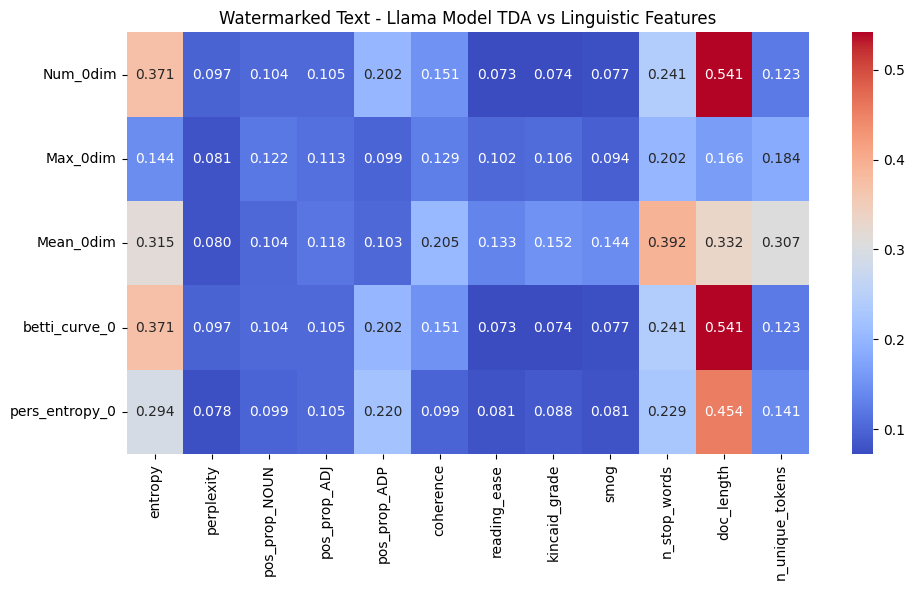

Computing correlations for non-watermarked text...


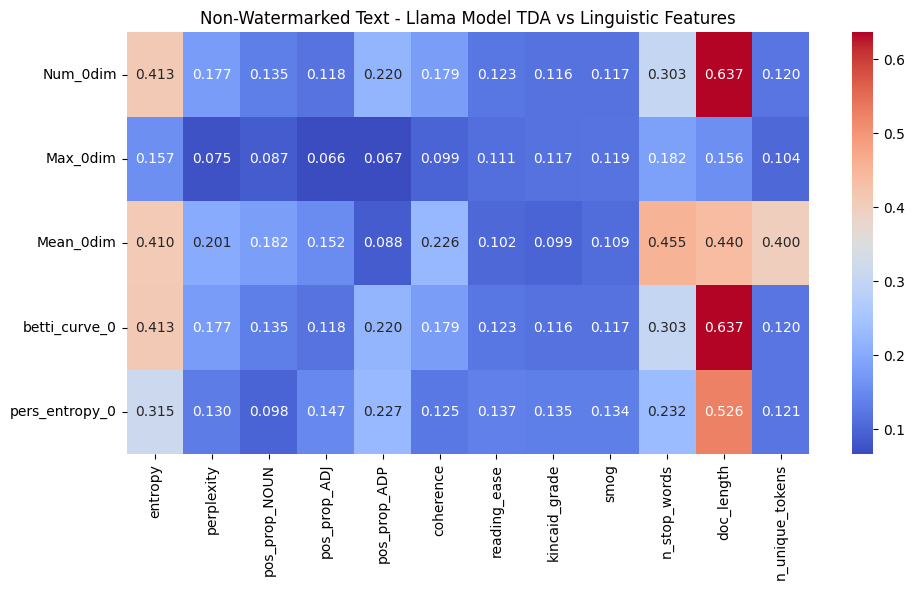


Analysis complete!


In [24]:
# Compute distance correlations and create heatmaps
!pip install dcor seaborn

from dcor import distance_correlation
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

# Watermarked text correlation
print("Computing correlations for watermarked text...")
tda_features = focus_tda_water.to_numpy()
linguistic_features = focus_water_feat.to_numpy()

corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Watermarked Text - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/Data/watermarked_correlation_llama.png", dpi=300, bbox_inches='tight')
plt.show()

# Non-watermarked text correlation
print("Computing correlations for non-watermarked text...")
tda_features = focus_tda_nonwater.to_numpy()
linguistic_features = focus_nonwater_feat.to_numpy()

corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Non-Watermarked Text - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/Data/nonwatermarked_correlation_llama.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete!")